# Off-policy n-step Expected SARSA

In the following notebook, we present an implementation of the *Off-policy n-step Expected-SARSA* algorithm, also known as *Expected-SARSA TD(n)*, using a neural network to approximate the Q-function. Our implementation follows the specifications of the *Off-policy n-step SARSA* algorithm as outlined in Chapter 7.3 of the book "Introduction to Reinforcement Learning" by Sutton and Barto [1]. The complete pseudocode of the algorithm is shown in the figure below. Our implementation differs from the mentioned algorithm in that we use a slightly different update rule (the Expected-SARSA update rule) and employ a neural network to approximate the action-value function instead of using a tabular one.
We then conduct a series of experiments with varying values of $n$ to compare their outcomes. In our implementation, we utilize an experience replay buffer, where each stored transition represents an n-step transition.

We use the *CartPole-v1* environment illustrated below, borrowed from the [CartPole Gymnasium webpage](https://gymnasium.farama.org/environments/classic_control/cart_pole/). The goal in the *CartPole-v1* environment is to reach balance a pole on a cart for as long as possible (although we terminate after 200 or so steps). 


<img src="../assets/cart_pole.gif">


So, let's begin.

In [1]:
# # uncomment when running on Google Colab
# !pip install -q torch
# !pip install -q gymnasium

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

Adding a few utility functions for plotting.

In [3]:
def plot_results(avg_scores, std_scores, name=None):
    # set title name
    if name is not None:
        title_name = f"Score averaged over different experiments ({name})"
    else:
        title_name = f"Score averaged over different experiments"
    
    # plot the results from a set of experiments
    n_episodes = len(avg_scores[0])
    n_experiments = len(avg_scores)

    avg_scores = np.array(avg_scores)
    avg_avg_scores = np.mean(avg_scores, axis=0)
    std_avg_scores = np.std(avg_scores, axis=0)
    max_avg_score = np.max(avg_scores, axis=0)
    min_avg_score = np.min(avg_scores, axis=0)

    upper_std_scores = max_avg_score
    lower_std_scores = min_avg_score
    x = range(1, n_episodes + 1)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 6), sharex=True)
    
    ax[0].set_title(title_name)
    ax[0].plot(x, avg_avg_scores, label=f'average score')
    ax[0].fill_between(x, upper_std_scores, lower_std_scores, 
                    where=(upper_std_scores > lower_std_scores), alpha=0.3)

    for i in range(n_experiments):
        avg_scores_numpy = np.array(avg_scores[i])
        std_scores_numpy = np.array(std_scores[i])
        upper = avg_scores_numpy + std_scores_numpy
        lower = avg_scores_numpy - std_scores_numpy
        ax[1].plot(x, avg_scores_numpy, label=f'Exp-{i}')
        ax[1].fill_between(x, upper, lower, where=(upper > lower), alpha=0.3)

    ax[1].set_xlabel('episode')
    ax[0].set_ylabel('score')
    ax[1].set_ylabel('score')
    ax[0].legend()
    ax[0].grid()
    ax[1].legend()
    ax[1].grid()
    plt.show()
    
def compare_results(data_dict, idx=0):
    """
    Compare the results from different experiments
    :param: data_dict = {name1: [avg_scores1, std_scores1], 
                         name2: [avg_scores2, std_scores2],
                         ...
                         nameN: [avg_scoresN, std_scoresN],}
    """
    
    # plot the results from a set of experiments
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 6))
    ax.set_title("Comparison of different RL algorithms' averaged score over a set of experiments")
    
    for item in data_dict:
        name = item
        avg_scores, std_scores = data_dict[name]
        
        n_episodes = len(avg_scores[0])
        n_experiments = len(avg_scores)

        avg_scores = np.array(avg_scores)
        avg_avg_scores = np.mean(avg_scores, axis=0)
        std_avg_scores = np.std(avg_scores, axis=0)
        max_avg_score = np.max(avg_scores, axis=0)
        min_avg_score = np.min(avg_scores, axis=0)

        upper_std_scores = max_avg_score
        lower_std_scores = min_avg_score
        x = range(1, n_episodes + 1)


        ax.plot(x[idx:], avg_avg_scores[idx:], label=f'{name} agent')
        ax.fill_between(x[idx:], upper_std_scores[idx:], lower_std_scores[idx:], 
                        where=(upper_std_scores[idx:] > lower_std_scores[idx:]), alpha=0.3)


    ax.set_ylabel('score')
    ax.legend()
    ax.grid()
    plt.show()

# Off-policy n-step Expected SARSA

Below is the complete *Off-policy n-step SARSA* with Q-function approximation (in our case, using a neural network) taken from [1], becuase the *Off-policy n-step Expected SARSA* pseudocode is not in [1]. However, the only differences between the two are:
1. The n-step importance sampling ration of Expected-SARSA is shorter by a single factor, and is given by the following
$$
\begin{align}
    \rho_{t:h} &= \prod^{\text{min}(h-1, T-1)}_{k=t}\frac{\pi(A_k\vert S_k)}{b(A_k\vert S_k)}
\end{align}
$$
while the Off-policy n-step SARSA importance sampling ration is given by
$$
\begin{align}
    \rho_{t:h} &= \prod^{\text{min}(h, T-1)}_{k=t}\frac{\pi(A_k\vert S_k)}{b(A_k\vert S_k)}
\end{align}
$$

2. The n-step Expected-SARSA update rule uses the following expected estimation for future return
$$
\begin{align}
    Q(A_t, S_t;W_{t+n}) &= Q(A_t, S_t;W_{t+n-1}) + \alpha \rho_{t+1:t+n-1}\left[G_{t:t+n} - Q(A_t, S_t;W_{t+n-1})\right],
\end{align}
$$
where,
$$
\begin{align}
    G_{t:t+n} &= R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots + \gamma^{n-1} R_{t+n} + \gamma^{n} \sum_{a}\pi(a\vert S_{t+n})Q(a, S_{t+n};W_{t+n-1})
\end{align}
$$
rather than the off-policy n-step SARSA update
$$
\begin{align}
    Q(A_t, S_t;W_{t+n}) &= Q(A_t, S_t;W_{t+n-1}) + \alpha \rho_{t+1:t+n}\left[G_{t:t+n} - Q(A_t, S_t;W_{t+n-1})\right],
\end{align}
$$
where,
$$
\begin{align}
    G_{t:t+n} &= R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots + \gamma^{n-1} R_{t+n} + \gamma^{n} Q(A_{t+n}, S_{t+n};W_{t+n-1})
\end{align}
$$

<img src="../assets/off_policy_n_step_SARSA_algorithm.png">

Therefore, we start by coding the Q-network.

In [4]:
class QNetwork(nn.Module):
    def __init__(self, observation_dim, action_dim, learning_rate):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=observation_dim, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.output_layer = nn.Linear(in_features=256, out_features=action_dim)

        self.optimizer = T.optim.Adam(params=self.parameters(), lr=learning_rate)
        self.device = ("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

Then, we code the n-step memory, that saves n-step transitions. Notice that the memory for a value of $n$ is $n+1$ long, and in the presented case of an Off-policy algorithm we also include the *importance sampling ration* of each action as a part of the transition.

In [5]:
class NStepMemory:
    def __init__(self, n, observation_dim):
        self.observation_dim = observation_dim
        self.n = n
        self.is_full = False
        self.ptr = 0

        self.observations = None
        self.actions = None
        self.rewards = None
        self.terminates = None
        self.importance_sampling_ratios = None

    def reset(self):
        self.observations = np.zeros((self.n + 1, self.observation_dim), dtype=np.float32)
        self.actions = np.zeros((self.n + 1, 1), dtype=int)
        self.rewards = np.zeros((self.n + 1, 1), dtype=np.float32)
        self.terminates = np.zeros((self.n + 1, 1), dtype=bool)
        self.importance_sampling_ratios = np.zeros((self.n + 1, 1), dtype=np.float32)
        self.ptr = 0

    def store_transition(self, reward, terminated, observation, action, importance_sampling_ratio):
        self.observations[self.ptr] = observation
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.terminates[self.ptr] = terminated
        self.importance_sampling_ratios[self.ptr] = importance_sampling_ratio

        self.ptr = (self.ptr + 1) % (self.n + 1)
        if self.ptr == 0 and not self.is_full:
            self.is_full = True
            print("memory is full...")

    def load_trajectory(self):
        assert self.is_full, "The memory is not full, wait until it will be full before loading a trajectory."
        observations = np.concatenate((self.observations[self.ptr:], self.observations[:self.ptr]))
        actions = np.concatenate((self.actions[self.ptr:], self.actions[:self.ptr]))
        rewards = np.concatenate((self.rewards[self.ptr:], self.rewards[:self.ptr]))
        terminates = np.concatenate((self.terminates[self.ptr:], self.terminates[:self.ptr]))
        importance_sampling_ratios = np.concatenate((self.importance_sampling_ratios[self.ptr:], 
                                                     self.importance_sampling_ratios[:self.ptr]))
        return observations, actions, rewards, terminates, importance_sampling_ratios


Next, we code the replay buffer for n-step transitions.

In [6]:
class ReplayBuffer:
    def __init__(self, memory_size, observation_dim, n):
        self.observation_dim = observation_dim
        self.memory_size = memory_size
        self.n = n
        self.ptr = 0
        self.is_full = False

        self.observations = None
        self.actions = None
        self.rewards = None
        self.terminates = None
        self.importance_sampling_ratios = None

    def reset(self):
        print("reset buffer...")
        self.observations = np.zeros((self.memory_size, self.n + 1, self.observation_dim), dtype=np.float32)
        self.actions = np.zeros((self.memory_size, self.n + 1, 1), dtype=int)
        self.rewards = np.zeros((self.memory_size, self.n + 1, 1), dtype=np.float32)
        self.terminates = np.zeros((self.memory_size, self.n + 1, 1), dtype=bool)
        self.importance_sampling_ratios = np.zeros((self.memory_size, self.n + 1, 1), dtype=np.float32)
        self.ptr = 0

    def store_transition(self, observations, actions, rewards, terminates, importance_sampling_ratios):
        self.observations[self.ptr] = observations
        self.actions[self.ptr] = actions
        self.rewards[self.ptr] = rewards
        self.terminates[self.ptr] = terminates
        self.importance_sampling_ratios[self.ptr] = importance_sampling_ratios

        self.ptr = (self.ptr + 1) % self.memory_size
        if self.ptr == 0 and not self.is_full:
            self.is_full = True
            print("buffer is full...")

    def load_transition(self, batch_size=1):
        upper = self.memory_size if self.is_full else self.ptr
        samples = np.random.choice(upper, size=batch_size)
        return (self.observations[samples], self.actions[samples], self.rewards[samples], 
                self.terminates[samples], self.importance_sampling_ratios[samples])


Presently, we proceed to construct the Off-policy n-step Expected-SARSA agent. In the current implementation we set an $\epsilon$-greedy policy as the behaviour policy, which is given by the following
$$
\begin{align}
    b(a\vert s) &= 
    \begin{cases}
        (1-\epsilon)1 + \epsilon\frac{1}{\vert\mathcal{A}\vert} & a=argmax_{x}\left[Q(x, s)\right]\\
        \epsilon\frac{1}{\vert\mathcal{A}\vert}, & \text{otherwise}
    \end{cases}
\end{align}
$$
and the Botzmann (Softmax) policy (with a temperature of $1$) for the target policy 
$$
\begin{align}
    \pi(a\vert s) &= \frac{e^{Q(a, s)}}{\sum_{a_i\in\mathcal{A}}e^{Q(a_i, s)}}
\end{align}
$$
Therefore, the importance sampling ratio for the greedy action can be calculated analytically and is given by
$$
\begin{align}
    \rho(a_{greedy}^{(t)}) = \frac{\pi(a_{greedy}^{(t)}\vert s)}{b(a_{greedy}^{(t)}\vert s)} &= \frac{\frac{e^{Q(a_{greedy}, s)}}{\sum_{a_i\in\mathcal{A}}e^{Q(a_i, s)}}}{(1-\epsilon(t))1 + \epsilon(t)\frac{1}{\vert\mathcal{A}\vert}}
\end{align}
$$
Thus, for each time-step we compute that ration, save it as a part of an n-step transition, and store it in the buffer.

In [7]:
class NStepExpectedSarsaAgentWithBuffer:
    def __init__(self, observation_dim, n_actions, learning_rate, gamma, epsilon, epsilon_dec,
                 epsilon_min, n, memory_size):
        self.observation_dim = observation_dim
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.n = n
        self.memory_size = memory_size

        # initialize a Q-network
        self.q = QNetwork(observation_dim=observation_dim, action_dim=n_actions, learning_rate=learning_rate)

        # initialize an n-step memory
        self.memory = NStepMemory(n=self.n, observation_dim=self.observation_dim)

        # initialize a replay buffer
        self.replay_buffer = ReplayBuffer(memory_size=self.memory_size, observation_dim=self.observation_dim, n=self.n)
        self.replay_buffer.reset()
    
    def full_reset(self):
        print("agent full reset...")
        self.memory.reset()
        self.replay_buffer.reset()
        self.q = QNetwork(observation_dim=self.observation_dim, action_dim=self.n_actions, 
                          learning_rate=self.learning_rate)

    def reset(self):
        self.tau = 0
        self.memory.reset()

    def choose_action(self, observation):
        observation = T.Tensor(observation).float().to(self.q.device)
        q_values = self.q(observation)
        softmax_probs = F.softmax(q_values, dim=0)
        random_action = None
        greedy_action = T.argmax(q_values).item()
        
        # maybe take random action
        if np.random.rand() < self.epsilon:
            random_action = np.random.randint(self.n_actions)
        
        # return action and its probability
        if random_action is None or random_action == greedy_action:
            action_soft_prob = softmax_probs[greedy_action].item()
            prob = action_soft_prob / (1 - self.epsilon + self.epsilon / self.n_actions)
            return greedy_action, prob
        else:
            action_soft_prob = softmax_probs[random_action].item()
            prob = action_soft_prob / (self.epsilon / self.n_actions)
            return random_action, prob

    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon - self.epsilon_dec, self.epsilon_min])

    def value_estimate(self, observation, action):
        observation = T.Tensor(observation).float().to(self.q.device)
        action = T.Tensor([action]).int().view(-1).to(self.q.device)
        q_value = self.q(observation)[action]
        return q_value

    def store_transition(self, reward, terminated, observation, action, importance_sampling_ratio):
        self.memory.store_transition(reward, terminated, observation, action, importance_sampling_ratio)
        if self.memory.is_full:
            observations, actions, rewards, terminates, importance_sampling_ratios = self.memory.load_trajectory()
            self.replay_buffer.store_transition(observations, actions, rewards, terminates, importance_sampling_ratios)

    def load_transition(self, batch_size=1):
        return self.replay_buffer.load_transition(batch_size=batch_size)

    def learn(self, batch_size=1):
        if not self.replay_buffer.is_full and self.replay_buffer.ptr <= batch_size:
            return
        # load n-step trajectory
        observations, actions, rewards, terminates, importance_sampling_ratios = self.load_transition(batch_size=batch_size)

        # send trajectory to device
        observations = T.Tensor(observations).float().to(self.q.device)         # (batch_size, n, observation_dim)
        actions = T.Tensor(actions).int().squeeze().to(self.q.device)           # (batch_size, n)
        rewards = T.Tensor(rewards).float().squeeze().to(self.q.device)         # (batch_size, n)
        terminates = T.Tensor(terminates).bool().squeeze().to(self.q.device)    # (batch_size, n)
        importance_sampling_ratios = T.Tensor(importance_sampling_ratios
                                             ).float().squeeze().to(self.q.device)         # (batch_size, n)

        # compute the return
        indices = T.arange(batch_size).to(self.q.device)
        ratios = T.prod(importance_sampling_ratios[:, :-1], dim=1)
        gammas = T.pow(self.gamma * T.ones(self.n), T.arange(self.n)).to(self.q.device)
        target = T.tensordot(rewards[:, 1:], gammas, dims=([1], [0]))
        target = target * ratios
        
        # compute the expected sarsa average q-value
        next_q_values = self.q(observations[:, -1])                            # get value estimation for retrun
        probs = F.softmax(next_q_values, dim=1)                                # compute the probabilities for action
        expected_next_q_values = T.sum(probs * next_q_values, dim=1).detach()  # compute the Expected-Sarsa value
        
        # add the value to the return
        expected_next_q_values[terminates[:, -1]] = 0.0
        target = target + np.power(self.gamma, self.n) * expected_next_q_values
        
        # get the original q-value 
        q_value = self.q(observations[:, 0])[indices, actions[:, 0]]

        # train the network
        self.q.optimizer.zero_grad()
        loss = F.mse_loss(q_value, target)
        loss.backward()
        self.q.optimizer.step()

        # decrement epsilon
        self.decrement_epsilon()


In order to make things a bit easier on the eyes, we code the experiment loop as a function. 

In [8]:
def run_loop(env_name, agent, n_experiments, n_episodes, max_steps):
    
    scores = []
    avg_scores = []
    std_scores = []
    
    # experiments loop
    for ex_i in range(n_experiments):
        scores.append([])
        avg_scores.append([])
        std_scores.append([])
        
        # reset the agent completely for each experiment
        env = gym.make(env_name)
        agent.full_reset()
        
        # episodes loop
        for ep_i in range(n_episodes):
            score = 0
            done = False
            step = 0
            
            # reset the env and the agent
            agent.reset()
            observation, info = env.reset()
            action, importance_sampling_ratio = agent.choose_action(observation)

            # store state and action
            agent.store_transition(0.0, False, observation, action, importance_sampling_ratio)
            
            # a single episode loop
            while not done:
                
                # step the environment
                next_observation, reward, terminated, truncated, info = env.step(action)
                score += reward

                # select the next action
                next_action, next_importance_sampling_ratio = agent.choose_action(next_observation)

                # store the Off-policy Expected SARSA transition
                agent.store_transition(reward, terminated, next_observation, next_action, 
                                       next_importance_sampling_ratio)
                action = next_action

                # check for termination
                if terminated or truncated or step == max_steps:
                    done = True
                    scores[ex_i].append(score)
                    avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                    std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
                
                # train the agent
                agent.learn(batch_size=BATCH_SIZE)
                step += 1
                
            # print results status
            if ep_i % 10 == 0:
                print(f'| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {np.round(score, 2):4.1f} |' +
                      f' Avg score: {np.round(avg_scores[ex_i][-1], 2):4.1f} |')
        env.close()    
    return avg_scores, std_scores

Finally, we conduct a few experiments with identical hyperparameters but different values of $n$ and compare their results. We do not expect that the same hyperparameter vector will produce good results for different $n$ values. However, it provides us with a sense of what to expect in a complete optimization process for each $n$.

In [21]:
# make the environment
env_name = "CartPole-v1"
env = gym.make(env_name)

# set experiment results dictionary
results_data_dict = {}

# set the hyperparameters for the agent
N_EXPERIMENTS = 10
N_EPISODES = 1000
MAX_STEPS = 500
GAMMA = 0.99
LR = 0.001
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.2)
OBSERVATION_DIM = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n
ACTION_DIM = 1
MEMORY_SIZE = 100000
BATCH_SIZE = 8


# set the number of steps to use in the n-steps algorithm
n_list = [1, 2, 4, 8, 16]

# run experiments for different n-step values
for n in n_list:
    print(f"\nInitializing a new experiment of an Off-policy n-step Expected SARSA with n = {str(n)}...")
    
    # initialize the agent
    agent = NStepExpectedSarsaAgentWithBuffer(observation_dim=OBSERVATION_DIM, 
                                              n_actions=N_ACTIONS,
                                              learning_rate=LR, 
                                              gamma=GAMMA, 
                                              epsilon=EPSILON, 
                                              epsilon_dec=EPSILON_DEC,
                                              epsilon_min=EPSILON_MIN,  
                                              memory_size=MEMORY_SIZE,
                                              n=n)

    # run single experiment
    avg_scores, std_scores = run_loop(env_name=env_name, 
                                      agent=agent, 
                                      n_experiments=N_EXPERIMENTS, 
                                      n_episodes=N_EPISODES, 
                                      max_steps=MAX_STEPS)

    # save experiment's data for later comparison
    results_data_dict[f"n = {str(n)}"] = avg_scores, std_scores


Initializing a new experiment of an Off-policy n-step Expected SARSA with n = 1...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    1 | Episode:   10 | Score:  9.0 | Avg score: 16.0 |
| Experiment:    1 | Episode:   20 | Score: 28.0 | Avg score: 16.1 |
| Experiment:    1 | Episode:   30 | Score: 16.0 | Avg score: 20.9 |
| Experiment:    1 | Episode:   40 | Score: 11.0 | Avg score: 20.5 |
| Experiment:    1 | Episode:   50 | Score: 36.0 | Avg score: 21.6 |
| Experiment:    1 | Episode:   60 | Score: 110.0 | Avg score: 25.0 |
| Experiment:    1 | Episode:   70 | Score: 107.0 | Avg score: 30.5 |
| Experiment:    1 | Episode:   80 | Score: 180.0 | Avg score: 40.2 |
| Experiment:    1 | Episode:   90 | Score: 118.0 | Avg score: 50.4 |
| Experiment:    1 | Episode:  100 | Score: 10.0 | Avg score: 53.4 |
| Experiment:    1 | Episode:  110 | Score: 304.0 | Avg score: 67.8 |
| Experiment:

| Experiment:    2 | Episode:  150 | Score: 23.0 | Avg score: 16.9 |
| Experiment:    2 | Episode:  160 | Score: 22.0 | Avg score: 18.7 |
| Experiment:    2 | Episode:  170 | Score: 24.0 | Avg score: 20.0 |
| Experiment:    2 | Episode:  180 | Score: 15.0 | Avg score: 21.0 |
| Experiment:    2 | Episode:  190 | Score: 15.0 | Avg score: 20.8 |
| Experiment:    2 | Episode:  200 | Score:  9.0 | Avg score: 20.4 |
| Experiment:    2 | Episode:  210 | Score: 10.0 | Avg score: 19.3 |
| Experiment:    2 | Episode:  220 | Score:  9.0 | Avg score: 18.2 |
| Experiment:    2 | Episode:  230 | Score: 10.0 | Avg score: 17.1 |
| Experiment:    2 | Episode:  240 | Score: 12.0 | Avg score: 15.8 |
| Experiment:    2 | Episode:  250 | Score: 10.0 | Avg score: 14.5 |
| Experiment:    2 | Episode:  260 | Score:  9.0 | Avg score: 12.9 |
| Experiment:    2 | Episode:  270 | Score:  9.0 | Avg score: 11.8 |
| Experiment:    2 | Episode:  280 | Score: 10.0 | Avg score: 10.9 |
| Experiment:    2 | Episode:  290

| Experiment:    3 | Episode:  360 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:  370 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    3 | Episode:  380 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    3 | Episode:  390 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  400 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  410 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  420 | Score: 11.0 | Avg score:  9.7 |
| Experiment:    3 | Episode:  430 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    3 | Episode:  440 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    3 | Episode:  450 | Score:  9.0 | Avg score: 10.5 |
| Experiment:    3 | Episode:  460 | Score: 24.0 | Avg score: 11.3 |
| Experiment:    3 | Episode:  470 | Score: 31.0 | Avg score: 12.8 |
| Experiment:    3 | Episode:  480 | Score: 151.0 | Avg score: 16.8 |
| Experiment:    3 | Episode:  490 | Score: 10.0 | Avg score: 20.8 |
| Experiment:    3 | Episode:  50

| Experiment:    4 | Episode:  540 | Score: 496.0 | Avg score: 78.5 |
| Experiment:    4 | Episode:  550 | Score:  9.0 | Avg score: 76.9 |
| Experiment:    4 | Episode:  560 | Score: 300.0 | Avg score: 83.9 |
| Experiment:    4 | Episode:  570 | Score: 96.0 | Avg score: 96.1 |
| Experiment:    4 | Episode:  580 | Score: 65.0 | Avg score: 100.2 |
| Experiment:    4 | Episode:  590 | Score: 145.0 | Avg score: 103.3 |
| Experiment:    4 | Episode:  600 | Score: 164.0 | Avg score: 108.6 |
| Experiment:    4 | Episode:  610 | Score: 140.0 | Avg score: 124.6 |
| Experiment:    4 | Episode:  620 | Score: 299.0 | Avg score: 137.3 |
| Experiment:    4 | Episode:  630 | Score: 217.0 | Avg score: 164.5 |
| Experiment:    4 | Episode:  640 | Score: 199.0 | Avg score: 185.6 |
| Experiment:    4 | Episode:  650 | Score: 291.0 | Avg score: 212.9 |
| Experiment:    4 | Episode:  660 | Score: 173.0 | Avg score: 224.6 |
| Experiment:    4 | Episode:  670 | Score: 159.0 | Avg score: 231.2 |
| Experiment:

| Experiment:    5 | Episode:  710 | Score: 199.0 | Avg score: 128.3 |
| Experiment:    5 | Episode:  720 | Score: 224.0 | Avg score: 144.6 |
| Experiment:    5 | Episode:  730 | Score: 166.0 | Avg score: 157.4 |
| Experiment:    5 | Episode:  740 | Score: 500.0 | Avg score: 184.6 |
| Experiment:    5 | Episode:  750 | Score: 356.0 | Avg score: 215.3 |
| Experiment:    5 | Episode:  760 | Score: 354.0 | Avg score: 240.1 |
| Experiment:    5 | Episode:  770 | Score: 320.0 | Avg score: 268.8 |
| Experiment:    5 | Episode:  780 | Score: 454.0 | Avg score: 282.7 |
| Experiment:    5 | Episode:  790 | Score: 248.0 | Avg score: 293.0 |
| Experiment:    5 | Episode:  800 | Score: 288.0 | Avg score: 301.8 |
| Experiment:    5 | Episode:  810 | Score: 215.0 | Avg score: 304.8 |
| Experiment:    5 | Episode:  820 | Score: 297.0 | Avg score: 302.3 |
| Experiment:    5 | Episode:  830 | Score: 284.0 | Avg score: 307.4 |
| Experiment:    5 | Episode:  840 | Score: 196.0 | Avg score: 294.2 |
| Expe

| Experiment:    6 | Episode:  890 | Score: 162.0 | Avg score: 126.7 |
| Experiment:    6 | Episode:  900 | Score: 382.0 | Avg score: 162.9 |
| Experiment:    6 | Episode:  910 | Score: 270.0 | Avg score: 178.3 |
| Experiment:    6 | Episode:  920 | Score: 214.0 | Avg score: 198.6 |
| Experiment:    6 | Episode:  930 | Score: 248.0 | Avg score: 219.7 |
| Experiment:    6 | Episode:  940 | Score: 369.0 | Avg score: 236.3 |
| Experiment:    6 | Episode:  950 | Score: 165.0 | Avg score: 252.4 |
| Experiment:    6 | Episode:  960 | Score: 323.0 | Avg score: 282.8 |
| Experiment:    6 | Episode:  970 | Score: 160.0 | Avg score: 284.2 |
| Experiment:    6 | Episode:  980 | Score: 500.0 | Avg score: 301.4 |
| Experiment:    6 | Episode:  990 | Score: 218.0 | Avg score: 324.9 |
agent full reset...
reset buffer...
| Experiment:    7 | Episode:    0 | Score: 28.0 | Avg score: 28.0 |
| Experiment:    7 | Episode:   10 | Score: 26.0 | Avg score: 44.4 |
| Experiment:    7 | Episode:   20 | Score: 1

| Experiment:    8 | Episode:   70 | Score: 10.0 | Avg score: 10.7 |
| Experiment:    8 | Episode:   80 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    8 | Episode:   90 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    8 | Episode:  100 | Score:  9.0 | Avg score: 10.2 |
| Experiment:    8 | Episode:  110 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  120 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  130 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  140 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  150 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  160 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  170 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  180 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  190 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    8 | Episode:  200 | Score:  8.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  210

| Experiment:    9 | Episode:  270 | Score: 15.0 | Avg score: 10.1 |
| Experiment:    9 | Episode:  280 | Score: 15.0 | Avg score: 10.7 |
| Experiment:    9 | Episode:  290 | Score:  9.0 | Avg score: 10.9 |
| Experiment:    9 | Episode:  300 | Score: 10.0 | Avg score: 11.1 |
| Experiment:    9 | Episode:  310 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    9 | Episode:  320 | Score: 10.0 | Avg score: 11.3 |
| Experiment:    9 | Episode:  330 | Score:  8.0 | Avg score: 11.3 |
| Experiment:    9 | Episode:  340 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    9 | Episode:  350 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    9 | Episode:  360 | Score:  9.0 | Avg score: 11.1 |
| Experiment:    9 | Episode:  370 | Score:  9.0 | Avg score: 10.6 |
| Experiment:    9 | Episode:  380 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    9 | Episode:  390 | Score:  8.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  400 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  410

| Experiment:   10 | Episode:  470 | Score: 11.0 | Avg score: 20.8 |
| Experiment:   10 | Episode:  480 | Score: 36.0 | Avg score: 21.7 |
| Experiment:   10 | Episode:  490 | Score: 209.0 | Avg score: 27.0 |
| Experiment:   10 | Episode:  500 | Score: 10.0 | Avg score: 28.4 |
| Experiment:   10 | Episode:  510 | Score: 13.0 | Avg score: 30.0 |
| Experiment:   10 | Episode:  520 | Score: 41.0 | Avg score: 31.6 |
| Experiment:   10 | Episode:  530 | Score:  9.0 | Avg score: 31.5 |
| Experiment:   10 | Episode:  540 | Score: 33.0 | Avg score: 31.6 |
| Experiment:   10 | Episode:  550 | Score: 12.0 | Avg score: 31.1 |
| Experiment:   10 | Episode:  560 | Score:  8.0 | Avg score: 30.6 |
| Experiment:   10 | Episode:  570 | Score: 29.0 | Avg score: 29.3 |
| Experiment:   10 | Episode:  580 | Score: 31.0 | Avg score: 30.8 |
| Experiment:   10 | Episode:  590 | Score: 10.0 | Avg score: 25.7 |
| Experiment:   10 | Episode:  600 | Score: 31.0 | Avg score: 24.1 |
| Experiment:   10 | Episode:  61

| Experiment:    1 | Episode:  620 | Score: 14.0 | Avg score: 236.4 |
| Experiment:    1 | Episode:  630 | Score: 500.0 | Avg score: 229.4 |
| Experiment:    1 | Episode:  640 | Score: 500.0 | Avg score: 229.6 |
| Experiment:    1 | Episode:  650 | Score: 240.0 | Avg score: 238.1 |
| Experiment:    1 | Episode:  660 | Score: 500.0 | Avg score: 258.4 |
| Experiment:    1 | Episode:  670 | Score: 61.0 | Avg score: 270.1 |
| Experiment:    1 | Episode:  680 | Score: 18.0 | Avg score: 265.9 |
| Experiment:    1 | Episode:  690 | Score: 214.0 | Avg score: 230.7 |
| Experiment:    1 | Episode:  700 | Score: 220.0 | Avg score: 248.7 |
| Experiment:    1 | Episode:  710 | Score: 97.0 | Avg score: 255.8 |
| Experiment:    1 | Episode:  720 | Score: 500.0 | Avg score: 247.9 |
| Experiment:    1 | Episode:  730 | Score: 99.0 | Avg score: 251.3 |
| Experiment:    1 | Episode:  740 | Score: 336.0 | Avg score: 249.2 |
| Experiment:    1 | Episode:  750 | Score: 13.0 | Avg score: 226.2 |
| Experiment

| Experiment:    2 | Episode:  830 | Score: 14.0 | Avg score: 10.6 |
| Experiment:    2 | Episode:  840 | Score: 10.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:  850 | Score:  9.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:  860 | Score: 11.0 | Avg score: 10.9 |
| Experiment:    2 | Episode:  870 | Score: 12.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:  880 | Score: 12.0 | Avg score: 10.9 |
| Experiment:    2 | Episode:  890 | Score: 10.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:  900 | Score: 11.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:  910 | Score:  9.0 | Avg score: 10.9 |
| Experiment:    2 | Episode:  920 | Score: 11.0 | Avg score: 10.9 |
| Experiment:    2 | Episode:  930 | Score: 10.0 | Avg score: 10.7 |
| Experiment:    2 | Episode:  940 | Score: 10.0 | Avg score: 10.4 |
| Experiment:    2 | Episode:  950 | Score: 12.0 | Avg score: 10.5 |
| Experiment:    2 | Episode:  960 | Score: 10.0 | Avg score: 10.4 |
| Experiment:    2 | Episode:  970

| Experiment:    4 | Episode:   40 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:   50 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   60 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:   70 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   80 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:   90 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  110 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  120 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  130 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  140 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  150 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  160 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  170 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  180

| Experiment:    5 | Episode:  250 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  260 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  270 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  280 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  290 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  300 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  310 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  320 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  330 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  340 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  350 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  360 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  370 | Score: 14.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  380 | Score: 18.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:  390

| Experiment:    6 | Episode:  440 | Score: 35.0 | Avg score: 34.6 |
| Experiment:    6 | Episode:  450 | Score: 41.0 | Avg score: 37.6 |
| Experiment:    6 | Episode:  460 | Score: 64.0 | Avg score: 41.5 |
| Experiment:    6 | Episode:  470 | Score: 63.0 | Avg score: 46.6 |
| Experiment:    6 | Episode:  480 | Score: 103.0 | Avg score: 51.5 |
| Experiment:    6 | Episode:  490 | Score: 48.0 | Avg score: 55.0 |
| Experiment:    6 | Episode:  500 | Score: 94.0 | Avg score: 60.3 |
| Experiment:    6 | Episode:  510 | Score: 75.0 | Avg score: 63.8 |
| Experiment:    6 | Episode:  520 | Score: 83.0 | Avg score: 67.0 |
| Experiment:    6 | Episode:  530 | Score: 15.0 | Avg score: 64.7 |
| Experiment:    6 | Episode:  540 | Score: 32.0 | Avg score: 60.2 |
| Experiment:    6 | Episode:  550 | Score:  8.0 | Avg score: 60.9 |
| Experiment:    6 | Episode:  560 | Score:  8.0 | Avg score: 62.0 |
| Experiment:    6 | Episode:  570 | Score: 187.0 | Avg score: 67.3 |
| Experiment:    6 | Episode:  5

| Experiment:    7 | Episode:  640 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  650 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  660 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  670 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  680 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  690 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  700 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  710 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  720 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  730 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  740 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  750 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  760 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  770 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  780

| Experiment:    8 | Episode:  860 | Score: 13.0 | Avg score: 12.6 |
| Experiment:    8 | Episode:  870 | Score:  8.0 | Avg score: 12.6 |
| Experiment:    8 | Episode:  880 | Score:  9.0 | Avg score: 12.8 |
| Experiment:    8 | Episode:  890 | Score: 12.0 | Avg score: 12.6 |
| Experiment:    8 | Episode:  900 | Score: 14.0 | Avg score: 12.3 |
| Experiment:    8 | Episode:  910 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    8 | Episode:  920 | Score: 13.0 | Avg score: 11.0 |
| Experiment:    8 | Episode:  930 | Score: 13.0 | Avg score: 11.2 |
| Experiment:    8 | Episode:  940 | Score: 15.0 | Avg score: 11.7 |
| Experiment:    8 | Episode:  950 | Score: 14.0 | Avg score: 12.5 |
| Experiment:    8 | Episode:  960 | Score: 17.0 | Avg score: 13.1 |
| Experiment:    8 | Episode:  970 | Score: 12.0 | Avg score: 13.9 |
| Experiment:    8 | Episode:  980 | Score: 35.0 | Avg score: 14.7 |
| Experiment:    8 | Episode:  990 | Score: 14.0 | Avg score: 15.0 |
agent full reset...
reset buffer..

| Experiment:   10 | Episode:   50 | Score:  9.0 | Avg score: 16.4 |
| Experiment:   10 | Episode:   60 | Score:  9.0 | Avg score: 15.2 |
| Experiment:   10 | Episode:   70 | Score:  9.0 | Avg score: 14.4 |
| Experiment:   10 | Episode:   80 | Score:  9.0 | Avg score: 13.7 |
| Experiment:   10 | Episode:   90 | Score:  9.0 | Avg score: 13.2 |
| Experiment:   10 | Episode:  100 | Score: 10.0 | Avg score: 12.7 |
| Experiment:   10 | Episode:  110 | Score:  9.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  120 | Score: 11.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  130 | Score: 10.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  140 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  150 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  160 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  170 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  180 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  190

| Experiment:    1 | Episode:  210 | Score: 43.0 | Avg score: 43.3 |
| Experiment:    1 | Episode:  220 | Score: 45.0 | Avg score: 47.4 |
| Experiment:    1 | Episode:  230 | Score: 30.0 | Avg score: 47.4 |
| Experiment:    1 | Episode:  240 | Score: 62.0 | Avg score: 47.8 |
| Experiment:    1 | Episode:  250 | Score: 108.0 | Avg score: 54.1 |
| Experiment:    1 | Episode:  260 | Score: 43.0 | Avg score: 56.3 |
| Experiment:    1 | Episode:  270 | Score: 117.0 | Avg score: 59.5 |
| Experiment:    1 | Episode:  280 | Score: 34.0 | Avg score: 61.2 |
| Experiment:    1 | Episode:  290 | Score: 46.0 | Avg score: 60.8 |
| Experiment:    1 | Episode:  300 | Score: 55.0 | Avg score: 63.0 |
| Experiment:    1 | Episode:  310 | Score: 54.0 | Avg score: 64.3 |
| Experiment:    1 | Episode:  320 | Score: 81.0 | Avg score: 63.9 |
| Experiment:    1 | Episode:  330 | Score: 75.0 | Avg score: 67.5 |
| Experiment:    1 | Episode:  340 | Score: 88.0 | Avg score: 69.3 |
| Experiment:    1 | Episode:  3

| Experiment:    2 | Episode:  390 | Score:  9.0 | Avg score: 17.6 |
| Experiment:    2 | Episode:  400 | Score: 31.0 | Avg score: 15.5 |
| Experiment:    2 | Episode:  410 | Score: 10.0 | Avg score: 15.6 |
| Experiment:    2 | Episode:  420 | Score:  9.0 | Avg score: 15.0 |
| Experiment:    2 | Episode:  430 | Score: 10.0 | Avg score: 13.9 |
| Experiment:    2 | Episode:  440 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    2 | Episode:  450 | Score: 10.0 | Avg score: 10.9 |
| Experiment:    2 | Episode:  460 | Score:  9.0 | Avg score: 10.7 |
| Experiment:    2 | Episode:  470 | Score: 11.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:  480 | Score:  9.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:  490 | Score: 12.0 | Avg score: 11.5 |
| Experiment:    2 | Episode:  500 | Score:  9.0 | Avg score: 11.4 |
| Experiment:    2 | Episode:  510 | Score:  9.0 | Avg score: 10.9 |
| Experiment:    2 | Episode:  520 | Score: 22.0 | Avg score: 11.3 |
| Experiment:    2 | Episode:  530

| Experiment:    3 | Episode:  610 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  620 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  630 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  640 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  650 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  660 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  670 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  680 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  690 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  700 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  710 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  720 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  730 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  740 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  750

| Experiment:    4 | Episode:  810 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  820 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  830 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  840 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  850 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  860 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  870 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  880 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  890 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  900 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  910 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  920 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  930 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  940 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  950

agent full reset...
reset buffer...
| Experiment:    6 | Episode:    0 | Score: 108.0 | Avg score: 108.0 |
| Experiment:    6 | Episode:   10 | Score:  9.0 | Avg score: 40.6 |
| Experiment:    6 | Episode:   20 | Score: 10.0 | Avg score: 25.8 |
| Experiment:    6 | Episode:   30 | Score:  8.0 | Avg score: 20.4 |
| Experiment:    6 | Episode:   40 | Score: 10.0 | Avg score: 17.8 |
| Experiment:    6 | Episode:   50 | Score:  9.0 | Avg score: 16.0 |
| Experiment:    6 | Episode:   60 | Score: 10.0 | Avg score: 15.0 |
| Experiment:    6 | Episode:   70 | Score:  9.0 | Avg score: 14.2 |
| Experiment:    6 | Episode:   80 | Score:  9.0 | Avg score: 13.6 |
| Experiment:    6 | Episode:   90 | Score: 10.0 | Avg score: 13.2 |
| Experiment:    6 | Episode:  100 | Score:  9.0 | Avg score: 11.8 |
| Experiment:    6 | Episode:  110 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  120 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  130 | Score:  9.0 | Avg score:  9.

| Experiment:    7 | Episode:  180 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  190 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  200 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  210 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  220 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  230 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  240 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  250 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  260 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  270 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  280 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  290 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  300 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  310 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    7 | Episode:  320

| Experiment:    8 | Episode:  390 | Score: 24.0 | Avg score: 18.4 |
| Experiment:    8 | Episode:  400 | Score: 59.0 | Avg score: 19.9 |
| Experiment:    8 | Episode:  410 | Score:  9.0 | Avg score: 18.2 |
| Experiment:    8 | Episode:  420 | Score: 10.0 | Avg score: 16.8 |
| Experiment:    8 | Episode:  430 | Score: 10.0 | Avg score: 16.8 |
| Experiment:    8 | Episode:  440 | Score:  8.0 | Avg score: 16.6 |
| Experiment:    8 | Episode:  450 | Score: 10.0 | Avg score: 12.6 |
| Experiment:    8 | Episode:  460 | Score: 10.0 | Avg score: 12.4 |
| Experiment:    8 | Episode:  470 | Score: 10.0 | Avg score: 12.5 |
| Experiment:    8 | Episode:  480 | Score: 10.0 | Avg score: 12.5 |
| Experiment:    8 | Episode:  490 | Score: 101.0 | Avg score: 15.4 |
| Experiment:    8 | Episode:  500 | Score: 10.0 | Avg score: 12.7 |
| Experiment:    8 | Episode:  510 | Score: 10.0 | Avg score: 12.7 |
| Experiment:    8 | Episode:  520 | Score: 10.0 | Avg score: 12.7 |
| Experiment:    8 | Episode:  53

| Experiment:    9 | Episode:  590 | Score:  8.0 | Avg score: 15.6 |
| Experiment:    9 | Episode:  600 | Score:  9.0 | Avg score: 15.6 |
| Experiment:    9 | Episode:  610 | Score:  9.0 | Avg score: 15.5 |
| Experiment:    9 | Episode:  620 | Score:  9.0 | Avg score: 15.5 |
| Experiment:    9 | Episode:  630 | Score:  9.0 | Avg score: 15.5 |
| Experiment:    9 | Episode:  640 | Score:  9.0 | Avg score: 15.3 |
| Experiment:    9 | Episode:  650 | Score: 10.0 | Avg score: 13.4 |
| Experiment:    9 | Episode:  660 | Score: 10.0 | Avg score: 10.9 |
| Experiment:    9 | Episode:  670 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  680 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  690 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  700 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  710 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  720 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  730

| Experiment:   10 | Episode:  790 | Score:  9.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  800 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  810 | Score:  9.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  820 | Score: 10.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  830 | Score:  9.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  840 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  850 | Score:  9.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  860 | Score:  9.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  870 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  880 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  890 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  900 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  910 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  920 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  930

| Experiment:    1 | Episode:  970 | Score: 38.0 | Avg score: 35.8 |
| Experiment:    1 | Episode:  980 | Score: 38.0 | Avg score: 35.8 |
| Experiment:    1 | Episode:  990 | Score: 28.0 | Avg score: 35.9 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    2 | Episode:   10 | Score: 10.0 | Avg score: 14.1 |
| Experiment:    2 | Episode:   20 | Score: 22.0 | Avg score: 18.3 |
| Experiment:    2 | Episode:   30 | Score: 14.0 | Avg score: 19.6 |
| Experiment:    2 | Episode:   40 | Score: 24.0 | Avg score: 18.3 |
| Experiment:    2 | Episode:   50 | Score:  9.0 | Avg score: 16.8 |
| Experiment:    2 | Episode:   60 | Score:  9.0 | Avg score: 15.6 |
| Experiment:    2 | Episode:   70 | Score:  9.0 | Avg score: 14.7 |
| Experiment:    2 | Episode:   80 | Score:  9.0 | Avg score: 13.9 |
| Experiment:    2 | Episode:   90 | Score:  8.0 | Avg score: 13.5 |
| Experiment:    2 | Episode:  100 | Score: 10.0 | Avg score: 13.1 

| Experiment:    3 | Episode:  160 | Score: 10.0 | Avg score: 11.8 |
| Experiment:    3 | Episode:  170 | Score: 23.0 | Avg score: 11.3 |
| Experiment:    3 | Episode:  180 | Score: 18.0 | Avg score: 10.8 |
| Experiment:    3 | Episode:  190 | Score: 12.0 | Avg score: 11.8 |
| Experiment:    3 | Episode:  200 | Score: 19.0 | Avg score: 12.2 |
| Experiment:    3 | Episode:  210 | Score: 10.0 | Avg score: 13.2 |
| Experiment:    3 | Episode:  220 | Score: 11.0 | Avg score: 13.8 |
| Experiment:    3 | Episode:  230 | Score: 15.0 | Avg score: 14.1 |
| Experiment:    3 | Episode:  240 | Score: 15.0 | Avg score: 14.4 |
| Experiment:    3 | Episode:  250 | Score: 26.0 | Avg score: 15.4 |
| Experiment:    3 | Episode:  260 | Score: 29.0 | Avg score: 16.4 |
| Experiment:    3 | Episode:  270 | Score: 10.0 | Avg score: 17.2 |
| Experiment:    3 | Episode:  280 | Score: 10.0 | Avg score: 16.1 |
| Experiment:    3 | Episode:  290 | Score: 10.0 | Avg score: 15.1 |
| Experiment:    3 | Episode:  300

| Experiment:    4 | Episode:  380 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  390 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  400 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  410 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  420 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  430 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:  440 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:  450 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:  460 | Score: 157.0 | Avg score: 11.6 |
| Experiment:    4 | Episode:  470 | Score: 108.0 | Avg score: 27.6 |
| Experiment:    4 | Episode:  480 | Score: 221.0 | Avg score: 48.2 |
| Experiment:    4 | Episode:  490 | Score: 237.0 | Avg score: 61.4 |
| Experiment:    4 | Episode:  500 | Score: 473.0 | Avg score: 85.7 |
| Experiment:    4 | Episode:  510 | Score: 24.0 | Avg score: 101.2 |
| Experiment:    4 | Episode

| Experiment:    5 | Episode:  590 | Score: 11.0 | Avg score: 10.2 |
| Experiment:    5 | Episode:  600 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    5 | Episode:  610 | Score: 11.0 | Avg score: 10.8 |
| Experiment:    5 | Episode:  620 | Score:  9.0 | Avg score: 10.7 |
| Experiment:    5 | Episode:  630 | Score:  9.0 | Avg score: 10.6 |
| Experiment:    5 | Episode:  640 | Score:  9.0 | Avg score: 11.2 |
| Experiment:    5 | Episode:  650 | Score: 10.0 | Avg score: 11.5 |
| Experiment:    5 | Episode:  660 | Score: 12.0 | Avg score: 11.3 |
| Experiment:    5 | Episode:  670 | Score: 13.0 | Avg score: 12.1 |
| Experiment:    5 | Episode:  680 | Score: 15.0 | Avg score: 13.1 |
| Experiment:    5 | Episode:  690 | Score: 12.0 | Avg score: 13.7 |
| Experiment:    5 | Episode:  700 | Score: 18.0 | Avg score: 14.5 |
| Experiment:    5 | Episode:  710 | Score: 38.0 | Avg score: 15.1 |
| Experiment:    5 | Episode:  720 | Score:  9.0 | Avg score: 17.2 |
| Experiment:    5 | Episode:  730

| Experiment:    6 | Episode:  770 | Score: 94.0 | Avg score: 131.1 |
| Experiment:    6 | Episode:  780 | Score: 96.0 | Avg score: 129.7 |
| Experiment:    6 | Episode:  790 | Score: 123.0 | Avg score: 133.1 |
| Experiment:    6 | Episode:  800 | Score: 181.0 | Avg score: 136.1 |
| Experiment:    6 | Episode:  810 | Score: 384.0 | Avg score: 144.1 |
| Experiment:    6 | Episode:  820 | Score: 115.0 | Avg score: 144.7 |
| Experiment:    6 | Episode:  830 | Score: 104.0 | Avg score: 148.2 |
| Experiment:    6 | Episode:  840 | Score: 74.0 | Avg score: 141.8 |
| Experiment:    6 | Episode:  850 | Score: 79.0 | Avg score: 135.6 |
| Experiment:    6 | Episode:  860 | Score: 120.0 | Avg score: 132.7 |
| Experiment:    6 | Episode:  870 | Score: 82.0 | Avg score: 139.2 |
| Experiment:    6 | Episode:  880 | Score: 20.0 | Avg score: 132.0 |
| Experiment:    6 | Episode:  890 | Score: 90.0 | Avg score: 123.3 |
| Experiment:    6 | Episode:  900 | Score:  9.0 | Avg score: 118.0 |
| Experiment: 

| Experiment:    7 | Episode:  950 | Score: 106.0 | Avg score: 31.4 |
| Experiment:    7 | Episode:  960 | Score: 41.0 | Avg score: 36.2 |
| Experiment:    7 | Episode:  970 | Score: 36.0 | Avg score: 36.6 |
| Experiment:    7 | Episode:  980 | Score: 111.0 | Avg score: 40.6 |
| Experiment:    7 | Episode:  990 | Score: 171.0 | Avg score: 50.4 |
agent full reset...
reset buffer...
| Experiment:    8 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:   10 | Score: 10.0 | Avg score: 17.1 |
| Experiment:    8 | Episode:   20 | Score: 83.0 | Avg score: 33.8 |
| Experiment:    8 | Episode:   30 | Score: 46.0 | Avg score: 33.0 |
| Experiment:    8 | Episode:   40 | Score: 13.0 | Avg score: 29.1 |
| Experiment:    8 | Episode:   50 | Score:  9.0 | Avg score: 26.0 |
| Experiment:    8 | Episode:   60 | Score: 11.0 | Avg score: 23.4 |
| Experiment:    8 | Episode:   70 | Score: 10.0 | Avg score: 21.4 |
| Experiment:    8 | Episode:   80 | Score: 10.0 | Avg score: 19

| Experiment:    9 | Episode:  150 | Score: 10.0 | Avg score: 11.9 |
| Experiment:    9 | Episode:  160 | Score: 14.0 | Avg score: 12.4 |
| Experiment:    9 | Episode:  170 | Score: 10.0 | Avg score: 12.8 |
| Experiment:    9 | Episode:  180 | Score:  9.0 | Avg score: 12.8 |
| Experiment:    9 | Episode:  190 | Score:  9.0 | Avg score: 13.0 |
| Experiment:    9 | Episode:  200 | Score:  9.0 | Avg score: 12.8 |
| Experiment:    9 | Episode:  210 | Score:  9.0 | Avg score: 12.7 |
| Experiment:    9 | Episode:  220 | Score: 10.0 | Avg score: 12.7 |
| Experiment:    9 | Episode:  230 | Score: 10.0 | Avg score: 12.7 |
| Experiment:    9 | Episode:  240 | Score: 10.0 | Avg score: 12.7 |
| Experiment:    9 | Episode:  250 | Score:  9.0 | Avg score: 12.1 |
| Experiment:    9 | Episode:  260 | Score:  9.0 | Avg score: 11.5 |
| Experiment:    9 | Episode:  270 | Score: 29.0 | Avg score: 11.1 |
| Experiment:    9 | Episode:  280 | Score: 10.0 | Avg score: 11.3 |
| Experiment:    9 | Episode:  290

| Experiment:   10 | Episode:  340 | Score: 10.0 | Avg score: 27.2 |
| Experiment:   10 | Episode:  350 | Score: 172.0 | Avg score: 30.6 |
| Experiment:   10 | Episode:  360 | Score: 104.0 | Avg score: 33.3 |
| Experiment:   10 | Episode:  370 | Score: 16.0 | Avg score: 34.5 |
| Experiment:   10 | Episode:  380 | Score: 10.0 | Avg score: 35.0 |
| Experiment:   10 | Episode:  390 | Score: 10.0 | Avg score: 34.4 |
| Experiment:   10 | Episode:  400 | Score: 10.0 | Avg score: 32.2 |
| Experiment:   10 | Episode:  410 | Score: 10.0 | Avg score: 29.0 |
| Experiment:   10 | Episode:  420 | Score: 10.0 | Avg score: 25.4 |
| Experiment:   10 | Episode:  430 | Score: 10.0 | Avg score: 23.1 |
| Experiment:   10 | Episode:  440 | Score:  9.0 | Avg score: 19.5 |
| Experiment:   10 | Episode:  450 | Score: 10.0 | Avg score: 15.9 |
| Experiment:   10 | Episode:  460 | Score: 10.0 | Avg score: 13.1 |
| Experiment:   10 | Episode:  470 | Score: 12.0 | Avg score: 11.8 |
| Experiment:   10 | Episode:  4

| Experiment:    1 | Episode:  510 | Score: 13.0 | Avg score: 13.1 |
| Experiment:    1 | Episode:  520 | Score: 19.0 | Avg score: 12.8 |
| Experiment:    1 | Episode:  530 | Score: 18.0 | Avg score: 13.4 |
| Experiment:    1 | Episode:  540 | Score: 17.0 | Avg score: 14.2 |
| Experiment:    1 | Episode:  550 | Score: 17.0 | Avg score: 14.4 |
| Experiment:    1 | Episode:  560 | Score: 26.0 | Avg score: 15.1 |
| Experiment:    1 | Episode:  570 | Score: 14.0 | Avg score: 15.9 |
| Experiment:    1 | Episode:  580 | Score: 28.0 | Avg score: 16.7 |
| Experiment:    1 | Episode:  590 | Score: 19.0 | Avg score: 17.4 |
| Experiment:    1 | Episode:  600 | Score: 42.0 | Avg score: 19.9 |
| Experiment:    1 | Episode:  610 | Score: 29.0 | Avg score: 22.2 |
| Experiment:    1 | Episode:  620 | Score: 15.0 | Avg score: 22.8 |
| Experiment:    1 | Episode:  630 | Score:  8.0 | Avg score: 24.8 |
| Experiment:    1 | Episode:  640 | Score: 35.0 | Avg score: 26.0 |
| Experiment:    1 | Episode:  650

| Experiment:    2 | Episode:  700 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  710 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  720 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  730 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  740 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  750 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  760 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  770 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  780 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  790 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  800 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  810 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  820 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  830 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  840

| Experiment:    3 | Episode:  890 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  900 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  910 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  920 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  930 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  940 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  950 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  960 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  970 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  980 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  990 | Score: 10.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score: 60.0 | Avg score: 60.0 |
| Experiment:    4 | Episode:   10 | Score: 10.0 | Avg score: 16.8 |
| Experiment:    4 | Episode:   20 | Score: 10.0 | Avg score: 13.2 

| Experiment:    5 | Episode:   70 | Score: 53.0 | Avg score: 22.2 |
| Experiment:    5 | Episode:   80 | Score: 19.0 | Avg score: 21.9 |
| Experiment:    5 | Episode:   90 | Score:  9.0 | Avg score: 21.2 |
| Experiment:    5 | Episode:  100 | Score: 11.0 | Avg score: 20.5 |
| Experiment:    5 | Episode:  110 | Score:  8.0 | Avg score: 18.8 |
| Experiment:    5 | Episode:  120 | Score: 12.0 | Avg score: 18.7 |
| Experiment:    5 | Episode:  130 | Score:  8.0 | Avg score: 16.8 |
| Experiment:    5 | Episode:  140 | Score: 16.0 | Avg score: 17.5 |
| Experiment:    5 | Episode:  150 | Score: 10.0 | Avg score: 16.8 |
| Experiment:    5 | Episode:  160 | Score: 10.0 | Avg score: 15.9 |
| Experiment:    5 | Episode:  170 | Score:  8.0 | Avg score: 16.2 |
| Experiment:    5 | Episode:  180 | Score:  9.0 | Avg score: 15.6 |
| Experiment:    5 | Episode:  190 | Score: 10.0 | Avg score: 15.1 |
| Experiment:    5 | Episode:  200 | Score:  9.0 | Avg score: 14.7 |
| Experiment:    5 | Episode:  210

| Experiment:    6 | Episode:  260 | Score: 10.0 | Avg score: 13.8 |
| Experiment:    6 | Episode:  270 | Score: 10.0 | Avg score: 14.9 |
| Experiment:    6 | Episode:  280 | Score: 61.0 | Avg score: 15.4 |
| Experiment:    6 | Episode:  290 | Score:  9.0 | Avg score: 16.1 |
| Experiment:    6 | Episode:  300 | Score: 12.0 | Avg score: 17.4 |
| Experiment:    6 | Episode:  310 | Score: 10.0 | Avg score: 17.1 |
| Experiment:    6 | Episode:  320 | Score:  9.0 | Avg score: 17.1 |
| Experiment:    6 | Episode:  330 | Score: 10.0 | Avg score: 17.2 |
| Experiment:    6 | Episode:  340 | Score: 10.0 | Avg score: 17.0 |
| Experiment:    6 | Episode:  350 | Score: 10.0 | Avg score: 16.3 |
| Experiment:    6 | Episode:  360 | Score:  9.0 | Avg score: 15.2 |
| Experiment:    6 | Episode:  370 | Score: 10.0 | Avg score: 14.8 |
| Experiment:    6 | Episode:  380 | Score: 14.0 | Avg score: 14.9 |
| Experiment:    6 | Episode:  390 | Score:  9.0 | Avg score: 13.6 |
| Experiment:    6 | Episode:  400

| Experiment:    7 | Episode:  450 | Score: 10.0 | Avg score: 10.5 |
| Experiment:    7 | Episode:  460 | Score:  9.0 | Avg score: 10.6 |
| Experiment:    7 | Episode:  470 | Score:  8.0 | Avg score: 10.5 |
| Experiment:    7 | Episode:  480 | Score:  9.0 | Avg score: 10.5 |
| Experiment:    7 | Episode:  490 | Score: 10.0 | Avg score: 10.4 |
| Experiment:    7 | Episode:  500 | Score: 17.0 | Avg score: 10.4 |
| Experiment:    7 | Episode:  510 | Score:  8.0 | Avg score: 10.1 |
| Experiment:    7 | Episode:  520 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    7 | Episode:  530 | Score: 10.0 | Avg score: 10.5 |
| Experiment:    7 | Episode:  540 | Score: 10.0 | Avg score: 10.6 |
| Experiment:    7 | Episode:  550 | Score: 19.0 | Avg score: 11.1 |
| Experiment:    7 | Episode:  560 | Score:  8.0 | Avg score: 11.6 |
| Experiment:    7 | Episode:  570 | Score:  9.0 | Avg score: 12.0 |
| Experiment:    7 | Episode:  580 | Score: 19.0 | Avg score: 12.1 |
| Experiment:    7 | Episode:  590

| Experiment:    8 | Episode:  650 | Score: 14.0 | Avg score: 26.5 |
| Experiment:    8 | Episode:  660 | Score: 10.0 | Avg score: 26.3 |
| Experiment:    8 | Episode:  670 | Score:  9.0 | Avg score: 22.9 |
| Experiment:    8 | Episode:  680 | Score: 76.0 | Avg score: 21.8 |
| Experiment:    8 | Episode:  690 | Score: 17.0 | Avg score: 22.4 |
| Experiment:    8 | Episode:  700 | Score:  9.0 | Avg score: 21.3 |
| Experiment:    8 | Episode:  710 | Score: 33.0 | Avg score: 18.9 |
| Experiment:    8 | Episode:  720 | Score:  9.0 | Avg score: 18.4 |
| Experiment:    8 | Episode:  730 | Score:  9.0 | Avg score: 18.2 |
| Experiment:    8 | Episode:  740 | Score:  9.0 | Avg score: 17.6 |
| Experiment:    8 | Episode:  750 | Score:  9.0 | Avg score: 15.9 |
| Experiment:    8 | Episode:  760 | Score: 13.0 | Avg score: 15.5 |
| Experiment:    8 | Episode:  770 | Score: 12.0 | Avg score: 16.3 |
| Experiment:    8 | Episode:  780 | Score:  9.0 | Avg score: 15.4 |
| Experiment:    8 | Episode:  790

| Experiment:    9 | Episode:  850 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  860 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  870 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  880 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  890 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  900 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  910 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  920 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  930 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  940 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  950 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  960 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  970 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  980 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  990

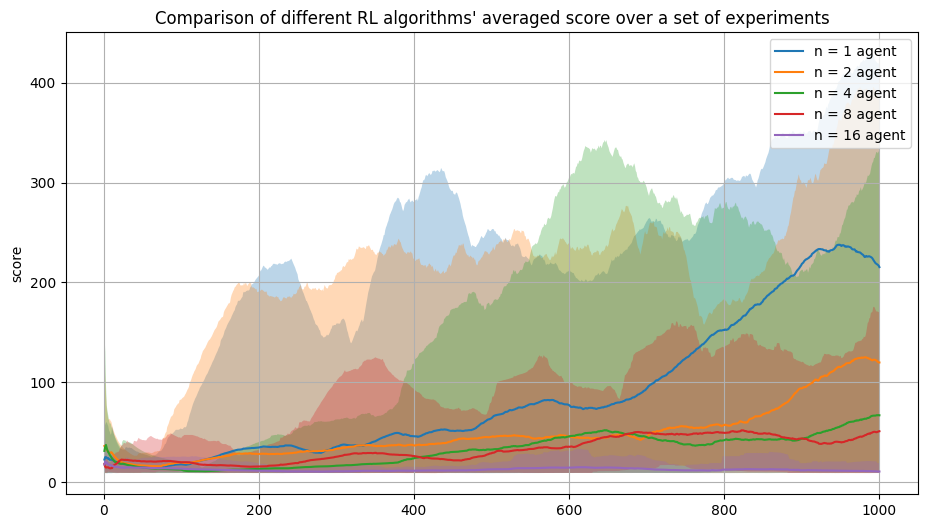

In [22]:
compare_results(results_data_dict, idx=0)

It can be observed that larger values of $n$ present increased training difficulty. Nonetheless, it must be borne in mind that we select the optimal learning rate specifically for $n=1$. Therefore, it is not unexpected that the best outcomes arise for this configuration. As per Chapter 7.3 in [1], distinct values of $n$ correspond to unique optimal learning rate values. Hence, we shall endeavor to vary the learning rate and assess the outcomes.

In [26]:
# make the environment
env_name = "CartPole-v1"
env = gym.make(env_name)

# set the hyperparameters for the agent
N_EXPERIMENTS = 10
N_EPISODES = 1000
MAX_STEPS = 500
GAMMA = 0.99
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.2)
OBSERVATION_DIM = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n
ACTION_DIM = 1
MEMORY_SIZE = 100000
BATCH_SIZE = 8


# set the number of steps to use in the n-steps algorithm
n_list = [1, 2, 4, 8, 16]

# set the learning rate
lr_list = np.logspace(-2, -7, num=10, base=10)

# set experiments results array
final_results = np.zeros((len(lr_list), len(n_list)))
results_data_dict = {}


# run experiments for different n-step values
for i, lr in enumerate(lr_list):
    for j, n in enumerate(n_list):
        print(f"\nInitializing a new experiment of Off-policy n-step Expected SARSA with n = {str(n)} and lr = {str(lr)}...")

        # initialize the agent
        agent = NStepExpectedSarsaAgentWithBuffer(observation_dim=OBSERVATION_DIM, 
                                                  n_actions=N_ACTIONS,
                                                  learning_rate=lr, 
                                                  gamma=GAMMA, 
                                                  epsilon=EPSILON, 
                                                  epsilon_dec=EPSILON_DEC,
                                                  epsilon_min=EPSILON_MIN,  
                                                  memory_size=MEMORY_SIZE,
                                                  n=n)

        # run single experiment
        avg_scores, std_scores = run_loop(env_name=env_name, 
                                          agent=agent, 
                                          n_experiments=N_EXPERIMENTS, 
                                          n_episodes=N_EPISODES, 
                                          max_steps=MAX_STEPS)

        # save experiment's data for later comparison
        results_data_dict[(i, j)] = avg_scores, std_scores
        final_results[i, j] = np.max(avg_scores)


Initializing a new experiment of Off-policy n-step Expected SARSA with n = 1 and lr = 0.01...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 19.0 | Avg score: 19.0 |
| Experiment:    1 | Episode:   10 | Score:  8.0 | Avg score: 16.2 |
| Experiment:    1 | Episode:   20 | Score: 19.0 | Avg score: 16.3 |
| Experiment:    1 | Episode:   30 | Score: 40.0 | Avg score: 20.8 |
| Experiment:    1 | Episode:   40 | Score: 23.0 | Avg score: 23.7 |
| Experiment:    1 | Episode:   50 | Score: 126.0 | Avg score: 32.7 |
| Experiment:    1 | Episode:   60 | Score: 11.0 | Avg score: 30.9 |
| Experiment:    1 | Episode:   70 | Score: 105.0 | Avg score: 35.7 |
| Experiment:    1 | Episode:   80 | Score: 57.0 | Avg score: 39.0 |
| Experiment:    1 | Episode:   90 | Score: 18.0 | Avg score: 36.3 |
| Experiment:    1 | Episode:  100 | Score: 106.0 | Avg score: 38.4 |
| Experiment:    1 | Episode:  110 | Score: 17.0 | Avg score: 41.5 |
| Ex

| Experiment:    2 | Episode:  170 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  180 | Score: 10.0 | Avg score:  9.1 |
| Experiment:    2 | Episode:  190 | Score:  9.0 | Avg score:  9.1 |
| Experiment:    2 | Episode:  200 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  210 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  220 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  230 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  240 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  250 | Score: 14.0 | Avg score:  9.6 |
| Experiment:    2 | Episode:  260 | Score: 51.0 | Avg score: 12.1 |
| Experiment:    2 | Episode:  270 | Score: 76.0 | Avg score: 18.0 |
| Experiment:    2 | Episode:  280 | Score: 166.0 | Avg score: 23.8 |
| Experiment:    2 | Episode:  290 | Score: 52.0 | Avg score: 30.2 |
| Experiment:    2 | Episode:  300 | Score: 66.0 | Avg score: 34.4 |
| Experiment:    2 | Episode:  31

| Experiment:    3 | Episode:  390 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  400 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  410 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  420 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  430 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  440 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  450 | Score: 26.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:  460 | Score: 32.0 | Avg score: 12.1 |
| Experiment:    3 | Episode:  470 | Score: 12.0 | Avg score: 13.3 |
| Experiment:    3 | Episode:  480 | Score: 12.0 | Avg score: 13.7 |
| Experiment:    3 | Episode:  490 | Score: 10.0 | Avg score: 13.8 |
| Experiment:    3 | Episode:  500 | Score:  9.0 | Avg score: 13.8 |
| Experiment:    3 | Episode:  510 | Score: 11.0 | Avg score: 14.0 |
| Experiment:    3 | Episode:  520 | Score: 11.0 | Avg score: 14.0 |
| Experiment:    3 | Episode:  530

| Experiment:    4 | Episode:  600 | Score: 10.0 | Avg score: 12.4 |
| Experiment:    4 | Episode:  610 | Score: 20.0 | Avg score: 12.5 |
| Experiment:    4 | Episode:  620 | Score: 11.0 | Avg score: 12.5 |
| Experiment:    4 | Episode:  630 | Score: 14.0 | Avg score: 12.4 |
| Experiment:    4 | Episode:  640 | Score: 12.0 | Avg score: 12.5 |
| Experiment:    4 | Episode:  650 | Score: 11.0 | Avg score: 12.6 |
| Experiment:    4 | Episode:  660 | Score: 10.0 | Avg score: 13.1 |
| Experiment:    4 | Episode:  670 | Score:  9.0 | Avg score: 12.7 |
| Experiment:    4 | Episode:  680 | Score: 46.0 | Avg score: 15.1 |
| Experiment:    4 | Episode:  690 | Score: 50.0 | Avg score: 15.5 |
| Experiment:    4 | Episode:  700 | Score: 71.0 | Avg score: 18.0 |
| Experiment:    4 | Episode:  710 | Score: 64.0 | Avg score: 28.7 |
| Experiment:    4 | Episode:  720 | Score: 110.0 | Avg score: 32.5 |
| Experiment:    4 | Episode:  730 | Score: 98.0 | Avg score: 37.2 |
| Experiment:    4 | Episode:  74

| Experiment:    5 | Episode:  790 | Score: 15.0 | Avg score: 14.2 |
| Experiment:    5 | Episode:  800 | Score: 18.0 | Avg score: 14.2 |
| Experiment:    5 | Episode:  810 | Score: 18.0 | Avg score: 14.3 |
| Experiment:    5 | Episode:  820 | Score:  9.0 | Avg score: 14.6 |
| Experiment:    5 | Episode:  830 | Score: 23.0 | Avg score: 14.6 |
| Experiment:    5 | Episode:  840 | Score: 23.0 | Avg score: 15.2 |
| Experiment:    5 | Episode:  850 | Score: 27.0 | Avg score: 15.4 |
| Experiment:    5 | Episode:  860 | Score: 11.0 | Avg score: 15.4 |
| Experiment:    5 | Episode:  870 | Score:  9.0 | Avg score: 15.0 |
| Experiment:    5 | Episode:  880 | Score: 10.0 | Avg score: 14.5 |
| Experiment:    5 | Episode:  890 | Score:  9.0 | Avg score: 13.9 |
| Experiment:    5 | Episode:  900 | Score: 43.0 | Avg score: 14.7 |
| Experiment:    5 | Episode:  910 | Score: 24.0 | Avg score: 15.3 |
| Experiment:    5 | Episode:  920 | Score: 17.0 | Avg score: 15.8 |
| Experiment:    5 | Episode:  930

| Experiment:    6 | Episode:  980 | Score: 67.0 | Avg score: 41.1 |
| Experiment:    6 | Episode:  990 | Score: 84.0 | Avg score: 46.4 |
agent full reset...
reset buffer...
| Experiment:    7 | Episode:    0 | Score: 16.0 | Avg score: 16.0 |
| Experiment:    7 | Episode:   10 | Score: 11.0 | Avg score: 22.6 |
| Experiment:    7 | Episode:   20 | Score:  8.0 | Avg score: 16.3 |
| Experiment:    7 | Episode:   30 | Score: 11.0 | Avg score: 14.3 |
| Experiment:    7 | Episode:   40 | Score:  8.0 | Avg score: 13.3 |
| Experiment:    7 | Episode:   50 | Score:  9.0 | Avg score: 12.6 |
| Experiment:    7 | Episode:   60 | Score: 10.0 | Avg score: 12.1 |
| Experiment:    7 | Episode:   70 | Score: 10.0 | Avg score: 11.8 |
| Experiment:    7 | Episode:   80 | Score: 10.0 | Avg score: 11.5 |
| Experiment:    7 | Episode:   90 | Score:  9.0 | Avg score: 11.3 |
| Experiment:    7 | Episode:  100 | Score: 10.0 | Avg score: 11.1 |
| Experiment:    7 | Episode:  110 | Score:  9.0 | Avg score:  9.8 

| Experiment:    8 | Episode:  190 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  200 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  210 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  220 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  230 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  240 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  250 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  260 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  270 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  280 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  290 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  300 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  310 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  320 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  330

| Experiment:    9 | Episode:  400 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    9 | Episode:  410 | Score: 40.0 | Avg score: 11.1 |
| Experiment:    9 | Episode:  420 | Score: 10.0 | Avg score: 11.4 |
| Experiment:    9 | Episode:  430 | Score: 30.0 | Avg score: 12.9 |
| Experiment:    9 | Episode:  440 | Score: 10.0 | Avg score: 13.5 |
| Experiment:    9 | Episode:  450 | Score: 10.0 | Avg score: 14.3 |
| Experiment:    9 | Episode:  460 | Score: 10.0 | Avg score: 15.1 |
| Experiment:    9 | Episode:  470 | Score: 10.0 | Avg score: 15.8 |
| Experiment:    9 | Episode:  480 | Score: 30.0 | Avg score: 16.6 |
| Experiment:    9 | Episode:  490 | Score:  8.0 | Avg score: 17.4 |
| Experiment:    9 | Episode:  500 | Score:  9.0 | Avg score: 17.4 |
| Experiment:    9 | Episode:  510 | Score: 27.0 | Avg score: 17.2 |
| Experiment:    9 | Episode:  520 | Score: 10.0 | Avg score: 17.6 |
| Experiment:    9 | Episode:  530 | Score:  8.0 | Avg score: 16.1 |
| Experiment:    9 | Episode:  540

| Experiment:   10 | Episode:  620 | Score: 11.0 | Avg score: 11.4 |
| Experiment:   10 | Episode:  630 | Score: 16.0 | Avg score: 11.6 |
| Experiment:   10 | Episode:  640 | Score:  9.0 | Avg score: 11.3 |
| Experiment:   10 | Episode:  650 | Score: 31.0 | Avg score: 13.7 |
| Experiment:   10 | Episode:  660 | Score: 436.0 | Avg score: 20.6 |
| Experiment:   10 | Episode:  670 | Score: 198.0 | Avg score: 27.5 |
| Experiment:   10 | Episode:  680 | Score: 411.0 | Avg score: 40.5 |
| Experiment:   10 | Episode:  690 | Score: 500.0 | Avg score: 68.6 |
| Experiment:   10 | Episode:  700 | Score: 500.0 | Avg score: 99.8 |
| Experiment:   10 | Episode:  710 | Score: 135.0 | Avg score: 123.5 |
| Experiment:   10 | Episode:  720 | Score: 426.0 | Avg score: 149.0 |
| Experiment:   10 | Episode:  730 | Score: 29.0 | Avg score: 166.2 |
| Experiment:   10 | Episode:  740 | Score: 23.0 | Avg score: 184.1 |
| Experiment:   10 | Episode:  750 | Score: 35.0 | Avg score: 207.6 |
| Experiment:   10 | E

| Experiment:    1 | Episode:  780 | Score:  8.0 | Avg score: 12.5 |
| Experiment:    1 | Episode:  790 | Score: 106.0 | Avg score: 14.1 |
| Experiment:    1 | Episode:  800 | Score: 72.0 | Avg score: 18.7 |
| Experiment:    1 | Episode:  810 | Score: 95.0 | Avg score: 23.4 |
| Experiment:    1 | Episode:  820 | Score: 98.0 | Avg score: 31.9 |
| Experiment:    1 | Episode:  830 | Score: 35.0 | Avg score: 35.3 |
| Experiment:    1 | Episode:  840 | Score: 73.0 | Avg score: 43.2 |
| Experiment:    1 | Episode:  850 | Score: 79.0 | Avg score: 49.7 |
| Experiment:    1 | Episode:  860 | Score: 185.0 | Avg score: 54.4 |
| Experiment:    1 | Episode:  870 | Score: 129.0 | Avg score: 61.5 |
| Experiment:    1 | Episode:  880 | Score: 14.0 | Avg score: 64.2 |
| Experiment:    1 | Episode:  890 | Score: 67.0 | Avg score: 65.9 |
| Experiment:    1 | Episode:  900 | Score: 53.0 | Avg score: 65.6 |
| Experiment:    1 | Episode:  910 | Score: 64.0 | Avg score: 65.3 |
| Experiment:    1 | Episode:  

| Experiment:    2 | Episode:  950 | Score: 500.0 | Avg score: 110.0 |
buffer is full...
| Experiment:    2 | Episode:  960 | Score: 108.0 | Avg score: 129.8 |
| Experiment:    2 | Episode:  970 | Score: 226.0 | Avg score: 139.7 |
| Experiment:    2 | Episode:  980 | Score: 175.0 | Avg score: 154.7 |
| Experiment:    2 | Episode:  990 | Score: 309.0 | Avg score: 169.9 |
agent full reset...
reset buffer...
| Experiment:    3 | Episode:    0 | Score: 12.0 | Avg score: 12.0 |
| Experiment:    3 | Episode:   10 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    3 | Episode:   20 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    3 | Episode:   30 | Score: 11.0 | Avg score:  9.7 |
| Experiment:    3 | Episode:   40 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   50 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   60 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:   70 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   80 | Sc

| Experiment:    4 | Episode:  160 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  170 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  180 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  190 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  200 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:  210 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  220 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  230 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  240 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  250 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  260 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  270 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  280 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  290 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  300

| Experiment:    5 | Episode:  350 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  360 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  370 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  380 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  390 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  400 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  410 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  420 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  430 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  440 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  450 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  460 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  470 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  480 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  490

| Experiment:    6 | Episode:  550 | Score: 39.0 | Avg score: 32.8 |
| Experiment:    6 | Episode:  560 | Score: 76.0 | Avg score: 38.0 |
| Experiment:    6 | Episode:  570 | Score: 52.0 | Avg score: 41.2 |
| Experiment:    6 | Episode:  580 | Score: 39.0 | Avg score: 43.0 |
| Experiment:    6 | Episode:  590 | Score: 22.0 | Avg score: 38.7 |
| Experiment:    6 | Episode:  600 | Score: 29.0 | Avg score: 37.1 |
| Experiment:    6 | Episode:  610 | Score: 13.0 | Avg score: 37.6 |
| Experiment:    6 | Episode:  620 | Score: 25.0 | Avg score: 37.1 |
| Experiment:    6 | Episode:  630 | Score: 19.0 | Avg score: 33.2 |
| Experiment:    6 | Episode:  640 | Score:  9.0 | Avg score: 32.5 |
| Experiment:    6 | Episode:  650 | Score: 10.0 | Avg score: 28.7 |
| Experiment:    6 | Episode:  660 | Score: 10.0 | Avg score: 23.9 |
| Experiment:    6 | Episode:  670 | Score: 15.0 | Avg score: 20.7 |
| Experiment:    6 | Episode:  680 | Score:  9.0 | Avg score: 18.4 |
| Experiment:    6 | Episode:  690

| Experiment:    7 | Episode:  760 | Score: 101.0 | Avg score: 11.2 |
| Experiment:    7 | Episode:  770 | Score: 16.0 | Avg score: 11.9 |
| Experiment:    7 | Episode:  780 | Score: 13.0 | Avg score: 12.1 |
| Experiment:    7 | Episode:  790 | Score: 13.0 | Avg score: 13.0 |
| Experiment:    7 | Episode:  800 | Score: 16.0 | Avg score: 13.8 |
| Experiment:    7 | Episode:  810 | Score: 12.0 | Avg score: 14.2 |
| Experiment:    7 | Episode:  820 | Score: 10.0 | Avg score: 14.4 |
| Experiment:    7 | Episode:  830 | Score: 10.0 | Avg score: 15.3 |
| Experiment:    7 | Episode:  840 | Score: 10.0 | Avg score: 15.1 |
| Experiment:    7 | Episode:  850 | Score:  9.0 | Avg score: 15.3 |
| Experiment:    7 | Episode:  860 | Score: 10.0 | Avg score: 15.1 |
| Experiment:    7 | Episode:  870 | Score: 14.0 | Avg score: 14.8 |
| Experiment:    7 | Episode:  880 | Score: 51.0 | Avg score: 15.3 |
| Experiment:    7 | Episode:  890 | Score: 11.0 | Avg score: 15.1 |
| Experiment:    7 | Episode:  90

| Experiment:    8 | Episode:  950 | Score: 27.0 | Avg score: 39.9 |
| Experiment:    8 | Episode:  960 | Score: 47.0 | Avg score: 42.9 |
| Experiment:    8 | Episode:  970 | Score: 69.0 | Avg score: 43.9 |
| Experiment:    8 | Episode:  980 | Score: 19.0 | Avg score: 43.1 |
| Experiment:    8 | Episode:  990 | Score: 120.0 | Avg score: 42.3 |
agent full reset...
reset buffer...
| Experiment:    9 | Episode:    0 | Score: 11.0 | Avg score: 11.0 |
| Experiment:    9 | Episode:   10 | Score: 11.0 | Avg score:  9.9 |
| Experiment:    9 | Episode:   20 | Score: 10.0 | Avg score: 10.4 |
| Experiment:    9 | Episode:   30 | Score: 12.0 | Avg score: 10.4 |
| Experiment:    9 | Episode:   40 | Score:  9.0 | Avg score: 10.2 |
| Experiment:    9 | Episode:   50 | Score: 19.0 | Avg score: 10.2 |
| Experiment:    9 | Episode:   60 | Score:  8.0 | Avg score: 10.0 |
| Experiment:    9 | Episode:   70 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    9 | Episode:   80 | Score: 15.0 | Avg score:  9.9

| Experiment:   10 | Episode:  160 | Score:  8.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  170 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  180 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  190 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  200 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  210 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  220 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  230 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  240 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  250 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  260 | Score:  8.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  270 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  280 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  290 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  300

| Experiment:    1 | Episode:  330 | Score: 137.0 | Avg score: 33.0 |
| Experiment:    1 | Episode:  340 | Score: 93.0 | Avg score: 37.5 |
| Experiment:    1 | Episode:  350 | Score: 110.0 | Avg score: 47.9 |
| Experiment:    1 | Episode:  360 | Score: 135.0 | Avg score: 62.0 |
| Experiment:    1 | Episode:  370 | Score: 124.0 | Avg score: 69.3 |
| Experiment:    1 | Episode:  380 | Score: 76.0 | Avg score: 74.6 |
| Experiment:    1 | Episode:  390 | Score: 10.0 | Avg score: 81.1 |
| Experiment:    1 | Episode:  400 | Score: 10.0 | Avg score: 78.3 |
| Experiment:    1 | Episode:  410 | Score: 13.0 | Avg score: 78.3 |
| Experiment:    1 | Episode:  420 | Score: 59.0 | Avg score: 81.2 |
| Experiment:    1 | Episode:  430 | Score: 131.0 | Avg score: 78.0 |
| Experiment:    1 | Episode:  440 | Score:  8.0 | Avg score: 77.5 |
| Experiment:    1 | Episode:  450 | Score:  9.0 | Avg score: 67.3 |
| Experiment:    1 | Episode:  460 | Score: 10.0 | Avg score: 53.3 |
| Experiment:    1 | Episode:

| Experiment:    2 | Episode:  510 | Score: 137.0 | Avg score: 60.5 |
| Experiment:    2 | Episode:  520 | Score: 106.0 | Avg score: 63.8 |
| Experiment:    2 | Episode:  530 | Score: 10.0 | Avg score: 64.5 |
| Experiment:    2 | Episode:  540 | Score: 12.0 | Avg score: 61.5 |
| Experiment:    2 | Episode:  550 | Score: 61.0 | Avg score: 55.6 |
| Experiment:    2 | Episode:  560 | Score: 123.0 | Avg score: 56.4 |
| Experiment:    2 | Episode:  570 | Score: 53.0 | Avg score: 54.3 |
| Experiment:    2 | Episode:  580 | Score: 13.0 | Avg score: 52.7 |
| Experiment:    2 | Episode:  590 | Score: 29.0 | Avg score: 52.4 |
| Experiment:    2 | Episode:  600 | Score: 30.0 | Avg score: 52.1 |
| Experiment:    2 | Episode:  610 | Score: 46.0 | Avg score: 52.1 |
| Experiment:    2 | Episode:  620 | Score: 23.0 | Avg score: 48.7 |
| Experiment:    2 | Episode:  630 | Score: 12.0 | Avg score: 50.8 |
| Experiment:    2 | Episode:  640 | Score: 30.0 | Avg score: 53.2 |
| Experiment:    2 | Episode:  

| Experiment:    3 | Episode:  690 | Score: 163.0 | Avg score: 65.7 |
| Experiment:    3 | Episode:  700 | Score: 58.0 | Avg score: 71.2 |
| Experiment:    3 | Episode:  710 | Score: 98.0 | Avg score: 76.9 |
| Experiment:    3 | Episode:  720 | Score: 41.0 | Avg score: 80.3 |
| Experiment:    3 | Episode:  730 | Score: 86.0 | Avg score: 84.0 |
| Experiment:    3 | Episode:  740 | Score: 79.0 | Avg score: 87.2 |
| Experiment:    3 | Episode:  750 | Score: 63.0 | Avg score: 90.3 |
| Experiment:    3 | Episode:  760 | Score: 103.0 | Avg score: 96.8 |
| Experiment:    3 | Episode:  770 | Score: 73.0 | Avg score: 94.6 |
| Experiment:    3 | Episode:  780 | Score: 101.0 | Avg score: 81.2 |
| Experiment:    3 | Episode:  790 | Score: 136.0 | Avg score: 75.7 |
| Experiment:    3 | Episode:  800 | Score: 131.0 | Avg score: 79.0 |
| Experiment:    3 | Episode:  810 | Score: 96.0 | Avg score: 90.8 |
| Experiment:    3 | Episode:  820 | Score: 106.0 | Avg score: 96.9 |
| Experiment:    3 | Episode

| Experiment:    4 | Episode:  870 | Score: 12.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:  880 | Score: 15.0 | Avg score: 10.5 |
| Experiment:    4 | Episode:  890 | Score: 27.0 | Avg score: 12.6 |
| Experiment:    4 | Episode:  900 | Score: 50.0 | Avg score: 17.8 |
| Experiment:    4 | Episode:  910 | Score: 80.0 | Avg score: 26.6 |
| Experiment:    4 | Episode:  920 | Score: 100.0 | Avg score: 33.4 |
| Experiment:    4 | Episode:  930 | Score: 57.0 | Avg score: 38.8 |
| Experiment:    4 | Episode:  940 | Score:  8.0 | Avg score: 42.1 |
| Experiment:    4 | Episode:  950 | Score:  9.0 | Avg score: 42.8 |
| Experiment:    4 | Episode:  960 | Score: 46.0 | Avg score: 43.1 |
| Experiment:    4 | Episode:  970 | Score:  9.0 | Avg score: 43.8 |
| Experiment:    4 | Episode:  980 | Score:  8.0 | Avg score: 43.0 |
| Experiment:    4 | Episode:  990 | Score:  9.0 | Avg score: 40.8 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score: 12.0 | Avg score: 12.0

| Experiment:    6 | Episode:   50 | Score: 85.0 | Avg score: 21.3 |
| Experiment:    6 | Episode:   60 | Score:  9.0 | Avg score: 23.7 |
| Experiment:    6 | Episode:   70 | Score:  9.0 | Avg score: 23.9 |
| Experiment:    6 | Episode:   80 | Score:  9.0 | Avg score: 22.2 |
| Experiment:    6 | Episode:   90 | Score:  9.0 | Avg score: 20.8 |
| Experiment:    6 | Episode:  100 | Score: 10.0 | Avg score: 19.7 |
| Experiment:    6 | Episode:  110 | Score: 13.0 | Avg score: 19.8 |
| Experiment:    6 | Episode:  120 | Score: 23.0 | Avg score: 19.9 |
| Experiment:    6 | Episode:  130 | Score: 18.0 | Avg score: 20.4 |
| Experiment:    6 | Episode:  140 | Score: 102.0 | Avg score: 23.3 |
| Experiment:    6 | Episode:  150 | Score: 35.0 | Avg score: 26.1 |
| Experiment:    6 | Episode:  160 | Score: 87.0 | Avg score: 33.8 |
| Experiment:    6 | Episode:  170 | Score: 124.0 | Avg score: 43.3 |
| Experiment:    6 | Episode:  180 | Score: 85.0 | Avg score: 52.4 |
| Experiment:    6 | Episode:  1

| Experiment:    7 | Episode:  230 | Score: 23.0 | Avg score: 109.1 |
| Experiment:    7 | Episode:  240 | Score: 10.0 | Avg score: 105.1 |
| Experiment:    7 | Episode:  250 | Score: 10.0 | Avg score: 91.9 |
| Experiment:    7 | Episode:  260 | Score: 10.0 | Avg score: 79.9 |
| Experiment:    7 | Episode:  270 | Score:  8.0 | Avg score: 75.0 |
| Experiment:    7 | Episode:  280 | Score:  9.0 | Avg score: 65.2 |
| Experiment:    7 | Episode:  290 | Score:  9.0 | Avg score: 57.3 |
| Experiment:    7 | Episode:  300 | Score: 10.0 | Avg score: 55.1 |
| Experiment:    7 | Episode:  310 | Score: 10.0 | Avg score: 48.4 |
| Experiment:    7 | Episode:  320 | Score:  9.0 | Avg score: 34.2 |
| Experiment:    7 | Episode:  330 | Score:  8.0 | Avg score: 21.6 |
| Experiment:    7 | Episode:  340 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    7 | Episode:  350 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  360 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    7 | Episode:  3

| Experiment:    8 | Episode:  420 | Score: 99.0 | Avg score: 78.4 |
| Experiment:    8 | Episode:  430 | Score: 105.0 | Avg score: 75.8 |
| Experiment:    8 | Episode:  440 | Score: 481.0 | Avg score: 76.4 |
| Experiment:    8 | Episode:  450 | Score: 20.0 | Avg score: 73.9 |
| Experiment:    8 | Episode:  460 | Score: 19.0 | Avg score: 70.6 |
| Experiment:    8 | Episode:  470 | Score:  9.0 | Avg score: 59.9 |
| Experiment:    8 | Episode:  480 | Score: 10.0 | Avg score: 59.5 |
| Experiment:    8 | Episode:  490 | Score:  8.0 | Avg score: 58.6 |
| Experiment:    8 | Episode:  500 | Score: 10.0 | Avg score: 58.0 |
| Experiment:    8 | Episode:  510 | Score: 10.0 | Avg score: 57.9 |
| Experiment:    8 | Episode:  520 | Score: 50.0 | Avg score: 56.9 |
| Experiment:    8 | Episode:  530 | Score: 99.0 | Avg score: 59.0 |
| Experiment:    8 | Episode:  540 | Score: 76.0 | Avg score: 50.2 |
| Experiment:    8 | Episode:  550 | Score: 180.0 | Avg score: 48.9 |
| Experiment:    8 | Episode:  

| Experiment:    9 | Episode:  610 | Score:  9.0 | Avg score: 29.1 |
| Experiment:    9 | Episode:  620 | Score:  8.0 | Avg score: 13.0 |
| Experiment:    9 | Episode:  630 | Score:  8.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  640 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  650 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    9 | Episode:  660 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    9 | Episode:  670 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    9 | Episode:  680 | Score:  8.0 | Avg score:  9.9 |
| Experiment:    9 | Episode:  690 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    9 | Episode:  700 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    9 | Episode:  710 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    9 | Episode:  720 | Score: 10.0 | Avg score: 10.4 |
| Experiment:    9 | Episode:  730 | Score: 52.0 | Avg score: 11.8 |
| Experiment:    9 | Episode:  740 | Score: 73.0 | Avg score: 22.4 |
| Experiment:    9 | Episode:  750

| Experiment:   10 | Episode:  790 | Score: 89.0 | Avg score: 107.0 |
| Experiment:   10 | Episode:  800 | Score: 21.0 | Avg score: 104.0 |
| Experiment:   10 | Episode:  810 | Score: 65.0 | Avg score: 107.0 |
| Experiment:   10 | Episode:  820 | Score: 137.0 | Avg score: 108.5 |
| Experiment:   10 | Episode:  830 | Score: 193.0 | Avg score: 109.4 |
| Experiment:   10 | Episode:  840 | Score: 60.0 | Avg score: 106.8 |
| Experiment:   10 | Episode:  850 | Score: 56.0 | Avg score: 104.5 |
| Experiment:   10 | Episode:  860 | Score: 10.0 | Avg score: 105.5 |
| Experiment:   10 | Episode:  870 | Score:  8.0 | Avg score: 92.8 |
| Experiment:   10 | Episode:  880 | Score:  9.0 | Avg score: 88.4 |
| Experiment:   10 | Episode:  890 | Score:  9.0 | Avg score: 77.8 |
| Experiment:   10 | Episode:  900 | Score: 10.0 | Avg score: 69.5 |
| Experiment:   10 | Episode:  910 | Score: 10.0 | Avg score: 60.1 |
| Experiment:   10 | Episode:  920 | Score: 10.0 | Avg score: 49.4 |
| Experiment:   10 | Epi

| Experiment:    1 | Episode:  990 | Score: 10.0 | Avg score:  9.2 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    2 | Episode:   10 | Score:  9.0 | Avg score: 12.6 |
| Experiment:    2 | Episode:   20 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    2 | Episode:   30 | Score: 19.0 | Avg score: 12.4 |
| Experiment:    2 | Episode:   40 | Score: 11.0 | Avg score: 13.2 |
| Experiment:    2 | Episode:   50 | Score: 10.0 | Avg score: 13.7 |
| Experiment:    2 | Episode:   60 | Score:  9.0 | Avg score: 13.1 |
| Experiment:    2 | Episode:   70 | Score:  9.0 | Avg score: 12.7 |
| Experiment:    2 | Episode:   80 | Score:  9.0 | Avg score: 12.3 |
| Experiment:    2 | Episode:   90 | Score: 10.0 | Avg score: 12.2 |
| Experiment:    2 | Episode:  100 | Score: 15.0 | Avg score: 12.1 |
| Experiment:    2 | Episode:  110 | Score: 10.0 | Avg score: 11.8 |
| Experiment:    2 | Episode:  120 | Score:  9.0 | Avg score: 11.7 

| Experiment:    3 | Episode:  200 | Score:  9.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  210 | Score:  9.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  220 | Score:  8.0 | Avg score: 10.5 |
| Experiment:    3 | Episode:  230 | Score:  9.0 | Avg score: 10.5 |
| Experiment:    3 | Episode:  240 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:  250 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:  260 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    3 | Episode:  270 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    3 | Episode:  280 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  290 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  300 | Score: 17.0 | Avg score:  9.8 |
| Experiment:    3 | Episode:  310 | Score: 15.0 | Avg score: 10.0 |
| Experiment:    3 | Episode:  320 | Score: 11.0 | Avg score: 11.0 |
| Experiment:    3 | Episode:  330 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    3 | Episode:  340

| Experiment:    4 | Episode:  420 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  430 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  440 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  450 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  460 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  470 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  480 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  490 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  500 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  510 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  520 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  530 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  540 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  550 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  560

| Experiment:    5 | Episode:  610 | Score: 19.0 | Avg score: 23.5 |
| Experiment:    5 | Episode:  620 | Score: 22.0 | Avg score: 23.9 |
| Experiment:    5 | Episode:  630 | Score: 25.0 | Avg score: 24.0 |
| Experiment:    5 | Episode:  640 | Score: 22.0 | Avg score: 24.2 |
| Experiment:    5 | Episode:  650 | Score: 21.0 | Avg score: 24.0 |
| Experiment:    5 | Episode:  660 | Score: 24.0 | Avg score: 23.7 |
| Experiment:    5 | Episode:  670 | Score: 22.0 | Avg score: 23.6 |
| Experiment:    5 | Episode:  680 | Score: 30.0 | Avg score: 23.7 |
| Experiment:    5 | Episode:  690 | Score: 24.0 | Avg score: 23.9 |
| Experiment:    5 | Episode:  700 | Score: 23.0 | Avg score: 24.2 |
| Experiment:    5 | Episode:  710 | Score: 30.0 | Avg score: 24.1 |
| Experiment:    5 | Episode:  720 | Score: 24.0 | Avg score: 24.1 |
| Experiment:    5 | Episode:  730 | Score: 26.0 | Avg score: 24.2 |
| Experiment:    5 | Episode:  740 | Score: 21.0 | Avg score: 24.1 |
| Experiment:    5 | Episode:  750

| Experiment:    6 | Episode:  800 | Score: 42.0 | Avg score: 57.5 |
| Experiment:    6 | Episode:  810 | Score: 240.0 | Avg score: 63.9 |
| Experiment:    6 | Episode:  820 | Score: 12.0 | Avg score: 73.7 |
| Experiment:    6 | Episode:  830 | Score: 10.0 | Avg score: 73.2 |
| Experiment:    6 | Episode:  840 | Score: 10.0 | Avg score: 69.3 |
| Experiment:    6 | Episode:  850 | Score:  9.0 | Avg score: 61.9 |
| Experiment:    6 | Episode:  860 | Score:  9.0 | Avg score: 58.8 |
| Experiment:    6 | Episode:  870 | Score: 10.0 | Avg score: 52.0 |
| Experiment:    6 | Episode:  880 | Score: 10.0 | Avg score: 45.7 |
| Experiment:    6 | Episode:  890 | Score:  9.0 | Avg score: 35.8 |
| Experiment:    6 | Episode:  900 | Score:  9.0 | Avg score: 29.9 |
| Experiment:    6 | Episode:  910 | Score: 10.0 | Avg score: 21.9 |
| Experiment:    6 | Episode:  920 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    6 | Episode:  930 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  94

| Experiment:    7 | Episode:  990 | Score: 59.0 | Avg score: 36.1 |
agent full reset...
reset buffer...
| Experiment:    8 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:   10 | Score: 10.0 | Avg score: 13.6 |
| Experiment:    8 | Episode:   20 | Score: 10.0 | Avg score: 14.3 |
| Experiment:    8 | Episode:   30 | Score: 20.0 | Avg score: 19.2 |
| Experiment:    8 | Episode:   40 | Score: 24.0 | Avg score: 21.4 |
| Experiment:    8 | Episode:   50 | Score: 29.0 | Avg score: 25.6 |
| Experiment:    8 | Episode:   60 | Score: 58.0 | Avg score: 31.0 |
| Experiment:    8 | Episode:   70 | Score: 35.0 | Avg score: 34.5 |
| Experiment:    8 | Episode:   80 | Score: 72.0 | Avg score: 35.0 |
| Experiment:    8 | Episode:   90 | Score: 10.0 | Avg score: 32.4 |
| Experiment:    8 | Episode:  100 | Score: 10.0 | Avg score: 30.5 |
| Experiment:    8 | Episode:  110 | Score: 10.0 | Avg score: 30.1 |
| Experiment:    8 | Episode:  120 | Score: 43.0 | Avg score: 30.8 

| Experiment:    9 | Episode:  170 | Score:  8.0 | Avg score: 14.5 |
| Experiment:    9 | Episode:  180 | Score:  9.0 | Avg score: 14.2 |
| Experiment:    9 | Episode:  190 | Score: 19.0 | Avg score: 14.6 |
| Experiment:    9 | Episode:  200 | Score: 12.0 | Avg score: 13.8 |
| Experiment:    9 | Episode:  210 | Score: 10.0 | Avg score: 13.8 |
| Experiment:    9 | Episode:  220 | Score: 17.0 | Avg score: 13.4 |
| Experiment:    9 | Episode:  230 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    9 | Episode:  240 | Score: 25.0 | Avg score: 11.8 |
| Experiment:    9 | Episode:  250 | Score: 10.0 | Avg score: 12.6 |
| Experiment:    9 | Episode:  260 | Score:  9.0 | Avg score: 13.1 |
| Experiment:    9 | Episode:  270 | Score: 23.0 | Avg score: 14.6 |
| Experiment:    9 | Episode:  280 | Score: 27.0 | Avg score: 17.9 |
| Experiment:    9 | Episode:  290 | Score: 27.0 | Avg score: 18.7 |
| Experiment:    9 | Episode:  300 | Score: 12.0 | Avg score: 21.4 |
| Experiment:    9 | Episode:  310

| Experiment:   10 | Episode:  380 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  390 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  400 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  410 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  420 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  430 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  440 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  450 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  460 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  470 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  480 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  490 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  500 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  510 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  520

| Experiment:    1 | Episode:  550 | Score: 500.0 | Avg score: 227.7 |
| Experiment:    1 | Episode:  560 | Score: 21.0 | Avg score: 184.8 |
| Experiment:    1 | Episode:  570 | Score: 11.0 | Avg score: 160.5 |
| Experiment:    1 | Episode:  580 | Score: 10.0 | Avg score: 135.6 |
| Experiment:    1 | Episode:  590 | Score: 10.0 | Avg score: 120.2 |
| Experiment:    1 | Episode:  600 | Score: 22.0 | Avg score: 86.4 |
| Experiment:    1 | Episode:  610 | Score: 22.0 | Avg score: 61.7 |
| Experiment:    1 | Episode:  620 | Score: 11.0 | Avg score: 56.6 |
| Experiment:    1 | Episode:  630 | Score: 25.0 | Avg score: 46.5 |
| Experiment:    1 | Episode:  640 | Score: 25.0 | Avg score: 45.6 |
| Experiment:    1 | Episode:  650 | Score: 11.0 | Avg score: 35.9 |
| Experiment:    1 | Episode:  660 | Score: 25.0 | Avg score: 35.4 |
| Experiment:    1 | Episode:  670 | Score: 11.0 | Avg score: 26.2 |
| Experiment:    1 | Episode:  680 | Score: 10.0 | Avg score: 25.8 |
| Experiment:    1 | Episode

| Experiment:    2 | Episode:  740 | Score: 10.0 | Avg score: 10.4 |
| Experiment:    2 | Episode:  750 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    2 | Episode:  760 | Score: 10.0 | Avg score: 10.6 |
| Experiment:    2 | Episode:  770 | Score:  9.0 | Avg score: 10.7 |
| Experiment:    2 | Episode:  780 | Score: 25.0 | Avg score: 11.2 |
| Experiment:    2 | Episode:  790 | Score:  8.0 | Avg score: 11.3 |
| Experiment:    2 | Episode:  800 | Score:  8.0 | Avg score: 11.6 |
| Experiment:    2 | Episode:  810 | Score: 10.0 | Avg score: 11.8 |
| Experiment:    2 | Episode:  820 | Score:  9.0 | Avg score: 11.8 |
| Experiment:    2 | Episode:  830 | Score:  9.0 | Avg score: 11.3 |
| Experiment:    2 | Episode:  840 | Score:  8.0 | Avg score: 11.6 |
| Experiment:    2 | Episode:  850 | Score: 10.0 | Avg score: 11.8 |
| Experiment:    2 | Episode:  860 | Score: 10.0 | Avg score: 12.2 |
| Experiment:    2 | Episode:  870 | Score:  9.0 | Avg score: 12.4 |
| Experiment:    2 | Episode:  880

| Experiment:    3 | Episode:  940 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  950 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  960 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  970 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  980 | Score: 13.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:  990 | Score: 11.0 | Avg score:  9.8 |
agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score: 14.0 | Avg score: 14.0 |
| Experiment:    4 | Episode:   10 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:   20 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    4 | Episode:   30 | Score: 11.0 | Avg score: 10.0 |
| Experiment:    4 | Episode:   40 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    4 | Episode:   50 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:   60 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:   70 | Score: 10.0 | Avg score: 10.1 

| Experiment:    5 | Episode:  130 | Score:  9.0 | Avg score: 10.2 |
| Experiment:    5 | Episode:  140 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    5 | Episode:  150 | Score:  9.0 | Avg score: 10.2 |
| Experiment:    5 | Episode:  160 | Score:  9.0 | Avg score: 10.5 |
| Experiment:    5 | Episode:  170 | Score: 10.0 | Avg score: 10.9 |
| Experiment:    5 | Episode:  180 | Score:  8.0 | Avg score: 10.9 |
| Experiment:    5 | Episode:  190 | Score:  9.0 | Avg score: 13.2 |
| Experiment:    5 | Episode:  200 | Score:  9.0 | Avg score: 13.2 |
| Experiment:    5 | Episode:  210 | Score: 10.0 | Avg score: 12.9 |
| Experiment:    5 | Episode:  220 | Score: 10.0 | Avg score: 12.8 |
| Experiment:    5 | Episode:  230 | Score:  9.0 | Avg score: 12.9 |
| Experiment:    5 | Episode:  240 | Score: 11.0 | Avg score: 12.9 |
| Experiment:    5 | Episode:  250 | Score:  9.0 | Avg score: 13.1 |
| Experiment:    5 | Episode:  260 | Score: 10.0 | Avg score: 12.7 |
| Experiment:    5 | Episode:  270

| Experiment:    6 | Episode:  320 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  330 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  340 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  350 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  360 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  370 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  380 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  390 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  400 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  410 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  420 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  430 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  440 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  450 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  460

| Experiment:    7 | Episode:  530 | Score:  9.0 | Avg score: 12.4 |
| Experiment:    7 | Episode:  540 | Score: 10.0 | Avg score: 12.2 |
| Experiment:    7 | Episode:  550 | Score: 11.0 | Avg score: 11.4 |
| Experiment:    7 | Episode:  560 | Score: 10.0 | Avg score: 10.8 |
| Experiment:    7 | Episode:  570 | Score:  9.0 | Avg score: 10.3 |
| Experiment:    7 | Episode:  580 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    7 | Episode:  590 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    7 | Episode:  600 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    7 | Episode:  610 | Score: 28.0 | Avg score: 11.8 |
| Experiment:    7 | Episode:  620 | Score: 21.0 | Avg score: 13.7 |
| Experiment:    7 | Episode:  630 | Score: 15.0 | Avg score: 16.2 |
| Experiment:    7 | Episode:  640 | Score: 10.0 | Avg score: 16.3 |
| Experiment:    7 | Episode:  650 | Score: 10.0 | Avg score: 16.3 |
| Experiment:    7 | Episode:  660 | Score: 14.0 | Avg score: 16.8 |
| Experiment:    7 | Episode:  670

| Experiment:    8 | Episode:  750 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  760 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  770 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  780 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  790 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  800 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  810 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  820 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  830 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  840 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  850 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  860 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  870 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  880 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  890

| Experiment:    9 | Episode:  950 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  960 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  970 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  980 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  990 | Score: 10.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:   10 | Episode:    0 | Score: 14.0 | Avg score: 14.0 |
| Experiment:   10 | Episode:   10 | Score: 11.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:   20 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   30 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:   40 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:   50 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   60 | Score:  9.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:   70 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:   80 | Score: 10.0 | Avg score:  9.5 

| Experiment:    1 | Episode:  110 | Score: 500.0 | Avg score: 109.1 |
| Experiment:    1 | Episode:  120 | Score: 500.0 | Avg score: 153.3 |
| Experiment:    1 | Episode:  130 | Score: 500.0 | Avg score: 194.5 |
| Experiment:    1 | Episode:  140 | Score:  8.0 | Avg score: 197.7 |
| Experiment:    1 | Episode:  150 | Score: 10.0 | Avg score: 196.0 |
| Experiment:    1 | Episode:  160 | Score: 10.0 | Avg score: 194.2 |
| Experiment:    1 | Episode:  170 | Score: 10.0 | Avg score: 193.0 |
| Experiment:    1 | Episode:  180 | Score:  8.0 | Avg score: 190.2 |
| Experiment:    1 | Episode:  190 | Score:  8.0 | Avg score: 174.1 |
| Experiment:    1 | Episode:  200 | Score:  9.0 | Avg score: 145.3 |
| Experiment:    1 | Episode:  210 | Score:  9.0 | Avg score: 106.0 |
| Experiment:    1 | Episode:  220 | Score:  8.0 | Avg score: 60.5 |
| Experiment:    1 | Episode:  230 | Score:  9.0 | Avg score: 15.4 |
| Experiment:    1 | Episode:  240 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    1 |

| Experiment:    2 | Episode:  310 | Score: 16.0 | Avg score:  9.7 |
| Experiment:    2 | Episode:  320 | Score: 13.0 | Avg score:  9.9 |
| Experiment:    2 | Episode:  330 | Score: 14.0 | Avg score: 10.4 |
| Experiment:    2 | Episode:  340 | Score: 11.0 | Avg score: 10.7 |
| Experiment:    2 | Episode:  350 | Score: 12.0 | Avg score: 11.0 |
| Experiment:    2 | Episode:  360 | Score: 16.0 | Avg score: 11.5 |
| Experiment:    2 | Episode:  370 | Score: 10.0 | Avg score: 11.8 |
| Experiment:    2 | Episode:  380 | Score:  9.0 | Avg score: 11.9 |
| Experiment:    2 | Episode:  390 | Score: 23.0 | Avg score: 12.6 |
| Experiment:    2 | Episode:  400 | Score: 42.0 | Avg score: 14.3 |
| Experiment:    2 | Episode:  410 | Score: 83.0 | Avg score: 17.3 |
| Experiment:    2 | Episode:  420 | Score: 55.0 | Avg score: 20.5 |
| Experiment:    2 | Episode:  430 | Score: 20.0 | Avg score: 21.6 |
| Experiment:    2 | Episode:  440 | Score: 21.0 | Avg score: 22.4 |
| Experiment:    2 | Episode:  450

| Experiment:    3 | Episode:  510 | Score: 19.0 | Avg score: 31.4 |
| Experiment:    3 | Episode:  520 | Score: 10.0 | Avg score: 31.8 |
| Experiment:    3 | Episode:  530 | Score: 22.0 | Avg score: 32.9 |
| Experiment:    3 | Episode:  540 | Score:  9.0 | Avg score: 32.3 |
| Experiment:    3 | Episode:  550 | Score: 10.0 | Avg score: 32.1 |
| Experiment:    3 | Episode:  560 | Score: 23.0 | Avg score: 32.8 |
| Experiment:    3 | Episode:  570 | Score:  9.0 | Avg score: 28.8 |
| Experiment:    3 | Episode:  580 | Score: 192.0 | Avg score: 25.7 |
| Experiment:    3 | Episode:  590 | Score: 116.0 | Avg score: 26.8 |
| Experiment:    3 | Episode:  600 | Score:  9.0 | Avg score: 27.0 |
| Experiment:    3 | Episode:  610 | Score: 15.0 | Avg score: 30.3 |
| Experiment:    3 | Episode:  620 | Score:  9.0 | Avg score: 29.8 |
| Experiment:    3 | Episode:  630 | Score: 10.0 | Avg score: 28.1 |
| Experiment:    3 | Episode:  640 | Score: 11.0 | Avg score: 28.1 |
| Experiment:    3 | Episode:  6

| Experiment:    4 | Episode:  710 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  720 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  730 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  740 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  750 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  760 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  770 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  780 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  790 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  800 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  810 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  820 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  830 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  840 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  850

| Experiment:    5 | Episode:  900 | Score: 34.0 | Avg score: 14.4 |
| Experiment:    5 | Episode:  910 | Score: 37.0 | Avg score: 14.9 |
| Experiment:    5 | Episode:  920 | Score:  9.0 | Avg score: 16.3 |
| Experiment:    5 | Episode:  930 | Score: 11.0 | Avg score: 17.8 |
| Experiment:    5 | Episode:  940 | Score: 47.0 | Avg score: 18.0 |
| Experiment:    5 | Episode:  950 | Score: 85.0 | Avg score: 19.9 |
| Experiment:    5 | Episode:  960 | Score: 55.0 | Avg score: 27.8 |
| Experiment:    5 | Episode:  970 | Score: 56.0 | Avg score: 33.8 |
| Experiment:    5 | Episode:  980 | Score: 83.0 | Avg score: 38.2 |
| Experiment:    5 | Episode:  990 | Score: 15.0 | Avg score: 40.6 |
agent full reset...
reset buffer...
| Experiment:    6 | Episode:    0 | Score: 24.0 | Avg score: 24.0 |
| Experiment:    6 | Episode:   10 | Score: 10.0 | Avg score: 12.0 |
| Experiment:    6 | Episode:   20 | Score: 10.0 | Avg score: 10.9 |
| Experiment:    6 | Episode:   30 | Score: 10.0 | Avg score: 10.3 

| Experiment:    7 | Episode:  110 | Score:  9.0 | Avg score: 11.9 |
| Experiment:    7 | Episode:  120 | Score: 10.0 | Avg score: 11.4 |
| Experiment:    7 | Episode:  130 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    7 | Episode:  140 | Score: 11.0 | Avg score:  9.8 |
| Experiment:    7 | Episode:  150 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    7 | Episode:  160 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    7 | Episode:  170 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    7 | Episode:  180 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  190 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  200 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  210 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  220 | Score: 101.0 | Avg score: 13.0 |
| Experiment:    7 | Episode:  230 | Score: 10.0 | Avg score: 15.3 |
| Experiment:    7 | Episode:  240 | Score:  8.0 | Avg score: 16.4 |
| Experiment:    7 | Episode:  25

| Experiment:    8 | Episode:  300 | Score: 54.0 | Avg score: 49.5 |
| Experiment:    8 | Episode:  310 | Score: 21.0 | Avg score: 48.8 |
| Experiment:    8 | Episode:  320 | Score: 26.0 | Avg score: 47.8 |
| Experiment:    8 | Episode:  330 | Score: 42.0 | Avg score: 47.4 |
| Experiment:    8 | Episode:  340 | Score: 13.0 | Avg score: 44.6 |
| Experiment:    8 | Episode:  350 | Score: 28.0 | Avg score: 41.0 |
| Experiment:    8 | Episode:  360 | Score: 12.0 | Avg score: 38.2 |
| Experiment:    8 | Episode:  370 | Score: 12.0 | Avg score: 35.2 |
| Experiment:    8 | Episode:  380 | Score: 14.0 | Avg score: 32.6 |
| Experiment:    8 | Episode:  390 | Score:  9.0 | Avg score: 28.3 |
| Experiment:    8 | Episode:  400 | Score: 13.0 | Avg score: 25.4 |
| Experiment:    8 | Episode:  410 | Score: 13.0 | Avg score: 23.1 |
| Experiment:    8 | Episode:  420 | Score: 10.0 | Avg score: 19.9 |
| Experiment:    8 | Episode:  430 | Score: 15.0 | Avg score: 17.0 |
| Experiment:    8 | Episode:  440

| Experiment:    9 | Episode:  490 | Score: 32.0 | Avg score: 33.9 |
| Experiment:    9 | Episode:  500 | Score: 38.0 | Avg score: 36.6 |
| Experiment:    9 | Episode:  510 | Score: 10.0 | Avg score: 41.2 |
| Experiment:    9 | Episode:  520 | Score: 42.0 | Avg score: 41.6 |
| Experiment:    9 | Episode:  530 | Score:  9.0 | Avg score: 39.6 |
| Experiment:    9 | Episode:  540 | Score:  8.0 | Avg score: 37.5 |
| Experiment:    9 | Episode:  550 | Score:  9.0 | Avg score: 35.5 |
| Experiment:    9 | Episode:  560 | Score:  8.0 | Avg score: 32.8 |
| Experiment:    9 | Episode:  570 | Score:  9.0 | Avg score: 29.4 |
| Experiment:    9 | Episode:  580 | Score: 10.0 | Avg score: 25.1 |
| Experiment:    9 | Episode:  590 | Score: 10.0 | Avg score: 22.4 |
| Experiment:    9 | Episode:  600 | Score: 10.0 | Avg score: 18.7 |
| Experiment:    9 | Episode:  610 | Score: 10.0 | Avg score: 12.8 |
| Experiment:    9 | Episode:  620 | Score:  9.0 | Avg score: 10.7 |
| Experiment:    9 | Episode:  630

| Experiment:   10 | Episode:  680 | Score: 24.0 | Avg score: 33.2 |
| Experiment:   10 | Episode:  690 | Score:  9.0 | Avg score: 32.2 |
| Experiment:   10 | Episode:  700 | Score: 18.0 | Avg score: 32.1 |
| Experiment:   10 | Episode:  710 | Score: 10.0 | Avg score: 30.9 |
| Experiment:   10 | Episode:  720 | Score: 28.0 | Avg score: 30.2 |
| Experiment:   10 | Episode:  730 | Score: 27.0 | Avg score: 28.7 |
| Experiment:   10 | Episode:  740 | Score: 56.0 | Avg score: 24.6 |
| Experiment:   10 | Episode:  750 | Score: 37.0 | Avg score: 24.0 |
| Experiment:   10 | Episode:  760 | Score: 66.0 | Avg score: 24.4 |
| Experiment:   10 | Episode:  770 | Score:  8.0 | Avg score: 23.8 |
| Experiment:   10 | Episode:  780 | Score: 10.0 | Avg score: 22.6 |
| Experiment:   10 | Episode:  790 | Score: 11.0 | Avg score: 22.8 |
| Experiment:   10 | Episode:  800 | Score: 10.0 | Avg score: 22.7 |
| Experiment:   10 | Episode:  810 | Score: 13.0 | Avg score: 23.2 |
| Experiment:   10 | Episode:  820

| Experiment:    1 | Episode:  830 | Score: 500.0 | Avg score: 260.4 |
| Experiment:    1 | Episode:  840 | Score: 322.0 | Avg score: 263.7 |
| Experiment:    1 | Episode:  850 | Score: 500.0 | Avg score: 278.6 |
| Experiment:    1 | Episode:  860 | Score: 500.0 | Avg score: 280.0 |
| Experiment:    1 | Episode:  870 | Score: 75.0 | Avg score: 265.7 |
| Experiment:    1 | Episode:  880 | Score: 114.0 | Avg score: 271.9 |
| Experiment:    1 | Episode:  890 | Score:  8.0 | Avg score: 252.0 |
| Experiment:    1 | Episode:  900 | Score: 14.0 | Avg score: 230.3 |
| Experiment:    1 | Episode:  910 | Score: 157.0 | Avg score: 224.0 |
| Experiment:    1 | Episode:  920 | Score: 500.0 | Avg score: 227.1 |
| Experiment:    1 | Episode:  930 | Score: 318.0 | Avg score: 238.5 |
| Experiment:    1 | Episode:  940 | Score: 432.0 | Avg score: 235.9 |
| Experiment:    1 | Episode:  950 | Score: 125.0 | Avg score: 240.3 |
| Experiment:    1 | Episode:  960 | Score: 298.0 | Avg score: 231.2 |
| Experim

| Experiment:    3 | Episode:   30 | Score: 10.0 | Avg score: 15.2 |
| Experiment:    3 | Episode:   40 | Score:  9.0 | Avg score: 16.9 |
| Experiment:    3 | Episode:   50 | Score:  9.0 | Avg score: 15.4 |
| Experiment:    3 | Episode:   60 | Score:  9.0 | Avg score: 14.5 |
| Experiment:    3 | Episode:   70 | Score: 10.0 | Avg score: 13.8 |
| Experiment:    3 | Episode:   80 | Score:  9.0 | Avg score: 13.2 |
| Experiment:    3 | Episode:   90 | Score:  8.0 | Avg score: 12.8 |
| Experiment:    3 | Episode:  100 | Score:  8.0 | Avg score: 12.5 |
| Experiment:    3 | Episode:  110 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    3 | Episode:  120 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    3 | Episode:  130 | Score: 10.0 | Avg score: 10.8 |
| Experiment:    3 | Episode:  140 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  150 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  160 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  170

| Experiment:    4 | Episode:  240 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  250 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  260 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  270 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  280 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  290 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  300 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  310 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  320 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  330 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  340 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  350 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  360 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  370 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  380

| Experiment:    5 | Episode:  440 | Score: 16.0 | Avg score: 17.2 |
| Experiment:    5 | Episode:  450 | Score: 18.0 | Avg score: 18.3 |
| Experiment:    5 | Episode:  460 | Score: 22.0 | Avg score: 19.2 |
| Experiment:    5 | Episode:  470 | Score: 32.0 | Avg score: 21.1 |
| Experiment:    5 | Episode:  480 | Score: 81.0 | Avg score: 25.8 |
| Experiment:    5 | Episode:  490 | Score: 94.0 | Avg score: 30.7 |
| Experiment:    5 | Episode:  500 | Score: 50.0 | Avg score: 39.3 |
| Experiment:    5 | Episode:  510 | Score: 129.0 | Avg score: 45.5 |
| Experiment:    5 | Episode:  520 | Score: 80.0 | Avg score: 53.6 |
| Experiment:    5 | Episode:  530 | Score: 380.0 | Avg score: 68.3 |
| Experiment:    5 | Episode:  540 | Score: 80.0 | Avg score: 81.9 |
| Experiment:    5 | Episode:  550 | Score: 10.0 | Avg score: 83.4 |
| Experiment:    5 | Episode:  560 | Score: 22.0 | Avg score: 83.0 |
| Experiment:    5 | Episode:  570 | Score: 16.0 | Avg score: 82.1 |
| Experiment:    5 | Episode:  5

| Experiment:    6 | Episode:  630 | Score: 18.0 | Avg score: 32.2 |
| Experiment:    6 | Episode:  640 | Score: 68.0 | Avg score: 35.5 |
| Experiment:    6 | Episode:  650 | Score: 24.0 | Avg score: 36.5 |
| Experiment:    6 | Episode:  660 | Score: 33.0 | Avg score: 36.0 |
| Experiment:    6 | Episode:  670 | Score: 36.0 | Avg score: 38.4 |
| Experiment:    6 | Episode:  680 | Score: 35.0 | Avg score: 41.0 |
| Experiment:    6 | Episode:  690 | Score: 195.0 | Avg score: 42.1 |
| Experiment:    6 | Episode:  700 | Score: 149.0 | Avg score: 44.2 |
| Experiment:    6 | Episode:  710 | Score: 28.0 | Avg score: 47.1 |
| Experiment:    6 | Episode:  720 | Score: 119.0 | Avg score: 54.1 |
| Experiment:    6 | Episode:  730 | Score: 123.0 | Avg score: 63.2 |
| Experiment:    6 | Episode:  740 | Score:  9.0 | Avg score: 64.1 |
| Experiment:    6 | Episode:  750 | Score:  8.0 | Avg score: 59.8 |
| Experiment:    6 | Episode:  760 | Score: 10.0 | Avg score: 65.5 |
| Experiment:    6 | Episode: 

| Experiment:    7 | Episode:  840 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  850 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  860 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  870 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  880 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  890 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  900 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  910 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  920 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  930 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  940 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  950 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  960 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  970 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  980

| Experiment:    9 | Episode:   30 | Score: 22.0 | Avg score: 26.8 |
| Experiment:    9 | Episode:   40 | Score: 17.0 | Avg score: 27.8 |
| Experiment:    9 | Episode:   50 | Score: 23.0 | Avg score: 26.4 |
| Experiment:    9 | Episode:   60 | Score: 19.0 | Avg score: 25.8 |
| Experiment:    9 | Episode:   70 | Score: 31.0 | Avg score: 25.6 |
| Experiment:    9 | Episode:   80 | Score: 78.0 | Avg score: 25.6 |
| Experiment:    9 | Episode:   90 | Score: 16.0 | Avg score: 25.0 |
| Experiment:    9 | Episode:  100 | Score: 12.0 | Avg score: 23.4 |
| Experiment:    9 | Episode:  110 | Score: 16.0 | Avg score: 20.6 |
| Experiment:    9 | Episode:  120 | Score: 11.0 | Avg score: 20.4 |
| Experiment:    9 | Episode:  130 | Score: 12.0 | Avg score: 19.5 |
| Experiment:    9 | Episode:  140 | Score:  8.0 | Avg score: 18.3 |
| Experiment:    9 | Episode:  150 | Score:  9.0 | Avg score: 17.2 |
| Experiment:    9 | Episode:  160 | Score: 10.0 | Avg score: 15.9 |
| Experiment:    9 | Episode:  170

| Experiment:   10 | Episode:  250 | Score: 10.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  260 | Score:  9.0 | Avg score:  9.7 |
| Experiment:   10 | Episode:  270 | Score: 10.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  280 | Score: 10.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:  290 | Score: 10.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:  300 | Score: 13.0 | Avg score:  9.7 |
| Experiment:   10 | Episode:  310 | Score:  9.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  320 | Score: 14.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  330 | Score: 11.0 | Avg score: 10.0 |
| Experiment:   10 | Episode:  340 | Score: 14.0 | Avg score: 10.1 |
| Experiment:   10 | Episode:  350 | Score: 13.0 | Avg score: 10.3 |
| Experiment:   10 | Episode:  360 | Score: 12.0 | Avg score: 10.6 |
| Experiment:   10 | Episode:  370 | Score: 17.0 | Avg score: 10.9 |
| Experiment:   10 | Episode:  380 | Score: 15.0 | Avg score: 11.5 |
| Experiment:   10 | Episode:  390

| Experiment:    1 | Episode:  420 | Score: 10.0 | Avg score: 32.5 |
| Experiment:    1 | Episode:  430 | Score: 10.0 | Avg score: 31.3 |
| Experiment:    1 | Episode:  440 | Score:  9.0 | Avg score: 27.7 |
| Experiment:    1 | Episode:  450 | Score: 11.0 | Avg score: 25.7 |
| Experiment:    1 | Episode:  460 | Score: 49.0 | Avg score: 22.2 |
| Experiment:    1 | Episode:  470 | Score: 10.0 | Avg score: 21.9 |
| Experiment:    1 | Episode:  480 | Score: 36.0 | Avg score: 19.3 |
| Experiment:    1 | Episode:  490 | Score:  9.0 | Avg score: 17.3 |
| Experiment:    1 | Episode:  500 | Score: 77.0 | Avg score: 18.2 |
| Experiment:    1 | Episode:  510 | Score: 10.0 | Avg score: 20.9 |
| Experiment:    1 | Episode:  520 | Score: 32.0 | Avg score: 22.4 |
| Experiment:    1 | Episode:  530 | Score: 116.0 | Avg score: 24.3 |
| Experiment:    1 | Episode:  540 | Score:  9.0 | Avg score: 25.7 |
| Experiment:    1 | Episode:  550 | Score: 10.0 | Avg score: 24.5 |
| Experiment:    1 | Episode:  56

| Experiment:    2 | Episode:  600 | Score: 17.0 | Avg score: 61.0 |
| Experiment:    2 | Episode:  610 | Score: 21.0 | Avg score: 58.0 |
| Experiment:    2 | Episode:  620 | Score: 16.0 | Avg score: 56.4 |
| Experiment:    2 | Episode:  630 | Score: 17.0 | Avg score: 55.4 |
| Experiment:    2 | Episode:  640 | Score: 21.0 | Avg score: 50.9 |
| Experiment:    2 | Episode:  650 | Score: 17.0 | Avg score: 47.4 |
| Experiment:    2 | Episode:  660 | Score: 24.0 | Avg score: 35.2 |
| Experiment:    2 | Episode:  670 | Score: 22.0 | Avg score: 24.2 |
| Experiment:    2 | Episode:  680 | Score: 29.0 | Avg score: 19.9 |
| Experiment:    2 | Episode:  690 | Score: 22.0 | Avg score: 20.0 |
| Experiment:    2 | Episode:  700 | Score: 29.0 | Avg score: 20.2 |
| Experiment:    2 | Episode:  710 | Score: 20.0 | Avg score: 20.6 |
| Experiment:    2 | Episode:  720 | Score: 23.0 | Avg score: 21.0 |
| Experiment:    2 | Episode:  730 | Score: 28.0 | Avg score: 21.1 |
| Experiment:    2 | Episode:  740

| Experiment:    3 | Episode:  780 | Score: 369.0 | Avg score: 192.6 |
| Experiment:    3 | Episode:  790 | Score: 74.0 | Avg score: 195.2 |
| Experiment:    3 | Episode:  800 | Score: 213.0 | Avg score: 203.4 |
| Experiment:    3 | Episode:  810 | Score: 11.0 | Avg score: 182.3 |
| Experiment:    3 | Episode:  820 | Score: 23.0 | Avg score: 165.0 |
| Experiment:    3 | Episode:  830 | Score: 118.0 | Avg score: 161.9 |
| Experiment:    3 | Episode:  840 | Score: 158.0 | Avg score: 167.2 |
| Experiment:    3 | Episode:  850 | Score: 108.0 | Avg score: 159.9 |
| Experiment:    3 | Episode:  860 | Score: 27.0 | Avg score: 155.2 |
| Experiment:    3 | Episode:  870 | Score: 54.0 | Avg score: 137.9 |
| Experiment:    3 | Episode:  880 | Score: 106.0 | Avg score: 122.0 |
| Experiment:    3 | Episode:  890 | Score: 159.0 | Avg score: 119.5 |
| Experiment:    3 | Episode:  900 | Score: 176.0 | Avg score: 113.2 |
| Experiment:    3 | Episode:  910 | Score: 218.0 | Avg score: 116.9 |
| Experimen

| Experiment:    4 | Episode:  960 | Score: 111.0 | Avg score: 86.5 |
| Experiment:    4 | Episode:  970 | Score: 57.0 | Avg score: 88.7 |
| Experiment:    4 | Episode:  980 | Score: 71.0 | Avg score: 89.7 |
| Experiment:    4 | Episode:  990 | Score: 89.0 | Avg score: 94.2 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score: 13.0 | Avg score: 13.0 |
| Experiment:    5 | Episode:   10 | Score:  8.0 | Avg score:  9.6 |
| Experiment:    5 | Episode:   20 | Score: 10.0 | Avg score: 12.4 |
| Experiment:    5 | Episode:   30 | Score: 17.0 | Avg score: 14.2 |
| Experiment:    5 | Episode:   40 | Score: 10.0 | Avg score: 14.1 |
| Experiment:    5 | Episode:   50 | Score: 29.0 | Avg score: 14.9 |
| Experiment:    5 | Episode:   60 | Score: 19.0 | Avg score: 15.8 |
| Experiment:    5 | Episode:   70 | Score: 26.0 | Avg score: 15.8 |
| Experiment:    5 | Episode:   80 | Score:  9.0 | Avg score: 15.2 |
| Experiment:    5 | Episode:   90 | Score:  9.0 | Avg score: 14.7

| Experiment:    6 | Episode:  150 | Score: 10.0 | Avg score: 11.1 |
| Experiment:    6 | Episode:  160 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    6 | Episode:  170 | Score:  8.0 | Avg score: 11.3 |
| Experiment:    6 | Episode:  180 | Score: 12.0 | Avg score: 11.5 |
| Experiment:    6 | Episode:  190 | Score:  9.0 | Avg score: 11.6 |
| Experiment:    6 | Episode:  200 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    6 | Episode:  210 | Score:  9.0 | Avg score: 11.4 |
| Experiment:    6 | Episode:  220 | Score: 35.0 | Avg score: 11.1 |
| Experiment:    6 | Episode:  230 | Score:  9.0 | Avg score: 10.8 |
| Experiment:    6 | Episode:  240 | Score: 11.0 | Avg score: 11.3 |
| Experiment:    6 | Episode:  250 | Score:  8.0 | Avg score: 11.1 |
| Experiment:    6 | Episode:  260 | Score: 10.0 | Avg score: 11.3 |
| Experiment:    6 | Episode:  270 | Score: 23.0 | Avg score: 11.5 |
| Experiment:    6 | Episode:  280 | Score:  9.0 | Avg score: 11.5 |
| Experiment:    6 | Episode:  290

| Experiment:    7 | Episode:  320 | Score: 21.0 | Avg score: 28.7 |
| Experiment:    7 | Episode:  330 | Score: 10.0 | Avg score: 25.5 |
| Experiment:    7 | Episode:  340 | Score:  9.0 | Avg score: 24.0 |
| Experiment:    7 | Episode:  350 | Score: 34.0 | Avg score: 17.2 |
| Experiment:    7 | Episode:  360 | Score: 74.0 | Avg score: 15.5 |
| Experiment:    7 | Episode:  370 | Score: 55.0 | Avg score: 18.7 |
| Experiment:    7 | Episode:  380 | Score: 37.0 | Avg score: 21.3 |
| Experiment:    7 | Episode:  390 | Score: 317.0 | Avg score: 28.2 |
| Experiment:    7 | Episode:  400 | Score: 35.0 | Avg score: 30.0 |
| Experiment:    7 | Episode:  410 | Score: 34.0 | Avg score: 32.0 |
| Experiment:    7 | Episode:  420 | Score:  9.0 | Avg score: 34.0 |
| Experiment:    7 | Episode:  430 | Score:  8.0 | Avg score: 33.9 |
| Experiment:    7 | Episode:  440 | Score:  9.0 | Avg score: 35.1 |
| Experiment:    7 | Episode:  450 | Score:  8.0 | Avg score: 35.8 |
| Experiment:    7 | Episode:  46

| Experiment:    8 | Episode:  500 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  510 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  520 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  530 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  540 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  550 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  560 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  570 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  580 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  590 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  600 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  610 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    8 | Episode:  620 | Score:  8.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  630 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  640

| Experiment:    9 | Episode:  690 | Score:  8.0 | Avg score: 10.6 |
| Experiment:    9 | Episode:  700 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    9 | Episode:  710 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  720 | Score: 18.0 | Avg score: 10.3 |
| Experiment:    9 | Episode:  730 | Score: 10.0 | Avg score: 10.7 |
| Experiment:    9 | Episode:  740 | Score: 10.0 | Avg score: 10.9 |
| Experiment:    9 | Episode:  750 | Score: 10.0 | Avg score: 11.0 |
| Experiment:    9 | Episode:  760 | Score:  9.0 | Avg score: 11.0 |
| Experiment:    9 | Episode:  770 | Score: 12.0 | Avg score: 11.1 |
| Experiment:    9 | Episode:  780 | Score: 12.0 | Avg score: 11.2 |
| Experiment:    9 | Episode:  790 | Score: 10.0 | Avg score: 11.4 |
| Experiment:    9 | Episode:  800 | Score:  8.0 | Avg score: 12.0 |
| Experiment:    9 | Episode:  810 | Score:  9.0 | Avg score: 12.5 |
| Experiment:    9 | Episode:  820 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    9 | Episode:  830

| Experiment:   10 | Episode:  890 | Score: 14.0 | Avg score: 11.3 |
| Experiment:   10 | Episode:  900 | Score:  9.0 | Avg score: 11.2 |
| Experiment:   10 | Episode:  910 | Score:  9.0 | Avg score: 11.2 |
| Experiment:   10 | Episode:  920 | Score:  9.0 | Avg score: 11.0 |
| Experiment:   10 | Episode:  930 | Score: 10.0 | Avg score: 10.9 |
| Experiment:   10 | Episode:  940 | Score:  8.0 | Avg score: 10.7 |
| Experiment:   10 | Episode:  950 | Score:  9.0 | Avg score: 10.8 |
| Experiment:   10 | Episode:  960 | Score:  9.0 | Avg score: 10.8 |
| Experiment:   10 | Episode:  970 | Score:  9.0 | Avg score: 10.8 |
| Experiment:   10 | Episode:  980 | Score:  9.0 | Avg score: 10.8 |
| Experiment:   10 | Episode:  990 | Score: 11.0 | Avg score:  9.8 |

Initializing a new experiment of Off-policy n-step Expected SARSA with n = 8 and lr = 0.0027825594022071257...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 13.0 | Avg scor

| Experiment:    2 | Episode:   70 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:   80 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:   90 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  100 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    2 | Episode:  110 | Score: 15.0 | Avg score: 10.6 |
| Experiment:    2 | Episode:  120 | Score:  9.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:  130 | Score:  9.0 | Avg score: 10.9 |
| Experiment:    2 | Episode:  140 | Score:  8.0 | Avg score: 11.0 |
| Experiment:    2 | Episode:  150 | Score:  8.0 | Avg score: 11.0 |
| Experiment:    2 | Episode:  160 | Score: 21.0 | Avg score: 11.2 |
| Experiment:    2 | Episode:  170 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    2 | Episode:  180 | Score:  8.0 | Avg score: 11.6 |
| Experiment:    2 | Episode:  190 | Score: 10.0 | Avg score: 11.5 |
| Experiment:    2 | Episode:  200 | Score: 10.0 | Avg score: 11.1 |
| Experiment:    2 | Episode:  210

| Experiment:    3 | Episode:  270 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  280 | Score: 10.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  290 | Score:  9.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  300 | Score: 10.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  310 | Score: 10.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  320 | Score: 10.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  330 | Score: 11.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  340 | Score:  9.0 | Avg score: 11.6 |
| Experiment:    3 | Episode:  350 | Score: 82.0 | Avg score: 15.8 |
| Experiment:    3 | Episode:  360 | Score: 103.0 | Avg score: 20.8 |
| Experiment:    3 | Episode:  370 | Score: 33.0 | Avg score: 24.7 |
| Experiment:    3 | Episode:  380 | Score: 146.0 | Avg score: 29.1 |
| Experiment:    3 | Episode:  390 | Score: 33.0 | Avg score: 38.3 |
| Experiment:    3 | Episode:  400 | Score: 136.0 | Avg score: 46.9 |
| Experiment:    3 | Episode:  

| Experiment:    4 | Episode:  480 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    4 | Episode:  490 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    4 | Episode:  500 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    4 | Episode:  510 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    4 | Episode:  520 | Score: 12.0 | Avg score: 10.8 |
| Experiment:    4 | Episode:  530 | Score: 11.0 | Avg score: 10.6 |
| Experiment:    4 | Episode:  540 | Score: 18.0 | Avg score: 10.5 |
| Experiment:    4 | Episode:  550 | Score: 13.0 | Avg score: 10.4 |
| Experiment:    4 | Episode:  560 | Score: 12.0 | Avg score: 10.6 |
| Experiment:    4 | Episode:  570 | Score: 20.0 | Avg score: 11.1 |
| Experiment:    4 | Episode:  580 | Score: 17.0 | Avg score: 12.0 |
| Experiment:    4 | Episode:  590 | Score: 13.0 | Avg score: 12.8 |
| Experiment:    4 | Episode:  600 | Score: 16.0 | Avg score: 13.2 |
| Experiment:    4 | Episode:  610 | Score: 13.0 | Avg score: 14.1 |
| Experiment:    4 | Episode:  620

| Experiment:    5 | Episode:  670 | Score: 57.0 | Avg score: 36.8 |
| Experiment:    5 | Episode:  680 | Score: 46.0 | Avg score: 41.0 |
| Experiment:    5 | Episode:  690 | Score: 62.0 | Avg score: 46.6 |
| Experiment:    5 | Episode:  700 | Score: 15.0 | Avg score: 45.1 |
| Experiment:    5 | Episode:  710 | Score: 10.0 | Avg score: 42.8 |
| Experiment:    5 | Episode:  720 | Score: 17.0 | Avg score: 39.9 |
| Experiment:    5 | Episode:  730 | Score: 15.0 | Avg score: 36.5 |
| Experiment:    5 | Episode:  740 | Score: 10.0 | Avg score: 34.0 |
| Experiment:    5 | Episode:  750 | Score: 24.0 | Avg score: 31.3 |
| Experiment:    5 | Episode:  760 | Score: 13.0 | Avg score: 28.3 |
| Experiment:    5 | Episode:  770 | Score:  8.0 | Avg score: 26.1 |
| Experiment:    5 | Episode:  780 | Score: 40.0 | Avg score: 23.5 |
| Experiment:    5 | Episode:  790 | Score: 25.0 | Avg score: 20.4 |
| Experiment:    5 | Episode:  800 | Score: 39.0 | Avg score: 21.0 |
| Experiment:    5 | Episode:  810

| Experiment:    6 | Episode:  860 | Score: 30.0 | Avg score: 39.5 |
| Experiment:    6 | Episode:  870 | Score: 35.0 | Avg score: 39.2 |
| Experiment:    6 | Episode:  880 | Score: 28.0 | Avg score: 38.4 |
| Experiment:    6 | Episode:  890 | Score: 44.0 | Avg score: 37.2 |
| Experiment:    6 | Episode:  900 | Score: 31.0 | Avg score: 37.7 |
| Experiment:    6 | Episode:  910 | Score: 22.0 | Avg score: 37.2 |
| Experiment:    6 | Episode:  920 | Score: 32.0 | Avg score: 36.3 |
| Experiment:    6 | Episode:  930 | Score: 51.0 | Avg score: 36.6 |
| Experiment:    6 | Episode:  940 | Score: 32.0 | Avg score: 37.3 |
| Experiment:    6 | Episode:  950 | Score: 76.0 | Avg score: 38.0 |
| Experiment:    6 | Episode:  960 | Score: 27.0 | Avg score: 38.1 |
| Experiment:    6 | Episode:  970 | Score: 30.0 | Avg score: 38.2 |
| Experiment:    6 | Episode:  980 | Score: 29.0 | Avg score: 38.6 |
| Experiment:    6 | Episode:  990 | Score: 55.0 | Avg score: 38.9 |
agent full reset...
reset buffer..

| Experiment:    8 | Episode:   40 | Score: 10.0 | Avg score: 10.6 |
| Experiment:    8 | Episode:   50 | Score:  9.0 | Avg score: 10.3 |
| Experiment:    8 | Episode:   60 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    8 | Episode:   70 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:   80 | Score: 33.0 | Avg score: 11.6 |
| Experiment:    8 | Episode:   90 | Score: 10.0 | Avg score: 11.9 |
| Experiment:    8 | Episode:  100 | Score:  8.0 | Avg score: 11.7 |
| Experiment:    8 | Episode:  110 | Score:  9.0 | Avg score: 11.3 |
| Experiment:    8 | Episode:  120 | Score: 10.0 | Avg score: 11.3 |
| Experiment:    8 | Episode:  130 | Score: 13.0 | Avg score: 12.6 |
| Experiment:    8 | Episode:  140 | Score:  8.0 | Avg score: 13.6 |
| Experiment:    8 | Episode:  150 | Score: 10.0 | Avg score: 14.0 |
| Experiment:    8 | Episode:  160 | Score: 26.0 | Avg score: 16.0 |
| Experiment:    8 | Episode:  170 | Score:  8.0 | Avg score: 19.0 |
| Experiment:    8 | Episode:  180

| Experiment:    9 | Episode:  230 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  240 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  250 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  260 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  270 | Score: 17.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  280 | Score: 12.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  290 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    9 | Episode:  300 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    9 | Episode:  310 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  320 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  330 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  340 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  350 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  360 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  370

| Experiment:   10 | Episode:  450 | Score: 10.0 | Avg score: 15.1 |
| Experiment:   10 | Episode:  460 | Score:  9.0 | Avg score: 12.5 |
| Experiment:   10 | Episode:  470 | Score:  9.0 | Avg score: 12.0 |
| Experiment:   10 | Episode:  480 | Score: 10.0 | Avg score: 12.0 |
| Experiment:   10 | Episode:  490 | Score: 10.0 | Avg score: 11.7 |
| Experiment:   10 | Episode:  500 | Score:  8.0 | Avg score: 10.2 |
| Experiment:   10 | Episode:  510 | Score: 11.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  520 | Score:  8.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  530 | Score: 11.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  540 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  550 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  560 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  570 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  580 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  590

| Experiment:    1 | Episode:  620 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  630 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  640 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  650 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  660 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  670 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  680 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  690 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  700 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  710 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  720 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  730 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  740 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  750 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  760

| Experiment:    2 | Episode:  810 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    2 | Episode:  820 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    2 | Episode:  830 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    2 | Episode:  840 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    2 | Episode:  850 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    2 | Episode:  860 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    2 | Episode:  870 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    2 | Episode:  880 | Score:  9.0 | Avg score: 10.9 |
| Experiment:    2 | Episode:  890 | Score:  9.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:  900 | Score:  9.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:  910 | Score: 10.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:  920 | Score:  9.0 | Avg score: 10.7 |
| Experiment:    2 | Episode:  930 | Score:  9.0 | Avg score: 10.6 |
| Experiment:    2 | Episode:  940 | Score:  9.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:  950

agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    4 | Episode:   10 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:   20 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    4 | Episode:   30 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    4 | Episode:   40 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    4 | Episode:   50 | Score:  8.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:   60 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:   70 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:   80 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:   90 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:  100 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:  110 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:  120 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  130 | Score: 10.0 | Avg score:  9.5 

| Experiment:    5 | Episode:  180 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:  190 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    5 | Episode:  200 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:  210 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    5 | Episode:  220 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    5 | Episode:  230 | Score:  9.0 | Avg score: 10.3 |
| Experiment:    5 | Episode:  240 | Score: 11.0 | Avg score: 10.3 |
| Experiment:    5 | Episode:  250 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    5 | Episode:  260 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    5 | Episode:  270 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    5 | Episode:  280 | Score:  9.0 | Avg score: 10.3 |
| Experiment:    5 | Episode:  290 | Score: 12.0 | Avg score: 10.4 |
| Experiment:    5 | Episode:  300 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    5 | Episode:  310 | Score:  8.0 | Avg score: 10.3 |
| Experiment:    5 | Episode:  320

| Experiment:    6 | Episode:  370 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  380 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  390 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  400 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  410 | Score: 12.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  420 | Score: 42.0 | Avg score: 10.4 |
| Experiment:    6 | Episode:  430 | Score:  8.0 | Avg score: 10.5 |
| Experiment:    6 | Episode:  440 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    6 | Episode:  450 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    6 | Episode:  460 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    6 | Episode:  470 | Score:  9.0 | Avg score: 10.3 |
| Experiment:    6 | Episode:  480 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    6 | Episode:  490 | Score: 10.0 | Avg score: 10.4 |
| Experiment:    6 | Episode:  500 | Score: 10.0 | Avg score: 10.5 |
| Experiment:    6 | Episode:  510

| Experiment:    7 | Episode:  560 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  570 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  580 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    7 | Episode:  590 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    7 | Episode:  600 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    7 | Episode:  610 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    7 | Episode:  620 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    7 | Episode:  630 | Score: 11.0 | Avg score: 10.0 |
| Experiment:    7 | Episode:  640 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    7 | Episode:  650 | Score:  9.0 | Avg score: 10.9 |
| Experiment:    7 | Episode:  660 | Score: 10.0 | Avg score: 11.0 |
| Experiment:    7 | Episode:  670 | Score: 16.0 | Avg score: 11.4 |
| Experiment:    7 | Episode:  680 | Score:  9.0 | Avg score: 11.8 |
| Experiment:    7 | Episode:  690 | Score:  8.0 | Avg score: 11.8 |
| Experiment:    7 | Episode:  700

| Experiment:    8 | Episode:  770 | Score:  9.0 | Avg score: 10.7 |
| Experiment:    8 | Episode:  780 | Score: 27.0 | Avg score: 10.9 |
| Experiment:    8 | Episode:  790 | Score: 11.0 | Avg score: 10.8 |
| Experiment:    8 | Episode:  800 | Score:  9.0 | Avg score: 10.8 |
| Experiment:    8 | Episode:  810 | Score: 13.0 | Avg score: 10.7 |
| Experiment:    8 | Episode:  820 | Score: 10.0 | Avg score: 10.8 |
| Experiment:    8 | Episode:  830 | Score: 11.0 | Avg score: 10.8 |
| Experiment:    8 | Episode:  840 | Score: 11.0 | Avg score: 11.0 |
| Experiment:    8 | Episode:  850 | Score: 13.0 | Avg score: 11.4 |
| Experiment:    8 | Episode:  860 | Score: 10.0 | Avg score: 11.5 |
| Experiment:    8 | Episode:  870 | Score:  8.0 | Avg score: 11.5 |
| Experiment:    8 | Episode:  880 | Score:  9.0 | Avg score: 11.6 |
| Experiment:    8 | Episode:  890 | Score: 10.0 | Avg score: 12.1 |
| Experiment:    8 | Episode:  900 | Score: 16.0 | Avg score: 12.7 |
| Experiment:    8 | Episode:  910

| Experiment:    9 | Episode:  970 | Score: 11.0 | Avg score: 10.0 |
| Experiment:    9 | Episode:  980 | Score:  8.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  990 | Score:  9.0 | Avg score:  9.9 |
agent full reset...
reset buffer...
| Experiment:   10 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:   10 | Episode:   10 | Score: 10.0 | Avg score: 13.6 |
| Experiment:   10 | Episode:   20 | Score: 14.0 | Avg score: 15.7 |
| Experiment:   10 | Episode:   30 | Score:  8.0 | Avg score: 14.7 |
| Experiment:   10 | Episode:   40 | Score: 17.0 | Avg score: 17.1 |
| Experiment:   10 | Episode:   50 | Score: 12.0 | Avg score: 16.2 |
| Experiment:   10 | Episode:   60 | Score:  9.0 | Avg score: 16.3 |
| Experiment:   10 | Episode:   70 | Score: 22.0 | Avg score: 16.5 |
| Experiment:   10 | Episode:   80 | Score: 20.0 | Avg score: 16.8 |
| Experiment:   10 | Episode:   90 | Score: 31.0 | Avg score: 16.9 |
| Experiment:   10 | Episode:  100 | Score: 28.0 | Avg score: 17.5 

| Experiment:    1 | Episode:  160 | Score: 10.0 | Avg score: 144.1 |
| Experiment:    1 | Episode:  170 | Score:  9.0 | Avg score: 130.7 |
| Experiment:    1 | Episode:  180 | Score:  9.0 | Avg score: 106.0 |
| Experiment:    1 | Episode:  190 | Score:  9.0 | Avg score: 68.1 |
| Experiment:    1 | Episode:  200 | Score:  9.0 | Avg score: 44.8 |
| Experiment:    1 | Episode:  210 | Score:  9.0 | Avg score: 15.0 |
| Experiment:    1 | Episode:  220 | Score: 11.0 | Avg score: 10.1 |
| Experiment:    1 | Episode:  230 | Score:  8.0 | Avg score: 10.1 |
| Experiment:    1 | Episode:  240 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    1 | Episode:  250 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    1 | Episode:  260 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    1 | Episode:  270 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    1 | Episode:  280 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    1 | Episode:  290 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    1 | Episode:  

| Experiment:    2 | Episode:  360 | Score:  8.0 | Avg score:  9.1 |
| Experiment:    2 | Episode:  370 | Score: 10.0 | Avg score:  9.1 |
| Experiment:    2 | Episode:  380 | Score: 10.0 | Avg score:  9.1 |
| Experiment:    2 | Episode:  390 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  400 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  410 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  420 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  430 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  440 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  450 | Score: 12.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  460 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  470 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  480 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  490 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  500

| Experiment:    3 | Episode:  550 | Score:  9.0 | Avg score: 111.8 |
| Experiment:    3 | Episode:  560 | Score: 190.0 | Avg score: 127.9 |
| Experiment:    3 | Episode:  570 | Score: 13.0 | Avg score: 136.2 |
| Experiment:    3 | Episode:  580 | Score: 313.0 | Avg score: 153.3 |
| Experiment:    3 | Episode:  590 | Score: 27.0 | Avg score: 159.8 |
| Experiment:    3 | Episode:  600 | Score: 500.0 | Avg score: 185.3 |
| Experiment:    3 | Episode:  610 | Score: 315.0 | Avg score: 201.1 |
| Experiment:    3 | Episode:  620 | Score: 351.0 | Avg score: 240.7 |
| Experiment:    3 | Episode:  630 | Score: 500.0 | Avg score: 267.9 |
| Experiment:    3 | Episode:  640 | Score: 298.0 | Avg score: 290.2 |
| Experiment:    3 | Episode:  650 | Score: 401.0 | Avg score: 301.4 |
| Experiment:    3 | Episode:  660 | Score: 366.0 | Avg score: 319.7 |
| Experiment:    3 | Episode:  670 | Score: 328.0 | Avg score: 341.4 |
| Experiment:    3 | Episode:  680 | Score: 200.0 | Avg score: 348.1 |
| Experim

| Experiment:    4 | Episode:  730 | Score: 147.0 | Avg score: 87.5 |
| Experiment:    4 | Episode:  740 | Score: 65.0 | Avg score: 97.7 |
| Experiment:    4 | Episode:  750 | Score: 31.0 | Avg score: 95.5 |
| Experiment:    4 | Episode:  760 | Score: 169.0 | Avg score: 106.9 |
| Experiment:    4 | Episode:  770 | Score: 10.0 | Avg score: 113.4 |
| Experiment:    4 | Episode:  780 | Score: 64.0 | Avg score: 110.7 |
| Experiment:    4 | Episode:  790 | Score: 10.0 | Avg score: 107.9 |
| Experiment:    4 | Episode:  800 | Score: 292.0 | Avg score: 107.9 |
| Experiment:    4 | Episode:  810 | Score: 227.0 | Avg score: 121.9 |
| Experiment:    4 | Episode:  820 | Score: 23.0 | Avg score: 131.3 |
| Experiment:    4 | Episode:  830 | Score: 281.0 | Avg score: 141.8 |
| Experiment:    4 | Episode:  840 | Score: 280.0 | Avg score: 154.4 |
| Experiment:    4 | Episode:  850 | Score: 241.0 | Avg score: 173.3 |
| Experiment:    4 | Episode:  860 | Score: 202.0 | Avg score: 182.1 |
| Experiment:  

| Experiment:    5 | Episode:  910 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  920 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  930 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    5 | Episode:  940 | Score: 11.0 | Avg score:  9.9 |
| Experiment:    5 | Episode:  950 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    5 | Episode:  960 | Score:  9.0 | Avg score: 10.3 |
| Experiment:    5 | Episode:  970 | Score: 10.0 | Avg score: 10.5 |
| Experiment:    5 | Episode:  980 | Score: 16.0 | Avg score: 10.8 |
| Experiment:    5 | Episode:  990 | Score:  8.0 | Avg score: 10.9 |
agent full reset...
reset buffer...
| Experiment:    6 | Episode:    0 | Score: 81.0 | Avg score: 81.0 |
| Experiment:    6 | Episode:   10 | Score:  9.0 | Avg score: 22.8 |
| Experiment:    6 | Episode:   20 | Score: 10.0 | Avg score: 16.3 |
| Experiment:    6 | Episode:   30 | Score:  9.0 | Avg score: 14.1 |
| Experiment:    6 | Episode:   40 | Score: 10.0 | Avg score: 12.9 

| Experiment:    7 | Episode:  110 | Score: 10.0 | Avg score: 12.1 |
| Experiment:    7 | Episode:  120 | Score:  9.0 | Avg score: 10.9 |
| Experiment:    7 | Episode:  130 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    7 | Episode:  140 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  150 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    7 | Episode:  160 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    7 | Episode:  170 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  180 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  190 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    7 | Episode:  200 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    7 | Episode:  210 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  220 | Score: 14.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  230 | Score: 37.0 | Avg score: 10.8 |
| Experiment:    7 | Episode:  240 | Score: 43.0 | Avg score: 14.1 |
| Experiment:    7 | Episode:  250

| Experiment:    8 | Episode:  290 | Score: 22.0 | Avg score: 24.6 |
| Experiment:    8 | Episode:  300 | Score: 19.0 | Avg score: 24.3 |
| Experiment:    8 | Episode:  310 | Score: 23.0 | Avg score: 24.0 |
| Experiment:    8 | Episode:  320 | Score: 14.0 | Avg score: 23.4 |
| Experiment:    8 | Episode:  330 | Score:  9.0 | Avg score: 21.6 |
| Experiment:    8 | Episode:  340 | Score: 10.0 | Avg score: 19.8 |
| Experiment:    8 | Episode:  350 | Score:  9.0 | Avg score: 18.1 |
| Experiment:    8 | Episode:  360 | Score:  9.0 | Avg score: 16.7 |
| Experiment:    8 | Episode:  370 | Score: 32.0 | Avg score: 16.5 |
| Experiment:    8 | Episode:  380 | Score:  8.0 | Avg score: 15.4 |
| Experiment:    8 | Episode:  390 | Score: 10.0 | Avg score: 14.6 |
| Experiment:    8 | Episode:  400 | Score: 11.0 | Avg score: 15.2 |
| Experiment:    8 | Episode:  410 | Score: 18.0 | Avg score: 15.3 |
| Experiment:    8 | Episode:  420 | Score: 30.0 | Avg score: 14.7 |
| Experiment:    8 | Episode:  430

| Experiment:    9 | Episode:  480 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    9 | Episode:  490 | Score: 17.0 | Avg score: 10.4 |
| Experiment:    9 | Episode:  500 | Score: 25.0 | Avg score: 11.2 |
| Experiment:    9 | Episode:  510 | Score: 10.0 | Avg score: 12.3 |
| Experiment:    9 | Episode:  520 | Score: 30.0 | Avg score: 14.0 |
| Experiment:    9 | Episode:  530 | Score: 10.0 | Avg score: 16.6 |
| Experiment:    9 | Episode:  540 | Score: 30.0 | Avg score: 20.4 |
| Experiment:    9 | Episode:  550 | Score: 14.0 | Avg score: 21.8 |
| Experiment:    9 | Episode:  560 | Score: 41.0 | Avg score: 26.6 |
| Experiment:    9 | Episode:  570 | Score: 50.0 | Avg score: 31.1 |
| Experiment:    9 | Episode:  580 | Score: 32.0 | Avg score: 35.2 |
| Experiment:    9 | Episode:  590 | Score: 86.0 | Avg score: 39.9 |
| Experiment:    9 | Episode:  600 | Score: 35.0 | Avg score: 44.7 |
| Experiment:    9 | Episode:  610 | Score: 48.0 | Avg score: 48.4 |
| Experiment:    9 | Episode:  620

| Experiment:   10 | Episode:  700 | Score:  9.0 | Avg score: 12.0 |
| Experiment:   10 | Episode:  710 | Score: 14.0 | Avg score: 12.2 |
| Experiment:   10 | Episode:  720 | Score: 10.0 | Avg score: 12.0 |
| Experiment:   10 | Episode:  730 | Score:  9.0 | Avg score: 11.9 |
| Experiment:   10 | Episode:  740 | Score:  9.0 | Avg score: 12.9 |
| Experiment:   10 | Episode:  750 | Score: 26.0 | Avg score: 13.1 |
| Experiment:   10 | Episode:  760 | Score: 23.0 | Avg score: 13.7 |
| Experiment:   10 | Episode:  770 | Score: 36.0 | Avg score: 14.4 |
| Experiment:   10 | Episode:  780 | Score: 12.0 | Avg score: 15.3 |
| Experiment:   10 | Episode:  790 | Score:  9.0 | Avg score: 16.1 |
| Experiment:   10 | Episode:  800 | Score:  8.0 | Avg score: 16.7 |
| Experiment:   10 | Episode:  810 | Score: 17.0 | Avg score: 16.9 |
| Experiment:   10 | Episode:  820 | Score: 12.0 | Avg score: 17.4 |
| Experiment:   10 | Episode:  830 | Score: 34.0 | Avg score: 18.0 |
| Experiment:   10 | Episode:  840

| Experiment:    1 | Episode:  840 | Score: 389.0 | Avg score: 368.9 |
| Experiment:    1 | Episode:  850 | Score: 500.0 | Avg score: 371.2 |
| Experiment:    1 | Episode:  860 | Score: 162.0 | Avg score: 371.8 |
| Experiment:    1 | Episode:  870 | Score: 417.0 | Avg score: 353.6 |
| Experiment:    1 | Episode:  880 | Score: 278.0 | Avg score: 333.7 |
| Experiment:    1 | Episode:  890 | Score: 92.0 | Avg score: 312.5 |
| Experiment:    1 | Episode:  900 | Score: 143.0 | Avg score: 303.8 |
| Experiment:    1 | Episode:  910 | Score: 50.0 | Avg score: 267.1 |
| Experiment:    1 | Episode:  920 | Score: 476.0 | Avg score: 273.2 |
| Experiment:    1 | Episode:  930 | Score: 500.0 | Avg score: 292.5 |
| Experiment:    1 | Episode:  940 | Score: 500.0 | Avg score: 303.6 |
| Experiment:    1 | Episode:  950 | Score: 500.0 | Avg score: 300.6 |
| Experiment:    1 | Episode:  960 | Score: 500.0 | Avg score: 295.8 |
| Experiment:    1 | Episode:  970 | Score: 11.0 | Avg score: 289.7 |
| Experim

| Experiment:    3 | Episode:   30 | Score:  9.0 | Avg score: 13.1 |
| Experiment:    3 | Episode:   40 | Score: 10.0 | Avg score: 12.2 |
| Experiment:    3 | Episode:   50 | Score:  9.0 | Avg score: 11.7 |
| Experiment:    3 | Episode:   60 | Score:  9.0 | Avg score: 11.3 |
| Experiment:    3 | Episode:   70 | Score:  9.0 | Avg score: 10.9 |
| Experiment:    3 | Episode:   80 | Score: 10.0 | Avg score: 10.8 |
| Experiment:    3 | Episode:   90 | Score: 11.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  100 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    3 | Episode:  110 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  120 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  130 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  140 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  150 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  160 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  170

| Experiment:    4 | Episode:  240 | Score: 11.0 | Avg score:  9.8 |
| Experiment:    4 | Episode:  250 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:  260 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:  270 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:  280 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:  290 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:  300 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:  310 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  320 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  330 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  340 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  350 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  360 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  370 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  380

| Experiment:    5 | Episode:  440 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  450 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  460 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  470 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  480 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  490 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  500 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  510 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  520 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  530 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  540 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  550 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  560 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  570 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  580

| Experiment:    6 | Episode:  630 | Score: 10.0 | Avg score: 16.5 |
| Experiment:    6 | Episode:  640 | Score: 215.0 | Avg score: 21.0 |
| Experiment:    6 | Episode:  650 | Score:  9.0 | Avg score: 24.8 |
| Experiment:    6 | Episode:  660 | Score: 10.0 | Avg score: 24.2 |
| Experiment:    6 | Episode:  670 | Score: 18.0 | Avg score: 25.2 |
| Experiment:    6 | Episode:  680 | Score: 13.0 | Avg score: 25.7 |
| Experiment:    6 | Episode:  690 | Score: 27.0 | Avg score: 26.3 |
| Experiment:    6 | Episode:  700 | Score: 34.0 | Avg score: 28.2 |
| Experiment:    6 | Episode:  710 | Score: 59.0 | Avg score: 28.1 |
| Experiment:    6 | Episode:  720 | Score: 21.0 | Avg score: 36.2 |
| Experiment:    6 | Episode:  730 | Score: 30.0 | Avg score: 42.4 |
| Experiment:    6 | Episode:  740 | Score: 34.0 | Avg score: 47.1 |
| Experiment:    6 | Episode:  750 | Score: 106.0 | Avg score: 48.9 |
| Experiment:    6 | Episode:  760 | Score: 54.0 | Avg score: 53.9 |
| Experiment:    6 | Episode:  7

| Experiment:    7 | Episode:  840 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    7 | Episode:  850 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    7 | Episode:  860 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    7 | Episode:  870 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    7 | Episode:  880 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  890 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  900 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    7 | Episode:  910 | Score: 12.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  920 | Score: 12.0 | Avg score: 10.4 |
| Experiment:    7 | Episode:  930 | Score:  8.0 | Avg score: 10.8 |
| Experiment:    7 | Episode:  940 | Score:  9.0 | Avg score: 11.0 |
| Experiment:    7 | Episode:  950 | Score: 14.0 | Avg score: 11.4 |
| Experiment:    7 | Episode:  960 | Score: 19.0 | Avg score: 12.1 |
| Experiment:    7 | Episode:  970 | Score: 11.0 | Avg score: 12.5 |
| Experiment:    7 | Episode:  980

| Experiment:    9 | Episode:   20 | Score: 11.0 | Avg score: 11.6 |
| Experiment:    9 | Episode:   30 | Score:  9.0 | Avg score: 10.8 |
| Experiment:    9 | Episode:   40 | Score: 10.0 | Avg score: 10.5 |
| Experiment:    9 | Episode:   50 | Score: 11.0 | Avg score: 10.3 |
| Experiment:    9 | Episode:   60 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    9 | Episode:   70 | Score:  8.0 | Avg score: 10.1 |
| Experiment:    9 | Episode:   80 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    9 | Episode:   90 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    9 | Episode:  100 | Score:  8.0 | Avg score:  9.9 |
| Experiment:    9 | Episode:  110 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  120 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  130 | Score: 13.0 | Avg score:  9.7 |
| Experiment:    9 | Episode:  140 | Score: 19.0 | Avg score: 10.2 |
| Experiment:    9 | Episode:  150 | Score: 14.0 | Avg score: 10.9 |
| Experiment:    9 | Episode:  160

| Experiment:   10 | Episode:  210 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  220 | Score:  8.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  230 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  240 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  250 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  260 | Score:  8.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  270 | Score:  9.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  280 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  290 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  300 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  310 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  320 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  330 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  340 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  350

| Experiment:    1 | Episode:  370 | Score: 130.0 | Avg score: 120.2 |
| Experiment:    1 | Episode:  380 | Score: 126.0 | Avg score: 118.2 |
| Experiment:    1 | Episode:  390 | Score: 36.0 | Avg score: 111.3 |
| Experiment:    1 | Episode:  400 | Score: 116.0 | Avg score: 108.9 |
| Experiment:    1 | Episode:  410 | Score: 31.0 | Avg score: 107.8 |
| Experiment:    1 | Episode:  420 | Score: 61.0 | Avg score: 104.3 |
| Experiment:    1 | Episode:  430 | Score: 33.0 | Avg score: 101.7 |
| Experiment:    1 | Episode:  440 | Score: 133.0 | Avg score: 106.5 |
| Experiment:    1 | Episode:  450 | Score: 55.0 | Avg score: 102.8 |
| Experiment:    1 | Episode:  460 | Score: 30.0 | Avg score: 90.8 |
| Experiment:    1 | Episode:  470 | Score: 69.0 | Avg score: 80.7 |
| Experiment:    1 | Episode:  480 | Score: 41.0 | Avg score: 76.0 |
| Experiment:    1 | Episode:  490 | Score: 94.0 | Avg score: 82.1 |
| Experiment:    1 | Episode:  500 | Score: 69.0 | Avg score: 83.0 |
| Experiment:    1 | 

| Experiment:    2 | Episode:  540 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  550 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  560 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  570 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  580 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  590 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  600 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  610 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  620 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  630 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  640 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  650 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  660 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  670 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  680

| Experiment:    3 | Episode:  740 | Score:  9.0 | Avg score: 16.2 |
| Experiment:    3 | Episode:  750 | Score:  9.0 | Avg score: 15.6 |
| Experiment:    3 | Episode:  760 | Score: 11.0 | Avg score: 14.8 |
| Experiment:    3 | Episode:  770 | Score:  8.0 | Avg score: 13.7 |
| Experiment:    3 | Episode:  780 | Score:  9.0 | Avg score: 13.3 |
| Experiment:    3 | Episode:  790 | Score:  9.0 | Avg score: 12.7 |
| Experiment:    3 | Episode:  800 | Score: 10.0 | Avg score: 12.4 |
| Experiment:    3 | Episode:  810 | Score: 10.0 | Avg score: 12.0 |
| Experiment:    3 | Episode:  820 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    3 | Episode:  830 | Score:  9.0 | Avg score: 11.0 |
| Experiment:    3 | Episode:  840 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    3 | Episode:  850 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  860 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  870 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  880

| Experiment:    4 | Episode:  940 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  950 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  960 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  970 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  980 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  990 | Score:  9.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score: 23.0 | Avg score: 23.0 |
| Experiment:    5 | Episode:   10 | Score: 23.0 | Avg score: 20.9 |
| Experiment:    5 | Episode:   20 | Score:  9.0 | Avg score: 29.5 |
| Experiment:    5 | Episode:   30 | Score:  9.0 | Avg score: 23.1 |
| Experiment:    5 | Episode:   40 | Score:  9.0 | Avg score: 19.8 |
| Experiment:    5 | Episode:   50 | Score:  9.0 | Avg score: 17.8 |
| Experiment:    5 | Episode:   60 | Score:  9.0 | Avg score: 16.4 |
| Experiment:    5 | Episode:   70 | Score:  9.0 | Avg score: 15.4 

| Experiment:    6 | Episode:  150 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  160 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  170 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  180 | Score: 18.0 | Avg score:  9.8 |
| Experiment:    6 | Episode:  190 | Score: 101.0 | Avg score: 12.6 |
| Experiment:    6 | Episode:  200 | Score: 44.0 | Avg score: 15.7 |
| Experiment:    6 | Episode:  210 | Score: 43.0 | Avg score: 20.1 |
| Experiment:    6 | Episode:  220 | Score: 129.0 | Avg score: 26.5 |
| Experiment:    6 | Episode:  230 | Score: 19.0 | Avg score: 27.5 |
| Experiment:    6 | Episode:  240 | Score:  8.0 | Avg score: 32.0 |
| Experiment:    6 | Episode:  250 | Score:  9.0 | Avg score: 32.5 |
| Experiment:    6 | Episode:  260 | Score: 12.0 | Avg score: 32.8 |
| Experiment:    6 | Episode:  270 | Score: 15.0 | Avg score: 33.2 |
| Experiment:    6 | Episode:  280 | Score:  8.0 | Avg score: 33.3 |
| Experiment:    6 | Episode:  2

| Experiment:    7 | Episode:  350 | Score: 22.0 | Avg score: 11.9 |
| Experiment:    7 | Episode:  360 | Score: 21.0 | Avg score: 13.4 |
| Experiment:    7 | Episode:  370 | Score: 27.0 | Avg score: 15.8 |
| Experiment:    7 | Episode:  380 | Score: 36.0 | Avg score: 19.5 |
| Experiment:    7 | Episode:  390 | Score: 16.0 | Avg score: 21.2 |
| Experiment:    7 | Episode:  400 | Score: 17.0 | Avg score: 22.7 |
| Experiment:    7 | Episode:  410 | Score: 30.0 | Avg score: 24.2 |
| Experiment:    7 | Episode:  420 | Score:  9.0 | Avg score: 24.7 |
| Experiment:    7 | Episode:  430 | Score: 18.0 | Avg score: 24.9 |
| Experiment:    7 | Episode:  440 | Score: 10.0 | Avg score: 24.7 |
| Experiment:    7 | Episode:  450 | Score:  8.0 | Avg score: 23.6 |
| Experiment:    7 | Episode:  460 | Score:  9.0 | Avg score: 22.1 |
| Experiment:    7 | Episode:  470 | Score:  9.0 | Avg score: 19.7 |
| Experiment:    7 | Episode:  480 | Score:  9.0 | Avg score: 15.9 |
| Experiment:    7 | Episode:  490

| Experiment:    8 | Episode:  550 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  560 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  570 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  580 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  590 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  600 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  610 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  620 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  630 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  640 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  650 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  660 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  670 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  680 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  690

| Experiment:    9 | Episode:  740 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  750 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  760 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  770 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  780 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  790 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  800 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  810 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  820 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  830 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  840 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  850 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  860 | Score: 11.0 | Avg score:  9.7 |
| Experiment:    9 | Episode:  870 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    9 | Episode:  880

| Experiment:   10 | Episode:  960 | Score:  8.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  970 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  980 | Score:  8.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  990 | Score:  9.0 | Avg score:  9.3 |

Initializing a new experiment of Off-policy n-step Expected SARSA with n = 8 and lr = 0.000774263682681127...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 12.0 | Avg score: 12.0 |
| Experiment:    1 | Episode:   10 | Score: 11.0 | Avg score: 14.4 |
| Experiment:    1 | Episode:   20 | Score: 10.0 | Avg score: 12.0 |
| Experiment:    1 | Episode:   30 | Score: 26.0 | Avg score: 11.7 |
| Experiment:    1 | Episode:   40 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    1 | Episode:   50 | Score:  9.0 | Avg score: 11.2 |
| Experiment:    1 | Episode:   60 | Score: 10.0 | Avg score: 11.1 |
| Experiment:    1 | Episode:   70 | Score:  9.0 | Avg score

| Experiment:    2 | Episode:  140 | Score: 19.0 | Avg score: 17.1 |
| Experiment:    2 | Episode:  150 | Score: 34.0 | Avg score: 21.1 |
| Experiment:    2 | Episode:  160 | Score: 55.0 | Avg score: 23.1 |
| Experiment:    2 | Episode:  170 | Score: 44.0 | Avg score: 26.1 |
| Experiment:    2 | Episode:  180 | Score: 79.0 | Avg score: 29.2 |
| Experiment:    2 | Episode:  190 | Score: 54.0 | Avg score: 31.9 |
| Experiment:    2 | Episode:  200 | Score: 81.0 | Avg score: 35.3 |
| Experiment:    2 | Episode:  210 | Score: 71.0 | Avg score: 37.2 |
| Experiment:    2 | Episode:  220 | Score: 37.0 | Avg score: 40.9 |
| Experiment:    2 | Episode:  230 | Score: 43.0 | Avg score: 43.5 |
| Experiment:    2 | Episode:  240 | Score: 48.0 | Avg score: 46.9 |
| Experiment:    2 | Episode:  250 | Score: 55.0 | Avg score: 46.6 |
| Experiment:    2 | Episode:  260 | Score: 53.0 | Avg score: 49.5 |
| Experiment:    2 | Episode:  270 | Score: 63.0 | Avg score: 54.2 |
| Experiment:    2 | Episode:  280

| Experiment:    3 | Episode:  330 | Score: 49.0 | Avg score: 38.2 |
| Experiment:    3 | Episode:  340 | Score: 264.0 | Avg score: 43.9 |
| Experiment:    3 | Episode:  350 | Score: 55.0 | Avg score: 52.2 |
| Experiment:    3 | Episode:  360 | Score: 115.0 | Avg score: 54.1 |
| Experiment:    3 | Episode:  370 | Score: 33.0 | Avg score: 54.8 |
| Experiment:    3 | Episode:  380 | Score: 10.0 | Avg score: 53.7 |
| Experiment:    3 | Episode:  390 | Score:  8.0 | Avg score: 49.0 |
| Experiment:    3 | Episode:  400 | Score: 10.0 | Avg score: 44.1 |
| Experiment:    3 | Episode:  410 | Score:  9.0 | Avg score: 39.7 |
| Experiment:    3 | Episode:  420 | Score:  8.0 | Avg score: 34.9 |
| Experiment:    3 | Episode:  430 | Score:  8.0 | Avg score: 29.9 |
| Experiment:    3 | Episode:  440 | Score: 10.0 | Avg score: 23.3 |
| Experiment:    3 | Episode:  450 | Score:  9.0 | Avg score: 14.3 |
| Experiment:    3 | Episode:  460 | Score: 10.0 | Avg score: 11.9 |
| Experiment:    3 | Episode:  4

| Experiment:    4 | Episode:  520 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  530 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  540 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  550 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  560 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  570 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  580 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  590 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  600 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  610 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  620 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  630 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:  640 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:  650 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  660

| Experiment:    5 | Episode:  710 | Score: 16.0 | Avg score: 20.4 |
| Experiment:    5 | Episode:  720 | Score: 18.0 | Avg score: 22.0 |
| Experiment:    5 | Episode:  730 | Score: 24.0 | Avg score: 23.8 |
| Experiment:    5 | Episode:  740 | Score: 31.0 | Avg score: 25.7 |
| Experiment:    5 | Episode:  750 | Score: 21.0 | Avg score: 28.3 |
| Experiment:    5 | Episode:  760 | Score: 24.0 | Avg score: 29.6 |
| Experiment:    5 | Episode:  770 | Score: 43.0 | Avg score: 30.3 |
| Experiment:    5 | Episode:  780 | Score: 37.0 | Avg score: 30.8 |
| Experiment:    5 | Episode:  790 | Score: 73.0 | Avg score: 32.0 |
| Experiment:    5 | Episode:  800 | Score: 40.0 | Avg score: 33.5 |
| Experiment:    5 | Episode:  810 | Score: 36.0 | Avg score: 35.4 |
| Experiment:    5 | Episode:  820 | Score: 33.0 | Avg score: 36.6 |
| Experiment:    5 | Episode:  830 | Score: 58.0 | Avg score: 38.8 |
| Experiment:    5 | Episode:  840 | Score: 56.0 | Avg score: 42.0 |
| Experiment:    5 | Episode:  850

| Experiment:    6 | Episode:  900 | Score: 43.0 | Avg score: 72.0 |
| Experiment:    6 | Episode:  910 | Score: 74.0 | Avg score: 71.6 |
| Experiment:    6 | Episode:  920 | Score: 63.0 | Avg score: 70.5 |
| Experiment:    6 | Episode:  930 | Score: 50.0 | Avg score: 68.7 |
| Experiment:    6 | Episode:  940 | Score: 60.0 | Avg score: 65.7 |
| Experiment:    6 | Episode:  950 | Score: 52.0 | Avg score: 61.8 |
| Experiment:    6 | Episode:  960 | Score: 65.0 | Avg score: 61.1 |
| Experiment:    6 | Episode:  970 | Score: 62.0 | Avg score: 60.0 |
| Experiment:    6 | Episode:  980 | Score: 67.0 | Avg score: 63.5 |
| Experiment:    6 | Episode:  990 | Score: 58.0 | Avg score: 66.9 |
agent full reset...
reset buffer...
| Experiment:    7 | Episode:    0 | Score: 29.0 | Avg score: 29.0 |
| Experiment:    7 | Episode:   10 | Score: 10.0 | Avg score: 46.3 |
| Experiment:    7 | Episode:   20 | Score: 99.0 | Avg score: 46.3 |
| Experiment:    7 | Episode:   30 | Score: 29.0 | Avg score: 49.3 

| Experiment:    8 | Episode:   90 | Score: 16.0 | Avg score: 15.6 |
| Experiment:    8 | Episode:  100 | Score: 16.0 | Avg score: 16.1 |
| Experiment:    8 | Episode:  110 | Score: 20.0 | Avg score: 16.8 |
| Experiment:    8 | Episode:  120 | Score: 18.0 | Avg score: 18.0 |
| Experiment:    8 | Episode:  130 | Score: 22.0 | Avg score: 19.4 |
| Experiment:    8 | Episode:  140 | Score: 23.0 | Avg score: 20.7 |
| Experiment:    8 | Episode:  150 | Score: 29.0 | Avg score: 21.6 |
| Experiment:    8 | Episode:  160 | Score: 26.0 | Avg score: 22.3 |
| Experiment:    8 | Episode:  170 | Score: 25.0 | Avg score: 22.2 |
| Experiment:    8 | Episode:  180 | Score: 26.0 | Avg score: 22.8 |
| Experiment:    8 | Episode:  190 | Score: 29.0 | Avg score: 23.9 |
| Experiment:    8 | Episode:  200 | Score: 37.0 | Avg score: 24.8 |
| Experiment:    8 | Episode:  210 | Score: 22.0 | Avg score: 25.3 |
| Experiment:    8 | Episode:  220 | Score:  9.0 | Avg score: 24.4 |
| Experiment:    8 | Episode:  230

| Experiment:    9 | Episode:  290 | Score: 12.0 | Avg score: 26.3 |
| Experiment:    9 | Episode:  300 | Score: 30.0 | Avg score: 26.8 |
| Experiment:    9 | Episode:  310 | Score:  9.0 | Avg score: 27.0 |
| Experiment:    9 | Episode:  320 | Score:  9.0 | Avg score: 26.1 |
| Experiment:    9 | Episode:  330 | Score:  9.0 | Avg score: 24.9 |
| Experiment:    9 | Episode:  340 | Score:  9.0 | Avg score: 23.2 |
| Experiment:    9 | Episode:  350 | Score: 18.0 | Avg score: 21.5 |
| Experiment:    9 | Episode:  360 | Score: 25.0 | Avg score: 20.6 |
| Experiment:    9 | Episode:  370 | Score: 10.0 | Avg score: 16.3 |
| Experiment:    9 | Episode:  380 | Score: 20.0 | Avg score: 16.0 |
| Experiment:    9 | Episode:  390 | Score:  8.0 | Avg score: 15.1 |
| Experiment:    9 | Episode:  400 | Score:  9.0 | Avg score: 14.1 |
| Experiment:    9 | Episode:  410 | Score: 28.0 | Avg score: 13.3 |
| Experiment:    9 | Episode:  420 | Score: 29.0 | Avg score: 14.1 |
| Experiment:    9 | Episode:  430

| Experiment:   10 | Episode:  480 | Score: 29.0 | Avg score: 43.0 |
| Experiment:   10 | Episode:  490 | Score: 33.0 | Avg score: 45.5 |
| Experiment:   10 | Episode:  500 | Score: 41.0 | Avg score: 48.4 |
| Experiment:   10 | Episode:  510 | Score: 29.0 | Avg score: 45.7 |
| Experiment:   10 | Episode:  520 | Score: 38.0 | Avg score: 45.5 |
| Experiment:   10 | Episode:  530 | Score: 47.0 | Avg score: 46.8 |
| Experiment:   10 | Episode:  540 | Score: 39.0 | Avg score: 45.7 |
| Experiment:   10 | Episode:  550 | Score: 31.0 | Avg score: 47.7 |
| Experiment:   10 | Episode:  560 | Score: 58.0 | Avg score: 45.8 |
| Experiment:   10 | Episode:  570 | Score: 57.0 | Avg score: 42.8 |
| Experiment:   10 | Episode:  580 | Score: 82.0 | Avg score: 46.4 |
| Experiment:   10 | Episode:  590 | Score: 56.0 | Avg score: 47.6 |
| Experiment:   10 | Episode:  600 | Score: 41.0 | Avg score: 48.7 |
| Experiment:   10 | Episode:  610 | Score: 153.0 | Avg score: 53.2 |
| Experiment:   10 | Episode:  62

| Experiment:    1 | Episode:  640 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    1 | Episode:  650 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    1 | Episode:  660 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    1 | Episode:  670 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    1 | Episode:  680 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:  690 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  700 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  710 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  720 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  730 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  740 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  750 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  760 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  770 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  780

| Experiment:    2 | Episode:  860 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  870 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  880 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  890 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  900 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  910 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  920 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  930 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  940 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  950 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  960 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  970 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  980 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  990 | Score: 10.0 | Avg score:  9.2 |
agent full reset...
reset buffer..

| Experiment:    4 | Episode:   60 | Score: 10.0 | Avg score: 10.6 |
| Experiment:    4 | Episode:   70 | Score: 10.0 | Avg score: 10.5 |
| Experiment:    4 | Episode:   80 | Score:  9.0 | Avg score: 10.3 |
| Experiment:    4 | Episode:   90 | Score:  9.0 | Avg score: 10.2 |
| Experiment:    4 | Episode:  100 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:  110 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    4 | Episode:  120 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  130 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  140 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  150 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  160 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  170 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  180 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  190 | Score: 11.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  200

| Experiment:    5 | Episode:  250 | Score: 16.0 | Avg score: 19.6 |
| Experiment:    5 | Episode:  260 | Score: 27.0 | Avg score: 20.1 |
| Experiment:    5 | Episode:  270 | Score:  9.0 | Avg score: 21.1 |
| Experiment:    5 | Episode:  280 | Score: 10.0 | Avg score: 21.0 |
| Experiment:    5 | Episode:  290 | Score: 26.0 | Avg score: 21.1 |
| Experiment:    5 | Episode:  300 | Score: 14.0 | Avg score: 21.2 |
| Experiment:    5 | Episode:  310 | Score: 10.0 | Avg score: 22.4 |
| Experiment:    5 | Episode:  320 | Score: 69.0 | Avg score: 22.3 |
| Experiment:    5 | Episode:  330 | Score: 46.0 | Avg score: 23.1 |
| Experiment:    5 | Episode:  340 | Score: 10.0 | Avg score: 23.2 |
| Experiment:    5 | Episode:  350 | Score: 17.0 | Avg score: 22.7 |
| Experiment:    5 | Episode:  360 | Score: 10.0 | Avg score: 21.6 |
| Experiment:    5 | Episode:  370 | Score: 50.0 | Avg score: 20.6 |
| Experiment:    5 | Episode:  380 | Score: 11.0 | Avg score: 19.8 |
| Experiment:    5 | Episode:  390

| Experiment:    6 | Episode:  440 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  450 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  460 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  470 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  480 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  490 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  500 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  510 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  520 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  530 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  540 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  550 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  560 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  570 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  580

| Experiment:    7 | Episode:  640 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  650 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  660 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  670 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  680 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  690 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  700 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  710 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  720 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  730 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  740 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  750 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  760 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  770 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    7 | Episode:  780

| Experiment:    8 | Episode:  830 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  840 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  850 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  860 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  870 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  880 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  890 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  900 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  910 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  920 | Score: 10.0 | Avg score:  9.1 |
| Experiment:    8 | Episode:  930 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  940 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  950 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  960 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  970

| Experiment:   10 | Episode:   30 | Score:  9.0 | Avg score: 10.1 |
| Experiment:   10 | Episode:   40 | Score: 10.0 | Avg score: 10.0 |
| Experiment:   10 | Episode:   50 | Score: 10.0 | Avg score:  9.9 |
| Experiment:   10 | Episode:   60 | Score: 10.0 | Avg score:  9.9 |
| Experiment:   10 | Episode:   70 | Score: 10.0 | Avg score:  9.9 |
| Experiment:   10 | Episode:   80 | Score:  9.0 | Avg score:  9.9 |
| Experiment:   10 | Episode:   90 | Score:  9.0 | Avg score:  9.9 |
| Experiment:   10 | Episode:  100 | Score:  9.0 | Avg score:  9.9 |
| Experiment:   10 | Episode:  110 | Score:  8.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  120 | Score: 11.0 | Avg score:  9.7 |
| Experiment:   10 | Episode:  130 | Score: 11.0 | Avg score:  9.7 |
| Experiment:   10 | Episode:  140 | Score: 10.0 | Avg score:  9.7 |
| Experiment:   10 | Episode:  150 | Score:  9.0 | Avg score:  9.7 |
| Experiment:   10 | Episode:  160 | Score: 10.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:  170

| Experiment:    1 | Episode:  200 | Score: 197.0 | Avg score: 119.4 |
| Experiment:    1 | Episode:  210 | Score: 204.0 | Avg score: 144.3 |
| Experiment:    1 | Episode:  220 | Score: 416.0 | Avg score: 170.1 |
| Experiment:    1 | Episode:  230 | Score: 250.0 | Avg score: 193.2 |
| Experiment:    1 | Episode:  240 | Score: 500.0 | Avg score: 219.8 |
| Experiment:    1 | Episode:  250 | Score: 500.0 | Avg score: 244.7 |
| Experiment:    1 | Episode:  260 | Score: 208.0 | Avg score: 270.0 |
| Experiment:    1 | Episode:  270 | Score: 227.0 | Avg score: 291.1 |
| Experiment:    1 | Episode:  280 | Score: 283.0 | Avg score: 309.6 |
| Experiment:    1 | Episode:  290 | Score: 318.0 | Avg score: 320.7 |
| Experiment:    1 | Episode:  300 | Score: 266.0 | Avg score: 329.6 |
| Experiment:    1 | Episode:  310 | Score: 403.0 | Avg score: 330.3 |
| Experiment:    1 | Episode:  320 | Score: 500.0 | Avg score: 327.9 |
| Experiment:    1 | Episode:  330 | Score: 500.0 | Avg score: 332.1 |
| Expe

| Experiment:    2 | Episode:  400 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  410 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  420 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  430 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  440 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  450 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  460 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  470 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  480 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  490 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  500 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    2 | Episode:  510 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    2 | Episode:  520 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    2 | Episode:  530 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    2 | Episode:  540

| Experiment:    3 | Episode:  600 | Score: 12.0 | Avg score: 16.3 |
| Experiment:    3 | Episode:  610 | Score: 17.0 | Avg score: 15.8 |
| Experiment:    3 | Episode:  620 | Score: 19.0 | Avg score: 15.8 |
| Experiment:    3 | Episode:  630 | Score: 18.0 | Avg score: 16.3 |
| Experiment:    3 | Episode:  640 | Score: 15.0 | Avg score: 16.9 |
| Experiment:    3 | Episode:  650 | Score: 17.0 | Avg score: 17.7 |
| Experiment:    3 | Episode:  660 | Score: 17.0 | Avg score: 17.3 |
| Experiment:    3 | Episode:  670 | Score: 18.0 | Avg score: 17.5 |
| Experiment:    3 | Episode:  680 | Score: 26.0 | Avg score: 18.2 |
| Experiment:    3 | Episode:  690 | Score: 14.0 | Avg score: 18.5 |
| Experiment:    3 | Episode:  700 | Score: 18.0 | Avg score: 19.2 |
| Experiment:    3 | Episode:  710 | Score: 12.0 | Avg score: 19.1 |
| Experiment:    3 | Episode:  720 | Score:  9.0 | Avg score: 19.2 |
| Experiment:    3 | Episode:  730 | Score: 20.0 | Avg score: 19.5 |
| Experiment:    3 | Episode:  740

| Experiment:    4 | Episode:  790 | Score: 36.0 | Avg score: 77.4 |
| Experiment:    4 | Episode:  800 | Score: 141.0 | Avg score: 83.0 |
| Experiment:    4 | Episode:  810 | Score: 112.0 | Avg score: 86.0 |
| Experiment:    4 | Episode:  820 | Score: 86.0 | Avg score: 88.5 |
| Experiment:    4 | Episode:  830 | Score: 120.0 | Avg score: 91.5 |
| Experiment:    4 | Episode:  840 | Score: 84.0 | Avg score: 92.8 |
| Experiment:    4 | Episode:  850 | Score: 93.0 | Avg score: 95.0 |
| Experiment:    4 | Episode:  860 | Score: 39.0 | Avg score: 99.6 |
| Experiment:    4 | Episode:  870 | Score: 90.0 | Avg score: 98.4 |
| Experiment:    4 | Episode:  880 | Score: 116.0 | Avg score: 97.3 |
| Experiment:    4 | Episode:  890 | Score: 119.0 | Avg score: 105.2 |
| Experiment:    4 | Episode:  900 | Score: 131.0 | Avg score: 104.4 |
| Experiment:    4 | Episode:  910 | Score: 106.0 | Avg score: 105.2 |
| Experiment:    4 | Episode:  920 | Score: 177.0 | Avg score: 112.9 |
| Experiment:    4 | E

| Experiment:    5 | Episode:  970 | Score: 222.0 | Avg score: 297.3 |
| Experiment:    5 | Episode:  980 | Score: 213.0 | Avg score: 286.3 |
| Experiment:    5 | Episode:  990 | Score: 285.0 | Avg score: 283.6 |
agent full reset...
reset buffer...
| Experiment:    6 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    6 | Episode:   10 | Score: 12.0 | Avg score: 11.3 |
| Experiment:    6 | Episode:   20 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    6 | Episode:   30 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    6 | Episode:   40 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    6 | Episode:   50 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    6 | Episode:   60 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    6 | Episode:   70 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    6 | Episode:   80 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    6 | Episode:   90 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    6 | Episode:  100 | Score: 10.0 | Avg score:

| Experiment:    7 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  170 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  180 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  190 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  200 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  210 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  220 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  230 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  240 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  250 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  260 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  270 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  280 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  290 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  300

| Experiment:    8 | Episode:  380 | Score: 12.0 | Avg score: 10.2 |
| Experiment:    8 | Episode:  390 | Score: 12.0 | Avg score: 10.1 |
| Experiment:    8 | Episode:  400 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:  410 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:  420 | Score: 14.0 | Avg score: 10.1 |
| Experiment:    8 | Episode:  430 | Score: 12.0 | Avg score: 10.2 |
| Experiment:    8 | Episode:  440 | Score: 10.0 | Avg score: 10.5 |
| Experiment:    8 | Episode:  450 | Score:  9.0 | Avg score: 10.7 |
| Experiment:    8 | Episode:  460 | Score: 14.0 | Avg score: 11.8 |
| Experiment:    8 | Episode:  470 | Score: 27.0 | Avg score: 13.4 |
| Experiment:    8 | Episode:  480 | Score: 21.0 | Avg score: 14.8 |
| Experiment:    8 | Episode:  490 | Score: 19.0 | Avg score: 15.9 |
| Experiment:    8 | Episode:  500 | Score: 10.0 | Avg score: 16.6 |
| Experiment:    8 | Episode:  510 | Score: 22.0 | Avg score: 17.2 |
| Experiment:    8 | Episode:  520

| Experiment:    9 | Episode:  570 | Score: 60.0 | Avg score: 29.8 |
| Experiment:    9 | Episode:  580 | Score: 33.0 | Avg score: 26.7 |
| Experiment:    9 | Episode:  590 | Score: 23.0 | Avg score: 26.0 |
| Experiment:    9 | Episode:  600 | Score: 23.0 | Avg score: 26.4 |
| Experiment:    9 | Episode:  610 | Score: 19.0 | Avg score: 26.3 |
| Experiment:    9 | Episode:  620 | Score: 19.0 | Avg score: 26.0 |
| Experiment:    9 | Episode:  630 | Score: 12.0 | Avg score: 31.1 |
| Experiment:    9 | Episode:  640 | Score: 24.0 | Avg score: 31.3 |
| Experiment:    9 | Episode:  650 | Score: 32.0 | Avg score: 31.6 |
| Experiment:    9 | Episode:  660 | Score: 26.0 | Avg score: 31.5 |
| Experiment:    9 | Episode:  670 | Score: 25.0 | Avg score: 28.4 |
| Experiment:    9 | Episode:  680 | Score: 35.0 | Avg score: 29.3 |
| Experiment:    9 | Episode:  690 | Score: 30.0 | Avg score: 30.4 |
| Experiment:    9 | Episode:  700 | Score: 13.0 | Avg score: 29.9 |
| Experiment:    9 | Episode:  710

| Experiment:   10 | Episode:  760 | Score: 69.0 | Avg score: 93.0 |
| Experiment:   10 | Episode:  770 | Score: 88.0 | Avg score: 88.9 |
| Experiment:   10 | Episode:  780 | Score: 139.0 | Avg score: 82.5 |
| Experiment:   10 | Episode:  790 | Score: 119.0 | Avg score: 69.7 |
| Experiment:   10 | Episode:  800 | Score: 16.0 | Avg score: 67.1 |
| Experiment:   10 | Episode:  810 | Score:  9.0 | Avg score: 66.7 |
| Experiment:   10 | Episode:  820 | Score: 13.0 | Avg score: 47.8 |
| Experiment:   10 | Episode:  830 | Score: 11.0 | Avg score: 44.3 |
| Experiment:   10 | Episode:  840 | Score: 12.0 | Avg score: 42.6 |
| Experiment:   10 | Episode:  850 | Score: 14.0 | Avg score: 35.9 |
| Experiment:   10 | Episode:  860 | Score: 14.0 | Avg score: 33.4 |
| Experiment:   10 | Episode:  870 | Score: 25.0 | Avg score: 36.1 |
| Experiment:   10 | Episode:  880 | Score: 15.0 | Avg score: 39.7 |
| Experiment:   10 | Episode:  890 | Score: 500.0 | Avg score: 45.6 |
| Experiment:   10 | Episode:  

| Experiment:    1 | Episode:  910 | Score: 171.0 | Avg score: 187.7 |
| Experiment:    1 | Episode:  920 | Score: 225.0 | Avg score: 190.4 |
| Experiment:    1 | Episode:  930 | Score: 109.0 | Avg score: 192.7 |
| Experiment:    1 | Episode:  940 | Score: 153.0 | Avg score: 179.1 |
| Experiment:    1 | Episode:  950 | Score: 124.0 | Avg score: 169.9 |
| Experiment:    1 | Episode:  960 | Score: 104.0 | Avg score: 167.7 |
| Experiment:    1 | Episode:  970 | Score: 107.0 | Avg score: 158.2 |
| Experiment:    1 | Episode:  980 | Score: 118.0 | Avg score: 153.4 |
| Experiment:    1 | Episode:  990 | Score: 105.0 | Avg score: 141.9 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 11.0 | Avg score: 11.0 |
| Experiment:    2 | Episode:   10 | Score:  9.0 | Avg score: 55.1 |
| Experiment:    2 | Episode:   20 | Score: 68.0 | Avg score: 36.5 |
| Experiment:    2 | Episode:   30 | Score: 76.0 | Avg score: 48.8 |
| Experiment:    2 | Episode:   40 | Score: 26.0 

| Experiment:    3 | Episode:   80 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   90 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  100 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  110 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  120 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  130 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  140 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  150 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  160 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  170 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  180 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  190 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  200 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  210 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  220

| Experiment:    4 | Episode:  270 | Score: 15.0 | Avg score: 12.0 |
| Experiment:    4 | Episode:  280 | Score: 11.0 | Avg score: 12.4 |
| Experiment:    4 | Episode:  290 | Score: 11.0 | Avg score: 12.7 |
| Experiment:    4 | Episode:  300 | Score: 15.0 | Avg score: 12.9 |
| Experiment:    4 | Episode:  310 | Score: 15.0 | Avg score: 13.3 |
| Experiment:    4 | Episode:  320 | Score: 18.0 | Avg score: 13.7 |
| Experiment:    4 | Episode:  330 | Score: 16.0 | Avg score: 14.2 |
| Experiment:    4 | Episode:  340 | Score: 18.0 | Avg score: 14.5 |
| Experiment:    4 | Episode:  350 | Score: 13.0 | Avg score: 14.6 |
| Experiment:    4 | Episode:  360 | Score: 14.0 | Avg score: 14.6 |
| Experiment:    4 | Episode:  370 | Score: 11.0 | Avg score: 14.3 |
| Experiment:    4 | Episode:  380 | Score: 11.0 | Avg score: 14.2 |
| Experiment:    4 | Episode:  390 | Score: 10.0 | Avg score: 14.2 |
| Experiment:    4 | Episode:  400 | Score: 15.0 | Avg score: 14.4 |
| Experiment:    4 | Episode:  410

| Experiment:    5 | Episode:  470 | Score: 21.0 | Avg score: 17.9 |
| Experiment:    5 | Episode:  480 | Score: 15.0 | Avg score: 17.8 |
| Experiment:    5 | Episode:  490 | Score: 15.0 | Avg score: 17.3 |
| Experiment:    5 | Episode:  500 | Score: 10.0 | Avg score: 16.8 |
| Experiment:    5 | Episode:  510 | Score:  9.0 | Avg score: 16.4 |
| Experiment:    5 | Episode:  520 | Score: 10.0 | Avg score: 16.4 |
| Experiment:    5 | Episode:  530 | Score:  8.0 | Avg score: 16.4 |
| Experiment:    5 | Episode:  540 | Score:  9.0 | Avg score: 14.7 |
| Experiment:    5 | Episode:  550 | Score: 10.0 | Avg score: 14.2 |
| Experiment:    5 | Episode:  560 | Score:  9.0 | Avg score: 13.3 |
| Experiment:    5 | Episode:  570 | Score: 10.0 | Avg score: 12.3 |
| Experiment:    5 | Episode:  580 | Score:  9.0 | Avg score: 11.5 |
| Experiment:    5 | Episode:  590 | Score: 10.0 | Avg score: 10.7 |
| Experiment:    5 | Episode:  600 | Score: 10.0 | Avg score: 10.6 |
| Experiment:    5 | Episode:  610

| Experiment:    6 | Episode:  660 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  670 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  680 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  690 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  700 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  710 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  720 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  730 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  740 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  750 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  760 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  770 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  780 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  790 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  800

| Experiment:    7 | Episode:  840 | Score: 15.0 | Avg score: 157.0 |
| Experiment:    7 | Episode:  850 | Score: 89.0 | Avg score: 148.8 |
| Experiment:    7 | Episode:  860 | Score: 38.0 | Avg score: 143.8 |
| Experiment:    7 | Episode:  870 | Score: 78.0 | Avg score: 138.7 |
| Experiment:    7 | Episode:  880 | Score: 100.0 | Avg score: 132.9 |
| Experiment:    7 | Episode:  890 | Score: 115.0 | Avg score: 134.1 |
| Experiment:    7 | Episode:  900 | Score: 91.0 | Avg score: 129.8 |
| Experiment:    7 | Episode:  910 | Score: 132.0 | Avg score: 123.0 |
| Experiment:    7 | Episode:  920 | Score: 146.0 | Avg score: 114.9 |
| Experiment:    7 | Episode:  930 | Score: 91.0 | Avg score: 112.8 |
| Experiment:    7 | Episode:  940 | Score: 129.0 | Avg score: 110.4 |
| Experiment:    7 | Episode:  950 | Score: 86.0 | Avg score: 112.7 |
| Experiment:    7 | Episode:  960 | Score: 63.0 | Avg score: 111.1 |
| Experiment:    7 | Episode:  970 | Score: 86.0 | Avg score: 109.5 |
| Experiment:  

| Experiment:    9 | Episode:   40 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    9 | Episode:   50 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    9 | Episode:   60 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:   70 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:   80 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    9 | Episode:   90 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    9 | Episode:  100 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  110 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  120 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  130 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  140 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  150 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  170 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  180

| Experiment:   10 | Episode:  260 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  270 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  280 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  290 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  300 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  310 | Score: 14.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  320 | Score: 12.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  330 | Score: 17.0 | Avg score: 10.4 |
| Experiment:   10 | Episode:  340 | Score: 17.0 | Avg score: 11.3 |
| Experiment:   10 | Episode:  350 | Score: 13.0 | Avg score: 12.0 |
| Experiment:   10 | Episode:  360 | Score: 19.0 | Avg score: 12.7 |
| Experiment:   10 | Episode:  370 | Score: 18.0 | Avg score: 13.8 |
| Experiment:   10 | Episode:  380 | Score: 19.0 | Avg score: 15.1 |
| Experiment:   10 | Episode:  390 | Score: 26.0 | Avg score: 16.5 |
| Experiment:   10 | Episode:  400

| Experiment:    1 | Episode:  430 | Score: 69.0 | Avg score: 57.1 |
| Experiment:    1 | Episode:  440 | Score: 111.0 | Avg score: 57.0 |
| Experiment:    1 | Episode:  450 | Score: 56.0 | Avg score: 57.9 |
| Experiment:    1 | Episode:  460 | Score: 103.0 | Avg score: 59.3 |
| Experiment:    1 | Episode:  470 | Score: 79.0 | Avg score: 61.0 |
| Experiment:    1 | Episode:  480 | Score: 80.0 | Avg score: 61.1 |
| Experiment:    1 | Episode:  490 | Score: 19.0 | Avg score: 61.8 |
| Experiment:    1 | Episode:  500 | Score: 62.0 | Avg score: 62.5 |
| Experiment:    1 | Episode:  510 | Score: 24.0 | Avg score: 58.8 |
| Experiment:    1 | Episode:  520 | Score: 57.0 | Avg score: 56.6 |
| Experiment:    1 | Episode:  530 | Score: 90.0 | Avg score: 58.4 |
| Experiment:    1 | Episode:  540 | Score: 28.0 | Avg score: 56.1 |
| Experiment:    1 | Episode:  550 | Score: 68.0 | Avg score: 56.0 |
| Experiment:    1 | Episode:  560 | Score: 30.0 | Avg score: 54.3 |
| Experiment:    1 | Episode:  5

| Experiment:    2 | Episode:  610 | Score: 44.0 | Avg score: 26.0 |
| Experiment:    2 | Episode:  620 | Score: 112.0 | Avg score: 28.8 |
| Experiment:    2 | Episode:  630 | Score: 48.0 | Avg score: 32.1 |
| Experiment:    2 | Episode:  640 | Score: 27.0 | Avg score: 34.6 |
| Experiment:    2 | Episode:  650 | Score: 36.0 | Avg score: 35.3 |
| Experiment:    2 | Episode:  660 | Score: 71.0 | Avg score: 36.9 |
| Experiment:    2 | Episode:  670 | Score: 89.0 | Avg score: 42.5 |
| Experiment:    2 | Episode:  680 | Score: 64.0 | Avg score: 47.2 |
| Experiment:    2 | Episode:  690 | Score: 82.0 | Avg score: 51.1 |
| Experiment:    2 | Episode:  700 | Score: 55.0 | Avg score: 55.0 |
| Experiment:    2 | Episode:  710 | Score: 112.0 | Avg score: 58.1 |
| Experiment:    2 | Episode:  720 | Score: 116.0 | Avg score: 62.8 |
| Experiment:    2 | Episode:  730 | Score: 14.0 | Avg score: 63.4 |
| Experiment:    2 | Episode:  740 | Score: 66.0 | Avg score: 64.8 |
| Experiment:    2 | Episode:  

| Experiment:    3 | Episode:  800 | Score: 38.0 | Avg score: 108.0 |
| Experiment:    3 | Episode:  810 | Score: 73.0 | Avg score: 127.4 |
| Experiment:    3 | Episode:  820 | Score: 152.0 | Avg score: 130.2 |
| Experiment:    3 | Episode:  830 | Score: 50.0 | Avg score: 136.5 |
| Experiment:    3 | Episode:  840 | Score: 210.0 | Avg score: 135.0 |
| Experiment:    3 | Episode:  850 | Score: 139.0 | Avg score: 136.0 |
| Experiment:    3 | Episode:  860 | Score: 117.0 | Avg score: 147.9 |
| Experiment:    3 | Episode:  870 | Score: 253.0 | Avg score: 155.9 |
| Experiment:    3 | Episode:  880 | Score: 38.0 | Avg score: 154.1 |
| Experiment:    3 | Episode:  890 | Score: 33.0 | Avg score: 147.7 |
| Experiment:    3 | Episode:  900 | Score: 127.0 | Avg score: 133.4 |
| Experiment:    3 | Episode:  910 | Score: 101.0 | Avg score: 119.5 |
| Experiment:    3 | Episode:  920 | Score: 160.0 | Avg score: 112.6 |
| Experiment:    3 | Episode:  930 | Score: 71.0 | Avg score: 99.1 |
| Experiment:

agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score:  8.0 | Avg score:  8.0 |
| Experiment:    5 | Episode:   10 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   20 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:   30 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   40 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:   50 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   60 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:   70 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:   80 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    5 | Episode:   90 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    5 | Episode:  100 | Score: 11.0 | Avg score:  9.8 |
| Experiment:    5 | Episode:  110 | Score: 11.0 | Avg score:  9.9 |
| Experiment:    5 | Episode:  120 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    5 | Episode:  130 | Score:  9.0 | Avg score:  9.9 

| Experiment:    6 | Episode:  190 | Score: 108.0 | Avg score: 28.1 |
| Experiment:    6 | Episode:  200 | Score: 10.0 | Avg score: 31.6 |
| Experiment:    6 | Episode:  210 | Score: 21.0 | Avg score: 32.1 |
| Experiment:    6 | Episode:  220 | Score: 20.0 | Avg score: 33.0 |
| Experiment:    6 | Episode:  230 | Score: 25.0 | Avg score: 33.5 |
| Experiment:    6 | Episode:  240 | Score: 16.0 | Avg score: 33.9 |
| Experiment:    6 | Episode:  250 | Score: 21.0 | Avg score: 32.9 |
| Experiment:    6 | Episode:  260 | Score: 27.0 | Avg score: 31.2 |
| Experiment:    6 | Episode:  270 | Score: 22.0 | Avg score: 33.7 |
| Experiment:    6 | Episode:  280 | Score: 81.0 | Avg score: 36.0 |
| Experiment:    6 | Episode:  290 | Score: 18.0 | Avg score: 28.2 |
| Experiment:    6 | Episode:  300 | Score: 19.0 | Avg score: 25.1 |
| Experiment:    6 | Episode:  310 | Score: 36.0 | Avg score: 25.9 |
| Experiment:    6 | Episode:  320 | Score: 30.0 | Avg score: 28.1 |
| Experiment:    6 | Episode:  33

| Experiment:    7 | Episode:  400 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  410 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  420 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  430 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  440 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  450 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  460 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  470 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  480 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  490 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    7 | Episode:  500 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    7 | Episode:  510 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    7 | Episode:  520 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    7 | Episode:  530 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    7 | Episode:  540

| Experiment:    8 | Episode:  600 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  610 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  620 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  630 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  640 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  650 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  660 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  670 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  680 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  690 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  700 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  710 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  720 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  730 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  740

| Experiment:    9 | Episode:  790 | Score: 13.0 | Avg score: 16.8 |
| Experiment:    9 | Episode:  800 | Score: 19.0 | Avg score: 16.9 |
| Experiment:    9 | Episode:  810 | Score: 18.0 | Avg score: 17.1 |
| Experiment:    9 | Episode:  820 | Score: 20.0 | Avg score: 17.6 |
| Experiment:    9 | Episode:  830 | Score: 18.0 | Avg score: 17.8 |
| Experiment:    9 | Episode:  840 | Score: 18.0 | Avg score: 17.9 |
| Experiment:    9 | Episode:  850 | Score: 15.0 | Avg score: 17.9 |
| Experiment:    9 | Episode:  860 | Score: 13.0 | Avg score: 17.6 |
| Experiment:    9 | Episode:  870 | Score: 14.0 | Avg score: 17.5 |
| Experiment:    9 | Episode:  880 | Score: 14.0 | Avg score: 17.1 |
| Experiment:    9 | Episode:  890 | Score: 24.0 | Avg score: 17.5 |
| Experiment:    9 | Episode:  900 | Score: 18.0 | Avg score: 17.8 |
| Experiment:    9 | Episode:  910 | Score: 40.0 | Avg score: 19.4 |
| Experiment:    9 | Episode:  920 | Score: 33.0 | Avg score: 22.2 |
| Experiment:    9 | Episode:  930

| Experiment:   10 | Episode:  980 | Score: 124.0 | Avg score: 85.1 |
| Experiment:   10 | Episode:  990 | Score: 44.0 | Avg score: 82.4 |

Initializing a new experiment of Off-policy n-step Expected SARSA with n = 8 and lr = 0.00021544346900318823...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 21.0 | Avg score: 21.0 |
| Experiment:    1 | Episode:   10 | Score: 12.0 | Avg score: 18.0 |
| Experiment:    1 | Episode:   20 | Score:  9.0 | Avg score: 13.9 |
| Experiment:    1 | Episode:   30 | Score: 10.0 | Avg score: 12.4 |
| Experiment:    1 | Episode:   40 | Score:  9.0 | Avg score: 11.7 |
| Experiment:    1 | Episode:   50 | Score:  9.0 | Avg score: 11.3 |
| Experiment:    1 | Episode:   60 | Score: 10.0 | Avg score: 11.1 |
| Experiment:    1 | Episode:   70 | Score: 10.0 | Avg score: 10.9 |
| Experiment:    1 | Episode:   80 | Score: 10.0 | Avg score: 10.6 |
| Experiment:    1 | Episode:   90 | Score:  9.0 | Avg sc

| Experiment:    2 | Episode:  170 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  180 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  190 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  200 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  210 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  220 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  230 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  240 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  250 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  260 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  270 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  280 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  290 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  300 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  310

| Experiment:    3 | Episode:  370 | Score: 25.0 | Avg score: 29.3 |
| Experiment:    3 | Episode:  380 | Score: 31.0 | Avg score: 27.9 |
| Experiment:    3 | Episode:  390 | Score: 25.0 | Avg score: 27.9 |
| Experiment:    3 | Episode:  400 | Score: 69.0 | Avg score: 28.5 |
| Experiment:    3 | Episode:  410 | Score: 41.0 | Avg score: 28.7 |
| Experiment:    3 | Episode:  420 | Score: 24.0 | Avg score: 30.0 |
| Experiment:    3 | Episode:  430 | Score: 39.0 | Avg score: 30.9 |
| Experiment:    3 | Episode:  440 | Score: 20.0 | Avg score: 30.9 |
| Experiment:    3 | Episode:  450 | Score: 25.0 | Avg score: 30.4 |
| Experiment:    3 | Episode:  460 | Score: 22.0 | Avg score: 31.4 |
| Experiment:    3 | Episode:  470 | Score: 30.0 | Avg score: 31.9 |
| Experiment:    3 | Episode:  480 | Score: 119.0 | Avg score: 33.8 |
| Experiment:    3 | Episode:  490 | Score: 42.0 | Avg score: 36.0 |
| Experiment:    3 | Episode:  500 | Score: 94.0 | Avg score: 37.6 |
| Experiment:    3 | Episode:  51

| Experiment:    4 | Episode:  580 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  590 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  600 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  610 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  620 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  630 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  640 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  650 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  660 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  670 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  680 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  690 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  700 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  710 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  720

| Experiment:    5 | Episode:  770 | Score: 129.0 | Avg score: 60.9 |
| Experiment:    5 | Episode:  780 | Score: 111.0 | Avg score: 65.7 |
| Experiment:    5 | Episode:  790 | Score: 166.0 | Avg score: 74.7 |
| Experiment:    5 | Episode:  800 | Score: 85.0 | Avg score: 77.0 |
| Experiment:    5 | Episode:  810 | Score: 66.0 | Avg score: 79.5 |
| Experiment:    5 | Episode:  820 | Score: 26.0 | Avg score: 73.9 |
| Experiment:    5 | Episode:  830 | Score: 23.0 | Avg score: 70.2 |
| Experiment:    5 | Episode:  840 | Score: 34.0 | Avg score: 70.3 |
| Experiment:    5 | Episode:  850 | Score: 36.0 | Avg score: 70.7 |
| Experiment:    5 | Episode:  860 | Score: 20.0 | Avg score: 68.6 |
| Experiment:    5 | Episode:  870 | Score: 52.0 | Avg score: 61.2 |
| Experiment:    5 | Episode:  880 | Score: 113.0 | Avg score: 58.1 |
| Experiment:    5 | Episode:  890 | Score: 34.0 | Avg score: 47.9 |
| Experiment:    5 | Episode:  900 | Score: 187.0 | Avg score: 47.1 |
| Experiment:    5 | Episode:

| Experiment:    6 | Episode:  960 | Score: 31.0 | Avg score: 12.5 |
| Experiment:    6 | Episode:  970 | Score: 72.0 | Avg score: 14.7 |
| Experiment:    6 | Episode:  980 | Score: 14.0 | Avg score: 15.2 |
| Experiment:    6 | Episode:  990 | Score: 16.0 | Avg score: 15.5 |
agent full reset...
reset buffer...
| Experiment:    7 | Episode:    0 | Score: 26.0 | Avg score: 26.0 |
| Experiment:    7 | Episode:   10 | Score: 24.0 | Avg score: 27.6 |
| Experiment:    7 | Episode:   20 | Score: 17.0 | Avg score: 25.5 |
| Experiment:    7 | Episode:   30 | Score:  9.0 | Avg score: 23.9 |
| Experiment:    7 | Episode:   40 | Score: 10.0 | Avg score: 20.4 |
| Experiment:    7 | Episode:   50 | Score: 19.0 | Avg score: 20.0 |
| Experiment:    7 | Episode:   60 | Score: 16.0 | Avg score: 19.7 |
| Experiment:    7 | Episode:   70 | Score:  9.0 | Avg score: 19.0 |
| Experiment:    7 | Episode:   80 | Score:  9.0 | Avg score: 17.8 |
| Experiment:    7 | Episode:   90 | Score: 17.0 | Avg score: 17.0 

| Experiment:    8 | Episode:  130 | Score: 103.0 | Avg score: 33.9 |
| Experiment:    8 | Episode:  140 | Score:  9.0 | Avg score: 32.7 |
| Experiment:    8 | Episode:  150 | Score: 54.0 | Avg score: 33.4 |
| Experiment:    8 | Episode:  160 | Score: 42.0 | Avg score: 36.3 |
| Experiment:    8 | Episode:  170 | Score:  9.0 | Avg score: 37.2 |
| Experiment:    8 | Episode:  180 | Score: 10.0 | Avg score: 35.1 |
| Experiment:    8 | Episode:  190 | Score:  9.0 | Avg score: 33.3 |
| Experiment:    8 | Episode:  200 | Score: 10.0 | Avg score: 31.3 |
| Experiment:    8 | Episode:  210 | Score:  9.0 | Avg score: 28.7 |
| Experiment:    8 | Episode:  220 | Score: 10.0 | Avg score: 26.0 |
| Experiment:    8 | Episode:  230 | Score: 10.0 | Avg score: 20.4 |
| Experiment:    8 | Episode:  240 | Score: 10.0 | Avg score: 18.8 |
| Experiment:    8 | Episode:  250 | Score:  9.0 | Avg score: 16.9 |
| Experiment:    8 | Episode:  260 | Score:  8.0 | Avg score: 12.6 |
| Experiment:    8 | Episode:  27

| Experiment:    9 | Episode:  330 | Score: 16.0 | Avg score: 43.3 |
| Experiment:    9 | Episode:  340 | Score:  8.0 | Avg score: 36.1 |
| Experiment:    9 | Episode:  350 | Score:  9.0 | Avg score: 27.6 |
| Experiment:    9 | Episode:  360 | Score: 10.0 | Avg score: 26.5 |
| Experiment:    9 | Episode:  370 | Score:  9.0 | Avg score: 26.4 |
| Experiment:    9 | Episode:  380 | Score:  8.0 | Avg score: 22.4 |
| Experiment:    9 | Episode:  390 | Score: 10.0 | Avg score: 21.6 |
| Experiment:    9 | Episode:  400 | Score: 10.0 | Avg score: 20.7 |
| Experiment:    9 | Episode:  410 | Score: 10.0 | Avg score: 18.5 |
| Experiment:    9 | Episode:  420 | Score: 10.0 | Avg score: 16.3 |
| Experiment:    9 | Episode:  430 | Score: 10.0 | Avg score: 12.6 |
| Experiment:    9 | Episode:  440 | Score: 10.0 | Avg score: 11.9 |
| Experiment:    9 | Episode:  450 | Score: 10.0 | Avg score: 13.3 |
| Experiment:    9 | Episode:  460 | Score:  9.0 | Avg score: 15.1 |
| Experiment:    9 | Episode:  470

| Experiment:   10 | Episode:  510 | Score: 300.0 | Avg score: 134.9 |
| Experiment:   10 | Episode:  520 | Score: 10.0 | Avg score: 147.1 |
| Experiment:   10 | Episode:  530 | Score: 10.0 | Avg score: 148.5 |
| Experiment:   10 | Episode:  540 | Score: 500.0 | Avg score: 175.3 |
| Experiment:   10 | Episode:  550 | Score: 461.0 | Avg score: 200.1 |
| Experiment:   10 | Episode:  560 | Score: 500.0 | Avg score: 215.2 |
| Experiment:   10 | Episode:  570 | Score: 500.0 | Avg score: 232.2 |
| Experiment:   10 | Episode:  580 | Score: 139.0 | Avg score: 252.3 |
| Experiment:   10 | Episode:  590 | Score: 364.0 | Avg score: 274.6 |
| Experiment:   10 | Episode:  600 | Score: 187.0 | Avg score: 277.2 |
| Experiment:   10 | Episode:  610 | Score: 231.0 | Avg score: 279.1 |
| Experiment:   10 | Episode:  620 | Score: 136.0 | Avg score: 286.2 |
| Experiment:   10 | Episode:  630 | Score: 500.0 | Avg score: 315.5 |
| Experiment:   10 | Episode:  640 | Score: 500.0 | Avg score: 323.0 |
| Experi

| Experiment:    1 | Episode:  690 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  700 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  710 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  720 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  730 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  740 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  750 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  760 | Score: 11.0 | Avg score:  9.9 |
| Experiment:    1 | Episode:  770 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    1 | Episode:  780 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    1 | Episode:  790 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    1 | Episode:  800 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    1 | Episode:  810 | Score:  9.0 | Avg score: 11.7 |
| Experiment:    1 | Episode:  820 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    1 | Episode:  830

| Experiment:    2 | Episode:  890 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    2 | Episode:  900 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    2 | Episode:  910 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    2 | Episode:  920 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    2 | Episode:  930 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    2 | Episode:  940 | Score:  8.0 | Avg score:  9.8 |
| Experiment:    2 | Episode:  950 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    2 | Episode:  960 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    2 | Episode:  970 | Score: 11.0 | Avg score:  9.8 |
| Experiment:    2 | Episode:  980 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    2 | Episode:  990 | Score: 11.0 | Avg score:  9.8 |
agent full reset...
reset buffer...
| Experiment:    3 | Episode:    0 | Score: 30.0 | Avg score: 30.0 |
| Experiment:    3 | Episode:   10 | Score: 18.0 | Avg score: 20.7 |
| Experiment:    3 | Episode:   20 | Score: 28.0 | Avg score: 20.2 

| Experiment:    4 | Episode:   70 | Score: 31.0 | Avg score: 16.4 |
| Experiment:    4 | Episode:   80 | Score: 16.0 | Avg score: 16.4 |
| Experiment:    4 | Episode:   90 | Score:  9.0 | Avg score: 17.5 |
| Experiment:    4 | Episode:  100 | Score: 10.0 | Avg score: 17.7 |
| Experiment:    4 | Episode:  110 | Score: 24.0 | Avg score: 17.4 |
| Experiment:    4 | Episode:  120 | Score: 33.0 | Avg score: 18.6 |
| Experiment:    4 | Episode:  130 | Score:  9.0 | Avg score: 19.1 |
| Experiment:    4 | Episode:  140 | Score: 10.0 | Avg score: 19.1 |
| Experiment:    4 | Episode:  150 | Score: 10.0 | Avg score: 19.0 |
| Experiment:    4 | Episode:  160 | Score: 10.0 | Avg score: 19.3 |
| Experiment:    4 | Episode:  170 | Score:  9.0 | Avg score: 17.3 |
| Experiment:    4 | Episode:  180 | Score: 22.0 | Avg score: 16.8 |
| Experiment:    4 | Episode:  190 | Score:  9.0 | Avg score: 16.0 |
| Experiment:    4 | Episode:  200 | Score:  9.0 | Avg score: 15.2 |
| Experiment:    4 | Episode:  210

| Experiment:    5 | Episode:  260 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  270 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  280 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  290 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  300 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  310 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  320 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  330 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  340 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  350 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  360 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  370 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  380 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  390 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  400

| Experiment:    6 | Episode:  460 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  470 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  480 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  490 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  500 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  510 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  520 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  530 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  540 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  550 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  560 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  570 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  580 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  590 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  600

| Experiment:    7 | Episode:  660 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  670 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  680 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  690 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  700 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  710 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  720 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  730 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  740 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  750 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  760 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  770 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  780 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  790 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  800

| Experiment:    8 | Episode:  880 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  890 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  900 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  910 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  920 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  930 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  940 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  950 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  960 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  970 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  980 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  990 | Score:  9.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    9 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    9 | Episode:   10 | Score:  8.0 | Avg score:  9.2 

| Experiment:   10 | Episode:   80 | Score:  8.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   90 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  110 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  120 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  130 | Score:  9.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  140 | Score:  9.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  150 | Score: 11.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  170 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  180 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  190 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  200 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  210 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  220

| Experiment:    1 | Episode:  280 | Score: 10.0 | Avg score: 15.3 |
| Experiment:    1 | Episode:  290 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    1 | Episode:  300 | Score:  9.0 | Avg score: 10.7 |
| Experiment:    1 | Episode:  310 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    1 | Episode:  320 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    1 | Episode:  330 | Score: 12.0 | Avg score: 10.3 |
| Experiment:    1 | Episode:  340 | Score: 12.0 | Avg score: 10.5 |
| Experiment:    1 | Episode:  350 | Score: 11.0 | Avg score: 10.9 |
| Experiment:    1 | Episode:  360 | Score:  9.0 | Avg score: 11.2 |
| Experiment:    1 | Episode:  370 | Score: 12.0 | Avg score: 11.2 |
| Experiment:    1 | Episode:  380 | Score: 13.0 | Avg score: 11.3 |
| Experiment:    1 | Episode:  390 | Score: 13.0 | Avg score: 11.4 |
| Experiment:    1 | Episode:  400 | Score: 119.0 | Avg score: 15.8 |
| Experiment:    1 | Episode:  410 | Score: 31.0 | Avg score: 19.7 |
| Experiment:    1 | Episode:  42

| Experiment:    2 | Episode:  480 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  490 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  500 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  510 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  520 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  530 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  540 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  550 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  560 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  570 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  580 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  590 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  600 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  610 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  620

| Experiment:    3 | Episode:  670 | Score: 10.0 | Avg score: 19.5 |
| Experiment:    3 | Episode:  680 | Score: 10.0 | Avg score: 18.9 |
| Experiment:    3 | Episode:  690 | Score: 10.0 | Avg score: 17.4 |
| Experiment:    3 | Episode:  700 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    3 | Episode:  710 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  720 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  730 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  740 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  750 | Score: 19.0 | Avg score: 10.3 |
| Experiment:    3 | Episode:  760 | Score: 13.0 | Avg score: 11.3 |
| Experiment:    3 | Episode:  770 | Score: 14.0 | Avg score: 11.9 |
| Experiment:    3 | Episode:  780 | Score: 12.0 | Avg score: 12.5 |
| Experiment:    3 | Episode:  790 | Score: 12.0 | Avg score: 13.0 |
| Experiment:    3 | Episode:  800 | Score: 31.0 | Avg score: 14.1 |
| Experiment:    3 | Episode:  810

| Experiment:    4 | Episode:  880 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  890 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  900 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  910 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:  920 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:  930 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:  940 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    4 | Episode:  950 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    4 | Episode:  960 | Score: 12.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:  970 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:  980 | Score: 11.0 | Avg score: 10.2 |
| Experiment:    4 | Episode:  990 | Score: 11.0 | Avg score: 10.2 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score: 11.0 | Avg score: 11.0 |
| Experiment:    5 | Episode:   10 | Score: 10.0 | Avg score:  9.3 

| Experiment:    6 | Episode:   80 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:   90 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  100 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  110 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  120 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  130 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  140 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  150 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    6 | Episode:  160 | Score:  8.0 | Avg score:  9.6 |
| Experiment:    6 | Episode:  170 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    6 | Episode:  180 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  190 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  200 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  210 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  220

| Experiment:    7 | Episode:  300 | Score:  9.0 | Avg score: 10.8 |
| Experiment:    7 | Episode:  310 | Score:  9.0 | Avg score: 10.7 |
| Experiment:    7 | Episode:  320 | Score: 10.0 | Avg score: 10.5 |
| Experiment:    7 | Episode:  330 | Score: 29.0 | Avg score: 11.2 |
| Experiment:    7 | Episode:  340 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    7 | Episode:  350 | Score: 11.0 | Avg score: 10.8 |
| Experiment:    7 | Episode:  360 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    7 | Episode:  370 | Score: 11.0 | Avg score: 11.2 |
| Experiment:    7 | Episode:  380 | Score:  9.0 | Avg score: 11.4 |
| Experiment:    7 | Episode:  390 | Score:  9.0 | Avg score: 11.4 |
| Experiment:    7 | Episode:  400 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    7 | Episode:  410 | Score: 11.0 | Avg score: 11.6 |
| Experiment:    7 | Episode:  420 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    7 | Episode:  430 | Score: 10.0 | Avg score: 10.7 |
| Experiment:    7 | Episode:  440

| Experiment:    8 | Episode:  520 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:  530 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    8 | Episode:  540 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:  550 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:  560 | Score: 11.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:  570 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    8 | Episode:  580 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    8 | Episode:  590 | Score: 12.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:  600 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:  610 | Score: 12.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:  620 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    8 | Episode:  630 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    8 | Episode:  640 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    8 | Episode:  650 | Score: 12.0 | Avg score: 10.2 |
| Experiment:    8 | Episode:  660

| Experiment:    9 | Episode:  710 | Score: 60.0 | Avg score: 42.4 |
| Experiment:    9 | Episode:  720 | Score: 55.0 | Avg score: 48.3 |
| Experiment:    9 | Episode:  730 | Score: 38.0 | Avg score: 51.7 |
| Experiment:    9 | Episode:  740 | Score: 79.0 | Avg score: 57.0 |
| Experiment:    9 | Episode:  750 | Score: 63.0 | Avg score: 60.6 |
| Experiment:    9 | Episode:  760 | Score: 92.0 | Avg score: 61.7 |
| Experiment:    9 | Episode:  770 | Score: 61.0 | Avg score: 65.2 |
| Experiment:    9 | Episode:  780 | Score: 99.0 | Avg score: 66.2 |
| Experiment:    9 | Episode:  790 | Score: 114.0 | Avg score: 66.2 |
| Experiment:    9 | Episode:  800 | Score: 56.0 | Avg score: 67.1 |
| Experiment:    9 | Episode:  810 | Score: 90.0 | Avg score: 68.0 |
| Experiment:    9 | Episode:  820 | Score: 39.0 | Avg score: 65.6 |
| Experiment:    9 | Episode:  830 | Score: 59.0 | Avg score: 64.0 |
| Experiment:    9 | Episode:  840 | Score: 54.0 | Avg score: 64.4 |
| Experiment:    9 | Episode:  85

| Experiment:   10 | Episode:  920 | Score: 11.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:  930 | Score:  9.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:  940 | Score: 11.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:  950 | Score: 11.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:  960 | Score:  9.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:  970 | Score:  9.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:  980 | Score:  8.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  990 | Score:  9.0 | Avg score:  9.5 |

Initializing a new experiment of Off-policy n-step Expected SARSA with n = 2 and lr = 5.994842503189409e-05...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 11.0 | Avg score: 11.0 |
| Experiment:    1 | Episode:   10 | Score: 12.0 | Avg score: 14.6 |
| Experiment:    1 | Episode:   20 | Score:  9.0 | Avg score: 12.4 |
| Experiment:    1 | Episode:   30 | Score:  9.0 | Avg scor

| Experiment:    2 | Episode:   90 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  100 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  110 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  120 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  130 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  140 | Score:  8.0 | Avg score:  9.1 |
| Experiment:    2 | Episode:  150 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  170 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  180 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  190 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  200 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  210 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  220 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  230

| Experiment:    3 | Episode:  290 | Score: 13.0 | Avg score: 10.8 |
| Experiment:    3 | Episode:  300 | Score: 12.0 | Avg score: 10.9 |
| Experiment:    3 | Episode:  310 | Score: 16.0 | Avg score: 11.3 |
| Experiment:    3 | Episode:  320 | Score: 24.0 | Avg score: 12.2 |
| Experiment:    3 | Episode:  330 | Score: 11.0 | Avg score: 12.5 |
| Experiment:    3 | Episode:  340 | Score: 13.0 | Avg score: 12.8 |
| Experiment:    3 | Episode:  350 | Score: 10.0 | Avg score: 12.6 |
| Experiment:    3 | Episode:  360 | Score:  9.0 | Avg score: 12.4 |
| Experiment:    3 | Episode:  370 | Score: 10.0 | Avg score: 12.2 |
| Experiment:    3 | Episode:  380 | Score: 11.0 | Avg score: 12.1 |
| Experiment:    3 | Episode:  390 | Score: 10.0 | Avg score: 11.8 |
| Experiment:    3 | Episode:  400 | Score:  9.0 | Avg score: 11.6 |
| Experiment:    3 | Episode:  410 | Score: 10.0 | Avg score: 11.3 |
| Experiment:    3 | Episode:  420 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    3 | Episode:  430

| Experiment:    4 | Episode:  480 | Score: 12.0 | Avg score: 11.5 |
| Experiment:    4 | Episode:  490 | Score: 12.0 | Avg score: 11.7 |
| Experiment:    4 | Episode:  500 | Score: 12.0 | Avg score: 11.8 |
| Experiment:    4 | Episode:  510 | Score: 13.0 | Avg score: 11.9 |
| Experiment:    4 | Episode:  520 | Score: 13.0 | Avg score: 11.9 |
| Experiment:    4 | Episode:  530 | Score: 13.0 | Avg score: 12.0 |
| Experiment:    4 | Episode:  540 | Score: 13.0 | Avg score: 12.1 |
| Experiment:    4 | Episode:  550 | Score: 15.0 | Avg score: 12.4 |
| Experiment:    4 | Episode:  560 | Score: 12.0 | Avg score: 12.6 |
| Experiment:    4 | Episode:  570 | Score: 11.0 | Avg score: 12.6 |
| Experiment:    4 | Episode:  580 | Score: 11.0 | Avg score: 12.7 |
| Experiment:    4 | Episode:  590 | Score: 11.0 | Avg score: 12.6 |
| Experiment:    4 | Episode:  600 | Score: 14.0 | Avg score: 12.5 |
| Experiment:    4 | Episode:  610 | Score: 15.0 | Avg score: 12.6 |
| Experiment:    4 | Episode:  620

| Experiment:    5 | Episode:  680 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  690 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  700 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  710 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  720 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  730 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  740 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  750 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  760 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  770 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  780 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  790 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  800 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  810 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  820

| Experiment:    6 | Episode:  880 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  890 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  900 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  910 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  920 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  930 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  940 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  950 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  960 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  970 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  980 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  990 | Score:  9.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    7 | Episode:    0 | Score:  8.0 | Avg score:  8.0 |
| Experiment:    7 | Episode:   10 | Score:  9.0 | Avg score:  9.4 

| Experiment:    8 | Episode:   60 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:   70 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:   80 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:   90 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  100 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  110 | Score: 12.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  120 | Score: 11.0 | Avg score:  9.8 |
| Experiment:    8 | Episode:  130 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    8 | Episode:  140 | Score: 11.0 | Avg score:  9.9 |
| Experiment:    8 | Episode:  150 | Score: 12.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:  160 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    8 | Episode:  170 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    8 | Episode:  180 | Score: 11.0 | Avg score: 10.5 |
| Experiment:    8 | Episode:  190 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    8 | Episode:  200

| Experiment:    9 | Episode:  280 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    9 | Episode:  290 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    9 | Episode:  300 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  310 | Score: 11.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  320 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    9 | Episode:  330 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    9 | Episode:  340 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    9 | Episode:  350 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    9 | Episode:  360 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  370 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  380 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  390 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  400 | Score:  8.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  410 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  420

| Experiment:   10 | Episode:  490 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  500 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  510 | Score:  8.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  520 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  530 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  540 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  550 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  560 | Score:  8.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  570 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  580 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  590 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  600 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  610 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  620 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  630

| Experiment:    1 | Episode:  660 | Score: 17.0 | Avg score: 12.2 |
| Experiment:    1 | Episode:  670 | Score: 17.0 | Avg score: 12.9 |
| Experiment:    1 | Episode:  680 | Score: 16.0 | Avg score: 13.6 |
| Experiment:    1 | Episode:  690 | Score: 14.0 | Avg score: 14.3 |
| Experiment:    1 | Episode:  700 | Score: 13.0 | Avg score: 14.8 |
| Experiment:    1 | Episode:  710 | Score: 14.0 | Avg score: 15.0 |
| Experiment:    1 | Episode:  720 | Score: 14.0 | Avg score: 15.2 |
| Experiment:    1 | Episode:  730 | Score: 11.0 | Avg score: 15.2 |
| Experiment:    1 | Episode:  740 | Score: 12.0 | Avg score: 15.1 |
| Experiment:    1 | Episode:  750 | Score: 12.0 | Avg score: 14.7 |
| Experiment:    1 | Episode:  760 | Score:  9.0 | Avg score: 14.3 |
| Experiment:    1 | Episode:  770 | Score: 10.0 | Avg score: 13.9 |
| Experiment:    1 | Episode:  780 | Score: 12.0 | Avg score: 13.4 |
| Experiment:    1 | Episode:  790 | Score: 11.0 | Avg score: 13.0 |
| Experiment:    1 | Episode:  800

| Experiment:    2 | Episode:  850 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  860 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  870 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  880 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  890 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  900 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  910 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  920 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  930 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  940 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  950 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  960 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  970 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  980 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  990

| Experiment:    4 | Episode:   50 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   60 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:   70 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:   80 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:   90 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  110 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  120 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  130 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  140 | Score: 11.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:  150 | Score: 14.0 | Avg score: 10.0 |
| Experiment:    4 | Episode:  160 | Score: 13.0 | Avg score: 10.2 |
| Experiment:    4 | Episode:  170 | Score: 12.0 | Avg score: 10.4 |
| Experiment:    4 | Episode:  180 | Score: 12.0 | Avg score: 10.6 |
| Experiment:    4 | Episode:  190

| Experiment:    5 | Episode:  250 | Score:  8.0 | Avg score: 10.5 |
| Experiment:    5 | Episode:  260 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    5 | Episode:  270 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    5 | Episode:  280 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    5 | Episode:  290 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    5 | Episode:  300 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  310 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  320 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  330 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  340 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  350 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  360 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  370 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  380 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  390

| Experiment:    6 | Episode:  450 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  460 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  470 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  480 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  490 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  500 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  510 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  520 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  530 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  540 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  550 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  560 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  570 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  580 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  590

| Experiment:    7 | Episode:  660 | Score: 16.0 | Avg score: 13.9 |
| Experiment:    7 | Episode:  670 | Score: 16.0 | Avg score: 13.8 |
| Experiment:    7 | Episode:  680 | Score: 16.0 | Avg score: 13.9 |
| Experiment:    7 | Episode:  690 | Score: 20.0 | Avg score: 14.5 |
| Experiment:    7 | Episode:  700 | Score: 10.0 | Avg score: 14.7 |
| Experiment:    7 | Episode:  710 | Score: 13.0 | Avg score: 14.9 |
| Experiment:    7 | Episode:  720 | Score: 14.0 | Avg score: 14.8 |
| Experiment:    7 | Episode:  730 | Score: 15.0 | Avg score: 14.7 |
| Experiment:    7 | Episode:  740 | Score: 14.0 | Avg score: 14.7 |
| Experiment:    7 | Episode:  750 | Score: 14.0 | Avg score: 15.0 |
| Experiment:    7 | Episode:  760 | Score: 14.0 | Avg score: 15.0 |
| Experiment:    7 | Episode:  770 | Score: 17.0 | Avg score: 15.0 |
| Experiment:    7 | Episode:  780 | Score: 15.0 | Avg score: 15.0 |
| Experiment:    7 | Episode:  790 | Score: 16.0 | Avg score: 14.8 |
| Experiment:    7 | Episode:  800

| Experiment:    8 | Episode:  860 | Score: 32.0 | Avg score: 26.0 |
| Experiment:    8 | Episode:  870 | Score: 24.0 | Avg score: 26.7 |
| Experiment:    8 | Episode:  880 | Score: 25.0 | Avg score: 26.4 |
| Experiment:    8 | Episode:  890 | Score: 31.0 | Avg score: 25.9 |
| Experiment:    8 | Episode:  900 | Score: 25.0 | Avg score: 25.8 |
| Experiment:    8 | Episode:  910 | Score: 29.0 | Avg score: 26.2 |
| Experiment:    8 | Episode:  920 | Score: 32.0 | Avg score: 26.9 |
| Experiment:    8 | Episode:  930 | Score: 31.0 | Avg score: 28.1 |
| Experiment:    8 | Episode:  940 | Score: 32.0 | Avg score: 29.6 |
| Experiment:    8 | Episode:  950 | Score: 44.0 | Avg score: 30.9 |
| Experiment:    8 | Episode:  960 | Score: 32.0 | Avg score: 32.4 |
| Experiment:    8 | Episode:  970 | Score: 139.0 | Avg score: 34.8 |
| Experiment:    8 | Episode:  980 | Score: 69.0 | Avg score: 37.7 |
| Experiment:    8 | Episode:  990 | Score: 58.0 | Avg score: 42.3 |
agent full reset...
reset buffer.

| Experiment:   10 | Episode:   40 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   50 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:   60 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:   70 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   80 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   90 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  110 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  120 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  130 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  140 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  150 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  160 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  170 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  180

| Experiment:    1 | Episode:  220 | Score:  9.0 | Avg score: 13.8 |
| Experiment:    1 | Episode:  230 | Score: 10.0 | Avg score: 13.8 |
| Experiment:    1 | Episode:  240 | Score: 10.0 | Avg score: 13.8 |
| Experiment:    1 | Episode:  250 | Score: 10.0 | Avg score: 13.8 |
| Experiment:    1 | Episode:  260 | Score:  9.0 | Avg score: 13.8 |
| Experiment:    1 | Episode:  270 | Score:  9.0 | Avg score: 13.8 |
| Experiment:    1 | Episode:  280 | Score: 13.0 | Avg score: 14.4 |
| Experiment:    1 | Episode:  290 | Score: 16.0 | Avg score: 14.4 |
| Experiment:    1 | Episode:  300 | Score:  9.0 | Avg score: 12.1 |
| Experiment:    1 | Episode:  310 | Score: 11.0 | Avg score: 10.6 |
| Experiment:    1 | Episode:  320 | Score: 12.0 | Avg score: 10.6 |
| Experiment:    1 | Episode:  330 | Score: 13.0 | Avg score: 11.1 |
| Experiment:    1 | Episode:  340 | Score: 10.0 | Avg score: 11.3 |
| Experiment:    1 | Episode:  350 | Score:  9.0 | Avg score: 11.2 |
| Experiment:    1 | Episode:  360

| Experiment:    2 | Episode:  440 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  450 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  460 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  470 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  480 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  490 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  500 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  510 | Score: 14.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  520 | Score: 12.0 | Avg score:  9.8 |
| Experiment:    2 | Episode:  530 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    2 | Episode:  540 | Score: 11.0 | Avg score: 10.1 |
| Experiment:    2 | Episode:  550 | Score: 16.0 | Avg score: 11.1 |
| Experiment:    2 | Episode:  560 | Score: 60.0 | Avg score: 13.5 |
| Experiment:    2 | Episode:  570 | Score: 44.0 | Avg score: 17.0 |
| Experiment:    2 | Episode:  580

| Experiment:    3 | Episode:  640 | Score: 18.0 | Avg score:  9.9 |
| Experiment:    3 | Episode:  650 | Score: 15.0 | Avg score: 10.7 |
| Experiment:    3 | Episode:  660 | Score: 18.0 | Avg score: 11.4 |
| Experiment:    3 | Episode:  670 | Score: 13.0 | Avg score: 12.3 |
| Experiment:    3 | Episode:  680 | Score: 19.0 | Avg score: 13.2 |
| Experiment:    3 | Episode:  690 | Score: 18.0 | Avg score: 14.1 |
| Experiment:    3 | Episode:  700 | Score: 24.0 | Avg score: 15.3 |
| Experiment:    3 | Episode:  710 | Score: 29.0 | Avg score: 16.6 |
| Experiment:    3 | Episode:  720 | Score: 17.0 | Avg score: 18.7 |
| Experiment:    3 | Episode:  730 | Score: 17.0 | Avg score: 19.8 |
| Experiment:    3 | Episode:  740 | Score: 21.0 | Avg score: 20.4 |
| Experiment:    3 | Episode:  750 | Score: 23.0 | Avg score: 20.8 |
| Experiment:    3 | Episode:  760 | Score: 23.0 | Avg score: 21.4 |
| Experiment:    3 | Episode:  770 | Score: 25.0 | Avg score: 21.8 |
| Experiment:    3 | Episode:  780

| Experiment:    4 | Episode:  840 | Score: 12.0 | Avg score: 11.6 |
| Experiment:    4 | Episode:  850 | Score: 14.0 | Avg score: 11.9 |
| Experiment:    4 | Episode:  860 | Score: 15.0 | Avg score: 12.4 |
| Experiment:    4 | Episode:  870 | Score: 12.0 | Avg score: 12.7 |
| Experiment:    4 | Episode:  880 | Score: 17.0 | Avg score: 13.2 |
| Experiment:    4 | Episode:  890 | Score: 17.0 | Avg score: 13.7 |
| Experiment:    4 | Episode:  900 | Score: 15.0 | Avg score: 14.0 |
| Experiment:    4 | Episode:  910 | Score: 13.0 | Avg score: 14.3 |
| Experiment:    4 | Episode:  920 | Score: 17.0 | Avg score: 14.6 |
| Experiment:    4 | Episode:  930 | Score: 19.0 | Avg score: 14.9 |
| Experiment:    4 | Episode:  940 | Score: 14.0 | Avg score: 15.1 |
| Experiment:    4 | Episode:  950 | Score: 19.0 | Avg score: 15.3 |
| Experiment:    4 | Episode:  960 | Score: 15.0 | Avg score: 15.3 |
| Experiment:    4 | Episode:  970 | Score: 17.0 | Avg score: 15.7 |
| Experiment:    4 | Episode:  980

| Experiment:    6 | Episode:   30 | Score: 25.0 | Avg score: 17.5 |
| Experiment:    6 | Episode:   40 | Score:  9.0 | Avg score: 19.0 |
| Experiment:    6 | Episode:   50 | Score: 11.0 | Avg score: 22.6 |
| Experiment:    6 | Episode:   60 | Score: 17.0 | Avg score: 20.8 |
| Experiment:    6 | Episode:   70 | Score: 10.0 | Avg score: 19.3 |
| Experiment:    6 | Episode:   80 | Score: 33.0 | Avg score: 19.5 |
| Experiment:    6 | Episode:   90 | Score: 40.0 | Avg score: 21.7 |
| Experiment:    6 | Episode:  100 | Score: 35.0 | Avg score: 24.9 |
| Experiment:    6 | Episode:  110 | Score: 31.0 | Avg score: 28.8 |
| Experiment:    6 | Episode:  120 | Score: 65.0 | Avg score: 31.7 |
| Experiment:    6 | Episode:  130 | Score: 51.0 | Avg score: 35.1 |
| Experiment:    6 | Episode:  140 | Score: 41.0 | Avg score: 38.3 |
| Experiment:    6 | Episode:  150 | Score: 31.0 | Avg score: 38.5 |
| Experiment:    6 | Episode:  160 | Score: 60.0 | Avg score: 42.5 |
| Experiment:    6 | Episode:  170

| Experiment:    7 | Episode:  240 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  250 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  260 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  270 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  280 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  290 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  300 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  310 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  320 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  330 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  340 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  350 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  360 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  370 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  380

| Experiment:    8 | Episode:  440 | Score: 17.0 | Avg score: 16.6 |
| Experiment:    8 | Episode:  450 | Score: 21.0 | Avg score: 16.5 |
| Experiment:    8 | Episode:  460 | Score: 24.0 | Avg score: 17.4 |
| Experiment:    8 | Episode:  470 | Score: 12.0 | Avg score: 18.4 |
| Experiment:    8 | Episode:  480 | Score: 19.0 | Avg score: 19.1 |
| Experiment:    8 | Episode:  490 | Score: 21.0 | Avg score: 20.8 |
| Experiment:    8 | Episode:  500 | Score: 18.0 | Avg score: 21.2 |
| Experiment:    8 | Episode:  510 | Score: 14.0 | Avg score: 20.1 |
| Experiment:    8 | Episode:  520 | Score: 29.0 | Avg score: 20.1 |
| Experiment:    8 | Episode:  530 | Score: 19.0 | Avg score: 21.0 |
| Experiment:    8 | Episode:  540 | Score: 24.0 | Avg score: 22.7 |
| Experiment:    8 | Episode:  550 | Score: 25.0 | Avg score: 22.3 |
| Experiment:    8 | Episode:  560 | Score: 34.0 | Avg score: 24.9 |
| Experiment:    8 | Episode:  570 | Score: 29.0 | Avg score: 26.8 |
| Experiment:    8 | Episode:  580

| Experiment:    9 | Episode:  660 | Score: 10.0 | Avg score: 15.7 |
| Experiment:    9 | Episode:  670 | Score: 10.0 | Avg score: 14.2 |
| Experiment:    9 | Episode:  680 | Score:  8.0 | Avg score: 12.8 |
| Experiment:    9 | Episode:  690 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    9 | Episode:  700 | Score:  9.0 | Avg score: 11.2 |
| Experiment:    9 | Episode:  710 | Score: 10.0 | Avg score: 10.8 |
| Experiment:    9 | Episode:  720 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  730 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  740 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  750 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  760 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  770 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  780 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  790 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  800

| Experiment:   10 | Episode:  850 | Score: 17.0 | Avg score: 23.9 |
| Experiment:   10 | Episode:  860 | Score: 22.0 | Avg score: 22.9 |
| Experiment:   10 | Episode:  870 | Score: 26.0 | Avg score: 22.1 |
| Experiment:   10 | Episode:  880 | Score: 23.0 | Avg score: 22.1 |
| Experiment:   10 | Episode:  890 | Score: 27.0 | Avg score: 21.7 |
| Experiment:   10 | Episode:  900 | Score: 21.0 | Avg score: 21.7 |
| Experiment:   10 | Episode:  910 | Score: 23.0 | Avg score: 21.8 |
| Experiment:   10 | Episode:  920 | Score: 23.0 | Avg score: 21.6 |
| Experiment:   10 | Episode:  930 | Score: 24.0 | Avg score: 21.6 |
| Experiment:   10 | Episode:  940 | Score: 18.0 | Avg score: 21.7 |
| Experiment:   10 | Episode:  950 | Score: 28.0 | Avg score: 21.7 |
| Experiment:   10 | Episode:  960 | Score: 22.0 | Avg score: 21.6 |
| Experiment:   10 | Episode:  970 | Score: 24.0 | Avg score: 21.1 |
| Experiment:   10 | Episode:  980 | Score: 22.0 | Avg score: 21.0 |
| Experiment:   10 | Episode:  990

| Experiment:    2 | Episode:   10 | Score: 14.0 | Avg score: 20.1 |
| Experiment:    2 | Episode:   20 | Score: 25.0 | Avg score: 18.9 |
| Experiment:    2 | Episode:   30 | Score: 15.0 | Avg score: 17.8 |
| Experiment:    2 | Episode:   40 | Score: 19.0 | Avg score: 17.0 |
| Experiment:    2 | Episode:   50 | Score: 23.0 | Avg score: 17.0 |
| Experiment:    2 | Episode:   60 | Score: 26.0 | Avg score: 16.7 |
| Experiment:    2 | Episode:   70 | Score: 20.0 | Avg score: 16.6 |
| Experiment:    2 | Episode:   80 | Score: 15.0 | Avg score: 16.6 |
| Experiment:    2 | Episode:   90 | Score: 52.0 | Avg score: 17.4 |
| Experiment:    2 | Episode:  100 | Score: 15.0 | Avg score: 18.1 |
| Experiment:    2 | Episode:  110 | Score: 19.0 | Avg score: 17.8 |
| Experiment:    2 | Episode:  120 | Score: 21.0 | Avg score: 17.9 |
| Experiment:    2 | Episode:  130 | Score:  8.0 | Avg score: 17.8 |
| Experiment:    2 | Episode:  140 | Score: 35.0 | Avg score: 18.6 |
| Experiment:    2 | Episode:  150

| Experiment:    3 | Episode:  210 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    3 | Episode:  220 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    3 | Episode:  230 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    3 | Episode:  240 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    3 | Episode:  250 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    3 | Episode:  260 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    3 | Episode:  270 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    3 | Episode:  280 | Score: 11.0 | Avg score: 10.1 |
| Experiment:    3 | Episode:  290 | Score: 11.0 | Avg score: 10.1 |
| Experiment:    3 | Episode:  300 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    3 | Episode:  310 | Score: 11.0 | Avg score: 10.1 |
| Experiment:    3 | Episode:  320 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    3 | Episode:  330 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    3 | Episode:  340 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    3 | Episode:  350

| Experiment:    4 | Episode:  420 | Score:  9.0 | Avg score: 11.8 |
| Experiment:    4 | Episode:  430 | Score: 10.0 | Avg score: 11.8 |
| Experiment:    4 | Episode:  440 | Score: 19.0 | Avg score: 11.6 |
| Experiment:    4 | Episode:  450 | Score:  9.0 | Avg score: 11.3 |
| Experiment:    4 | Episode:  460 | Score: 11.0 | Avg score: 11.2 |
| Experiment:    4 | Episode:  470 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    4 | Episode:  480 | Score: 14.0 | Avg score: 11.8 |
| Experiment:    4 | Episode:  490 | Score: 32.0 | Avg score: 12.1 |
| Experiment:    4 | Episode:  500 | Score: 12.0 | Avg score: 12.2 |
| Experiment:    4 | Episode:  510 | Score:  9.0 | Avg score: 11.6 |
| Experiment:    4 | Episode:  520 | Score: 10.0 | Avg score: 11.4 |
| Experiment:    4 | Episode:  530 | Score: 20.0 | Avg score: 11.5 |
| Experiment:    4 | Episode:  540 | Score:  9.0 | Avg score: 11.2 |
| Experiment:    4 | Episode:  550 | Score: 31.0 | Avg score: 12.0 |
| Experiment:    4 | Episode:  560

| Experiment:    5 | Episode:  640 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  650 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  660 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  670 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  680 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  690 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    5 | Episode:  700 | Score: 18.0 | Avg score:  9.9 |
| Experiment:    5 | Episode:  710 | Score: 28.0 | Avg score: 11.2 |
| Experiment:    5 | Episode:  720 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    5 | Episode:  730 | Score:  9.0 | Avg score: 11.6 |
| Experiment:    5 | Episode:  740 | Score:  9.0 | Avg score: 11.6 |
| Experiment:    5 | Episode:  750 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    5 | Episode:  760 | Score:  9.0 | Avg score: 11.6 |
| Experiment:    5 | Episode:  770 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    5 | Episode:  780

| Experiment:    6 | Episode:  830 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  840 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  850 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  860 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  870 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  880 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  890 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  900 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  910 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  920 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  930 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  940 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  950 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  960 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  970

| Experiment:    8 | Episode:   30 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:   40 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:   50 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:   60 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:   70 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:   80 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:   90 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  100 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  110 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  120 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  130 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  140 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  150 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  160 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  170

| Experiment:    9 | Episode:  230 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  240 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  250 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  260 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  270 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  280 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  290 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  300 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  310 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  320 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  330 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  340 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  350 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  360 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  370

| Experiment:   10 | Episode:  430 | Score: 35.0 | Avg score: 25.6 |
| Experiment:   10 | Episode:  440 | Score: 10.0 | Avg score: 25.4 |
| Experiment:   10 | Episode:  450 | Score:  9.0 | Avg score: 23.5 |
| Experiment:   10 | Episode:  460 | Score: 12.0 | Avg score: 24.8 |
| Experiment:   10 | Episode:  470 | Score: 25.0 | Avg score: 26.3 |
| Experiment:   10 | Episode:  480 | Score: 42.0 | Avg score: 27.8 |
| Experiment:   10 | Episode:  490 | Score: 25.0 | Avg score: 26.1 |
| Experiment:   10 | Episode:  500 | Score: 15.0 | Avg score: 24.2 |
| Experiment:   10 | Episode:  510 | Score: 13.0 | Avg score: 23.1 |
| Experiment:   10 | Episode:  520 | Score: 22.0 | Avg score: 22.5 |
| Experiment:   10 | Episode:  530 | Score: 19.0 | Avg score: 21.0 |
| Experiment:   10 | Episode:  540 | Score: 96.0 | Avg score: 21.0 |
| Experiment:   10 | Episode:  550 | Score: 23.0 | Avg score: 21.8 |
| Experiment:   10 | Episode:  560 | Score: 11.0 | Avg score: 20.1 |
| Experiment:   10 | Episode:  570

| Experiment:    1 | Episode:  620 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  630 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  640 | Score: 11.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  650 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  660 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  670 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  680 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  690 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  700 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  710 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  720 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  730 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  740 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  750 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:  760

| Experiment:    2 | Episode:  840 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  850 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  860 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  870 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  880 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  890 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  900 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  910 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  920 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  930 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  940 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  950 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  960 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  970 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  980

| Experiment:    4 | Episode:   30 | Score: 18.0 | Avg score: 17.3 |
| Experiment:    4 | Episode:   40 | Score: 12.0 | Avg score: 16.3 |
| Experiment:    4 | Episode:   50 | Score: 13.0 | Avg score: 15.6 |
| Experiment:    4 | Episode:   60 | Score:  9.0 | Avg score: 14.6 |
| Experiment:    4 | Episode:   70 | Score: 11.0 | Avg score: 13.9 |
| Experiment:    4 | Episode:   80 | Score: 10.0 | Avg score: 13.4 |
| Experiment:    4 | Episode:   90 | Score: 10.0 | Avg score: 12.9 |
| Experiment:    4 | Episode:  100 | Score: 10.0 | Avg score: 12.5 |
| Experiment:    4 | Episode:  110 | Score: 11.0 | Avg score: 11.6 |
| Experiment:    4 | Episode:  120 | Score: 10.0 | Avg score: 10.8 |
| Experiment:    4 | Episode:  130 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    4 | Episode:  140 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:  150 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  160 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  170

| Experiment:    5 | Episode:  220 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  230 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  240 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  250 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  260 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  270 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  280 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  290 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  300 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  310 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  320 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  330 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  340 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  350 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  360

| Experiment:    6 | Episode:  420 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  430 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  440 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  450 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    6 | Episode:  460 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  470 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  480 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    6 | Episode:  490 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    6 | Episode:  500 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    6 | Episode:  510 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  520 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  530 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  540 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  550 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  560

| Experiment:    7 | Episode:  620 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  630 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  640 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  650 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  660 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  670 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  680 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  690 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  700 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  710 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  720 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  730 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  740 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  750 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  760

| Experiment:    8 | Episode:  820 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  830 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  840 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  850 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  860 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  870 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  880 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  890 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  900 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  910 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  920 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  930 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  940 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  950 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  960

| Experiment:   10 | Episode:   10 | Score:  9.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:   20 | Score:  9.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:   30 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:   40 | Score:  9.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:   50 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:   60 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:   70 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   80 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   90 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  100 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  110 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  120 | Score:  8.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  130 | Score: 11.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  140 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  150

| Experiment:    1 | Episode:  190 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  200 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  210 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  220 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  230 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  240 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  250 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  260 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  270 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  280 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  290 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  300 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  310 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  320 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  330

| Experiment:    2 | Episode:  380 | Score: 12.0 | Avg score: 17.5 |
| Experiment:    2 | Episode:  390 | Score: 12.0 | Avg score: 16.2 |
| Experiment:    2 | Episode:  400 | Score:  9.0 | Avg score: 14.9 |
| Experiment:    2 | Episode:  410 | Score: 10.0 | Avg score: 13.8 |
| Experiment:    2 | Episode:  420 | Score:  9.0 | Avg score: 12.8 |
| Experiment:    2 | Episode:  430 | Score: 10.0 | Avg score: 12.2 |
| Experiment:    2 | Episode:  440 | Score:  9.0 | Avg score: 11.7 |
| Experiment:    2 | Episode:  450 | Score: 12.0 | Avg score: 11.2 |
| Experiment:    2 | Episode:  460 | Score:  9.0 | Avg score: 10.7 |
| Experiment:    2 | Episode:  470 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    2 | Episode:  480 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    2 | Episode:  490 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    2 | Episode:  500 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  510 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  520

| Experiment:    3 | Episode:  590 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  600 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  610 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  620 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  630 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  640 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  650 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  660 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  670 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  680 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  690 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  700 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  710 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  720 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  730

| Experiment:    4 | Episode:  780 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  790 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  800 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  810 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  820 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  830 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  840 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  850 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  860 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  870 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  880 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  890 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  900 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  910 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  920

| Experiment:    5 | Episode:  980 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  990 | Score:  9.0 | Avg score:  9.2 |
agent full reset...
reset buffer...
| Experiment:    6 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    6 | Episode:   10 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    6 | Episode:   20 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:   30 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:   40 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:   50 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:   60 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:   70 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:   80 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:   90 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  100 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  110 | Score: 10.0 | Avg score:  9.4 

| Experiment:    7 | Episode:  180 | Score:  9.0 | Avg score: 10.2 |
| Experiment:    7 | Episode:  190 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    7 | Episode:  200 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  210 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  220 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  230 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  240 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  250 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  260 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  270 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  280 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  290 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  300 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  310 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  320

| Experiment:    8 | Episode:  380 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  390 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  400 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  410 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  420 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  430 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  440 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  450 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  460 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  470 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  480 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  490 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  500 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  510 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  520

| Experiment:    9 | Episode:  580 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  590 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  600 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  610 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  620 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  630 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  640 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  650 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  660 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  670 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  680 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  690 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  700 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  710 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  720

| Experiment:   10 | Episode:  780 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  790 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  800 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  810 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  820 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  830 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  840 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  850 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  860 | Score: 11.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  870 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  880 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  890 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  900 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  910 | Score:  8.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  920

| Experiment:    1 | Episode:  970 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  980 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  990 | Score:  9.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 31.0 | Avg score: 31.0 |
| Experiment:    2 | Episode:   10 | Score: 41.0 | Avg score: 48.5 |
| Experiment:    2 | Episode:   20 | Score: 44.0 | Avg score: 63.3 |
| Experiment:    2 | Episode:   30 | Score: 65.0 | Avg score: 61.5 |
| Experiment:    2 | Episode:   40 | Score: 31.0 | Avg score: 57.7 |
| Experiment:    2 | Episode:   50 | Score: 36.0 | Avg score: 55.6 |
| Experiment:    2 | Episode:   60 | Score: 30.0 | Avg score: 51.9 |
| Experiment:    2 | Episode:   70 | Score: 31.0 | Avg score: 49.1 |
| Experiment:    2 | Episode:   80 | Score: 20.0 | Avg score: 46.6 |
| Experiment:    2 | Episode:   90 | Score: 25.0 | Avg score: 44.1 |
| Experiment:    2 | Episode:  100 | Score: 20.0 | Avg score: 42.1 

| Experiment:    3 | Episode:  180 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  190 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  200 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  210 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  220 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  230 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  240 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  250 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  260 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  270 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  280 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  290 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  300 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  310 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  320

| Experiment:    4 | Episode:  380 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  390 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  400 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  410 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  420 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  430 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  440 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  450 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  460 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  470 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  480 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  490 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  500 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  510 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  520

| Experiment:    5 | Episode:  590 | Score: 14.0 | Avg score: 12.9 |
| Experiment:    5 | Episode:  600 | Score: 16.0 | Avg score: 13.4 |
| Experiment:    5 | Episode:  610 | Score: 14.0 | Avg score: 13.5 |
| Experiment:    5 | Episode:  620 | Score: 18.0 | Avg score: 13.8 |
| Experiment:    5 | Episode:  630 | Score: 18.0 | Avg score: 14.4 |
| Experiment:    5 | Episode:  640 | Score: 20.0 | Avg score: 15.0 |
| Experiment:    5 | Episode:  650 | Score: 16.0 | Avg score: 15.5 |
| Experiment:    5 | Episode:  660 | Score: 30.0 | Avg score: 16.7 |
| Experiment:    5 | Episode:  670 | Score: 13.0 | Avg score: 18.0 |
| Experiment:    5 | Episode:  680 | Score: 11.0 | Avg score: 17.9 |
| Experiment:    5 | Episode:  690 | Score: 63.0 | Avg score: 20.2 |
| Experiment:    5 | Episode:  700 | Score: 27.0 | Avg score: 26.2 |
| Experiment:    5 | Episode:  710 | Score: 13.0 | Avg score: 26.3 |
| Experiment:    5 | Episode:  720 | Score: 13.0 | Avg score: 25.9 |
| Experiment:    5 | Episode:  730

| Experiment:    6 | Episode:  780 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  790 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  800 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  810 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  820 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  830 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  840 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  850 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  860 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  870 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  880 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  890 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  900 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  910 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  920

| Experiment:    7 | Episode:  980 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  990 | Score: 10.0 | Avg score:  9.5 |
agent full reset...
reset buffer...
| Experiment:    8 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:   10 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:   20 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:   30 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:   40 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:   50 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:   60 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:   70 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:   80 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:   90 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  100 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  110 | Score:  9.0 | Avg score:  9.3 

| Experiment:    9 | Episode:  160 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  170 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  180 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  190 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  200 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  210 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  220 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  230 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  240 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  250 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  260 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  270 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  280 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  290 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  300

| Experiment:   10 | Episode:  380 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  390 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  400 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  410 | Score:  9.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  420 | Score: 10.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:  430 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  440 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  450 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  460 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  470 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  480 | Score:  9.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  490 | Score:  9.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  500 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  510 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  520

| Experiment:    1 | Episode:  550 | Score: 12.0 | Avg score: 11.0 |
| Experiment:    1 | Episode:  560 | Score: 17.0 | Avg score: 11.6 |
| Experiment:    1 | Episode:  570 | Score: 17.0 | Avg score: 12.6 |
| Experiment:    1 | Episode:  580 | Score: 15.0 | Avg score: 13.3 |
| Experiment:    1 | Episode:  590 | Score: 20.0 | Avg score: 14.3 |
| Experiment:    1 | Episode:  600 | Score: 18.0 | Avg score: 15.2 |
| Experiment:    1 | Episode:  610 | Score: 16.0 | Avg score: 15.9 |
| Experiment:    1 | Episode:  620 | Score: 23.0 | Avg score: 16.5 |
| Experiment:    1 | Episode:  630 | Score: 15.0 | Avg score: 17.1 |
| Experiment:    1 | Episode:  640 | Score: 19.0 | Avg score: 17.7 |
| Experiment:    1 | Episode:  650 | Score: 25.0 | Avg score: 18.6 |
| Experiment:    1 | Episode:  660 | Score: 29.0 | Avg score: 19.1 |
| Experiment:    1 | Episode:  670 | Score: 21.0 | Avg score: 19.3 |
| Experiment:    1 | Episode:  680 | Score: 18.0 | Avg score: 19.6 |
| Experiment:    1 | Episode:  690

| Experiment:    2 | Episode:  750 | Score: 15.0 | Avg score: 12.5 |
| Experiment:    2 | Episode:  760 | Score: 11.0 | Avg score: 12.8 |
| Experiment:    2 | Episode:  770 | Score: 14.0 | Avg score: 13.2 |
| Experiment:    2 | Episode:  780 | Score: 17.0 | Avg score: 13.7 |
| Experiment:    2 | Episode:  790 | Score: 19.0 | Avg score: 14.2 |
| Experiment:    2 | Episode:  800 | Score: 16.0 | Avg score: 14.6 |
| Experiment:    2 | Episode:  810 | Score: 18.0 | Avg score: 14.9 |
| Experiment:    2 | Episode:  820 | Score: 13.0 | Avg score: 14.9 |
| Experiment:    2 | Episode:  830 | Score: 12.0 | Avg score: 15.0 |
| Experiment:    2 | Episode:  840 | Score: 16.0 | Avg score: 15.2 |
| Experiment:    2 | Episode:  850 | Score: 18.0 | Avg score: 15.4 |
| Experiment:    2 | Episode:  860 | Score: 13.0 | Avg score: 15.4 |
| Experiment:    2 | Episode:  870 | Score: 15.0 | Avg score: 15.3 |
| Experiment:    2 | Episode:  880 | Score: 13.0 | Avg score: 15.1 |
| Experiment:    2 | Episode:  890

| Experiment:    3 | Episode:  940 | Score: 11.0 | Avg score: 12.3 |
| Experiment:    3 | Episode:  950 | Score: 14.0 | Avg score: 12.5 |
| Experiment:    3 | Episode:  960 | Score: 21.0 | Avg score: 12.8 |
| Experiment:    3 | Episode:  970 | Score: 14.0 | Avg score: 13.1 |
| Experiment:    3 | Episode:  980 | Score: 15.0 | Avg score: 13.2 |
| Experiment:    3 | Episode:  990 | Score: 13.0 | Avg score: 13.3 |
agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    4 | Episode:   10 | Score: 29.0 | Avg score: 18.3 |
| Experiment:    4 | Episode:   20 | Score: 20.0 | Avg score: 19.2 |
| Experiment:    4 | Episode:   30 | Score: 24.0 | Avg score: 19.6 |
| Experiment:    4 | Episode:   40 | Score: 13.0 | Avg score: 19.2 |
| Experiment:    4 | Episode:   50 | Score: 20.0 | Avg score: 19.6 |
| Experiment:    4 | Episode:   60 | Score: 15.0 | Avg score: 19.5 |
| Experiment:    4 | Episode:   70 | Score: 16.0 | Avg score: 19.1 

| Experiment:    5 | Episode:  150 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  160 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  170 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  180 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  190 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  200 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  210 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  220 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  230 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  240 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  250 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  260 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  270 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  280 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  290

| Experiment:    6 | Episode:  350 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    6 | Episode:  360 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    6 | Episode:  370 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    6 | Episode:  380 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    6 | Episode:  390 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  400 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  410 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  420 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  430 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  440 | Score: 12.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  450 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    6 | Episode:  460 | Score: 12.0 | Avg score:  9.7 |
| Experiment:    6 | Episode:  470 | Score: 11.0 | Avg score:  9.9 |
| Experiment:    6 | Episode:  480 | Score: 15.0 | Avg score: 10.2 |
| Experiment:    6 | Episode:  490

| Experiment:    7 | Episode:  550 | Score: 17.0 | Avg score: 11.8 |
| Experiment:    7 | Episode:  560 | Score: 19.0 | Avg score: 12.6 |
| Experiment:    7 | Episode:  570 | Score: 20.0 | Avg score: 13.5 |
| Experiment:    7 | Episode:  580 | Score: 13.0 | Avg score: 14.3 |
| Experiment:    7 | Episode:  590 | Score:  9.0 | Avg score: 14.4 |
| Experiment:    7 | Episode:  600 | Score: 10.0 | Avg score: 14.5 |
| Experiment:    7 | Episode:  610 | Score: 10.0 | Avg score: 14.5 |
| Experiment:    7 | Episode:  620 | Score:  9.0 | Avg score: 14.1 |
| Experiment:    7 | Episode:  630 | Score:  9.0 | Avg score: 13.8 |
| Experiment:    7 | Episode:  640 | Score: 10.0 | Avg score: 12.9 |
| Experiment:    7 | Episode:  650 | Score:  9.0 | Avg score: 12.0 |
| Experiment:    7 | Episode:  660 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    7 | Episode:  670 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    7 | Episode:  680 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  690

| Experiment:    8 | Episode:  750 | Score: 30.0 | Avg score: 33.8 |
| Experiment:    8 | Episode:  760 | Score: 32.0 | Avg score: 35.2 |
| Experiment:    8 | Episode:  770 | Score: 30.0 | Avg score: 36.1 |
| Experiment:    8 | Episode:  780 | Score: 61.0 | Avg score: 36.7 |
| Experiment:    8 | Episode:  790 | Score: 62.0 | Avg score: 39.7 |
| Experiment:    8 | Episode:  800 | Score: 47.0 | Avg score: 38.9 |
| Experiment:    8 | Episode:  810 | Score: 32.0 | Avg score: 39.6 |
| Experiment:    8 | Episode:  820 | Score: 38.0 | Avg score: 39.9 |
| Experiment:    8 | Episode:  830 | Score: 28.0 | Avg score: 39.9 |
| Experiment:    8 | Episode:  840 | Score: 30.0 | Avg score: 39.5 |
| Experiment:    8 | Episode:  850 | Score: 37.0 | Avg score: 38.8 |
| Experiment:    8 | Episode:  860 | Score: 36.0 | Avg score: 38.4 |
| Experiment:    8 | Episode:  870 | Score: 40.0 | Avg score: 38.9 |
| Experiment:    8 | Episode:  880 | Score: 22.0 | Avg score: 39.0 |
| Experiment:    8 | Episode:  890

| Experiment:    9 | Episode:  960 | Score: 24.0 | Avg score: 11.8 |
| Experiment:    9 | Episode:  970 | Score: 18.0 | Avg score: 13.6 |
| Experiment:    9 | Episode:  980 | Score: 24.0 | Avg score: 15.1 |
| Experiment:    9 | Episode:  990 | Score: 27.0 | Avg score: 16.8 |
agent full reset...
reset buffer...
| Experiment:   10 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:   10 | Episode:   10 | Score:  9.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:   20 | Score: 10.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:   30 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   40 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   50 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:   60 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:   70 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:   80 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   90 | Score:  9.0 | Avg score:  9.3 

| Experiment:    1 | Episode:  120 | Score: 40.0 | Avg score: 48.1 |
| Experiment:    1 | Episode:  130 | Score: 37.0 | Avg score: 48.4 |
| Experiment:    1 | Episode:  140 | Score: 34.0 | Avg score: 47.3 |
| Experiment:    1 | Episode:  150 | Score: 25.0 | Avg score: 46.4 |
| Experiment:    1 | Episode:  160 | Score: 21.0 | Avg score: 44.1 |
| Experiment:    1 | Episode:  170 | Score: 19.0 | Avg score: 40.3 |
| Experiment:    1 | Episode:  180 | Score: 29.0 | Avg score: 38.6 |
| Experiment:    1 | Episode:  190 | Score: 32.0 | Avg score: 37.6 |
| Experiment:    1 | Episode:  200 | Score: 25.0 | Avg score: 37.3 |
| Experiment:    1 | Episode:  210 | Score: 68.0 | Avg score: 39.3 |
| Experiment:    1 | Episode:  220 | Score: 34.0 | Avg score: 38.5 |
| Experiment:    1 | Episode:  230 | Score: 21.0 | Avg score: 35.5 |
| Experiment:    1 | Episode:  240 | Score: 18.0 | Avg score: 33.5 |
| Experiment:    1 | Episode:  250 | Score: 18.0 | Avg score: 32.0 |
| Experiment:    1 | Episode:  260

| Experiment:    2 | Episode:  310 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  320 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  330 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  340 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  350 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  360 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  370 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  380 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  390 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  400 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  410 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  420 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  430 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  440 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  450

| Experiment:    3 | Episode:  500 | Score: 15.0 | Avg score: 15.0 |
| Experiment:    3 | Episode:  510 | Score: 16.0 | Avg score: 15.0 |
| Experiment:    3 | Episode:  520 | Score: 26.0 | Avg score: 15.9 |
| Experiment:    3 | Episode:  530 | Score: 10.0 | Avg score: 15.8 |
| Experiment:    3 | Episode:  540 | Score: 10.0 | Avg score: 15.5 |
| Experiment:    3 | Episode:  550 | Score: 10.0 | Avg score: 15.4 |
| Experiment:    3 | Episode:  560 | Score: 34.0 | Avg score: 15.9 |
| Experiment:    3 | Episode:  570 | Score: 10.0 | Avg score: 16.0 |
| Experiment:    3 | Episode:  580 | Score: 34.0 | Avg score: 16.4 |
| Experiment:    3 | Episode:  590 | Score: 19.0 | Avg score: 16.5 |
| Experiment:    3 | Episode:  600 | Score:  9.0 | Avg score: 16.8 |
| Experiment:    3 | Episode:  610 | Score:  9.0 | Avg score: 16.8 |
| Experiment:    3 | Episode:  620 | Score: 55.0 | Avg score: 16.9 |
| Experiment:    3 | Episode:  630 | Score: 10.0 | Avg score: 16.7 |
| Experiment:    3 | Episode:  640

| Experiment:    4 | Episode:  720 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  730 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  740 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  750 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  760 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  770 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  780 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  790 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  800 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  810 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  820 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  830 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  840 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  850 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  860

| Experiment:    5 | Episode:  910 | Score: 52.0 | Avg score: 23.1 |
| Experiment:    5 | Episode:  920 | Score: 13.0 | Avg score: 24.1 |
| Experiment:    5 | Episode:  930 | Score: 18.0 | Avg score: 24.0 |
| Experiment:    5 | Episode:  940 | Score: 13.0 | Avg score: 23.9 |
| Experiment:    5 | Episode:  950 | Score: 12.0 | Avg score: 23.3 |
| Experiment:    5 | Episode:  960 | Score: 14.0 | Avg score: 22.7 |
| Experiment:    5 | Episode:  970 | Score: 15.0 | Avg score: 22.7 |
| Experiment:    5 | Episode:  980 | Score: 17.0 | Avg score: 19.1 |
| Experiment:    5 | Episode:  990 | Score: 13.0 | Avg score: 17.7 |
agent full reset...
reset buffer...
| Experiment:    6 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    6 | Episode:   10 | Score: 34.0 | Avg score: 40.8 |
| Experiment:    6 | Episode:   20 | Score: 27.0 | Avg score: 34.6 |
| Experiment:    6 | Episode:   30 | Score: 23.0 | Avg score: 32.3 |
| Experiment:    6 | Episode:   40 | Score: 22.0 | Avg score: 29.2 

| Experiment:    7 | Episode:   90 | Score: 14.0 | Avg score: 11.1 |
| Experiment:    7 | Episode:  100 | Score:  9.0 | Avg score: 11.0 |
| Experiment:    7 | Episode:  110 | Score: 13.0 | Avg score: 11.1 |
| Experiment:    7 | Episode:  120 | Score: 10.0 | Avg score: 11.1 |
| Experiment:    7 | Episode:  130 | Score: 13.0 | Avg score: 11.2 |
| Experiment:    7 | Episode:  140 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    7 | Episode:  150 | Score: 11.0 | Avg score: 11.1 |
| Experiment:    7 | Episode:  160 | Score: 11.0 | Avg score: 11.1 |
| Experiment:    7 | Episode:  170 | Score: 10.0 | Avg score: 11.0 |
| Experiment:    7 | Episode:  180 | Score: 11.0 | Avg score: 11.1 |
| Experiment:    7 | Episode:  190 | Score: 13.0 | Avg score: 11.2 |
| Experiment:    7 | Episode:  200 | Score:  9.0 | Avg score: 11.2 |
| Experiment:    7 | Episode:  210 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    7 | Episode:  220 | Score: 12.0 | Avg score: 11.2 |
| Experiment:    7 | Episode:  230

| Experiment:    8 | Episode:  310 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  320 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  330 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  340 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  350 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  360 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  370 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  380 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  390 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  400 | Score: 11.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  410 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  420 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  430 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  440 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  450

| Experiment:    9 | Episode:  510 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  520 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  530 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  540 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  550 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  560 | Score:  8.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  570 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  580 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  590 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  600 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  610 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  620 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  630 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  640 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  650

| Experiment:   10 | Episode:  710 | Score:  9.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  720 | Score: 11.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  730 | Score:  8.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  740 | Score:  9.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  750 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  760 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  770 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  780 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  790 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  800 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  810 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  820 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  830 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  840 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  850

| Experiment:    1 | Episode:  900 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  910 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  920 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  930 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  940 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  950 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  960 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  970 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  980 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  990 | Score:  9.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 17.0 | Avg score: 17.0 |
| Experiment:    2 | Episode:   10 | Score: 18.0 | Avg score: 15.6 |
| Experiment:    2 | Episode:   20 | Score: 12.0 | Avg score: 15.2 |
| Experiment:    2 | Episode:   30 | Score: 17.0 | Avg score: 15.2 

| Experiment:    3 | Episode:   80 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   90 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  110 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  120 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  130 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:  140 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:  150 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:  160 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:  170 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  180 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:  190 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  200 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  210 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  220

| Experiment:    4 | Episode:  280 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  290 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  300 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  310 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  320 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  330 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  340 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  350 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  360 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  370 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  380 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  390 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  400 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  410 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  420

| Experiment:    5 | Episode:  480 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  490 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  500 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  510 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  520 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  530 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  540 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  550 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  560 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  570 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  580 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  590 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  600 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  610 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  620

| Experiment:    6 | Episode:  680 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  690 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  700 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  710 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  720 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  730 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  740 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  750 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  760 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  770 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  780 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  790 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  800 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  810 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  820

| Experiment:    7 | Episode:  890 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  900 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  910 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  920 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  930 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  940 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  950 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  960 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  970 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  980 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  990 | Score:  9.0 | Avg score:  9.5 |
agent full reset...
reset buffer...
| Experiment:    8 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    8 | Episode:   10 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    8 | Episode:   20 | Score:  9.0 | Avg score:  9.6 

| Experiment:    9 | Episode:   80 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:   90 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  100 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  110 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  120 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  130 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  140 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  150 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  160 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  170 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  180 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  190 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  200 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  210 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  220

| Experiment:   10 | Episode:  280 | Score: 12.0 | Avg score: 14.1 |
| Experiment:   10 | Episode:  290 | Score: 14.0 | Avg score: 14.3 |
| Experiment:   10 | Episode:  300 | Score: 16.0 | Avg score: 14.4 |
| Experiment:   10 | Episode:  310 | Score: 12.0 | Avg score: 14.3 |
| Experiment:   10 | Episode:  320 | Score: 12.0 | Avg score: 14.2 |
| Experiment:   10 | Episode:  330 | Score: 17.0 | Avg score: 14.2 |
| Experiment:   10 | Episode:  340 | Score: 16.0 | Avg score: 14.3 |
| Experiment:   10 | Episode:  350 | Score: 17.0 | Avg score: 14.3 |
| Experiment:   10 | Episode:  360 | Score: 19.0 | Avg score: 14.5 |
| Experiment:   10 | Episode:  370 | Score: 19.0 | Avg score: 14.7 |
| Experiment:   10 | Episode:  380 | Score: 10.0 | Avg score: 14.5 |
| Experiment:   10 | Episode:  390 | Score: 14.0 | Avg score: 14.3 |
| Experiment:   10 | Episode:  400 | Score:  9.0 | Avg score: 13.7 |
| Experiment:   10 | Episode:  410 | Score: 11.0 | Avg score: 13.4 |
| Experiment:   10 | Episode:  420

| Experiment:    1 | Episode:  450 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  460 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  470 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  480 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  490 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  500 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  510 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  520 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  530 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  540 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  550 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  560 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  570 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  580 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  590

| Experiment:    2 | Episode:  660 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  670 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  680 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  690 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  700 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  710 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  720 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  730 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  740 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  750 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  760 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  770 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  780 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  790 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  800

| Experiment:    3 | Episode:  850 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  860 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  870 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  880 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  890 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  900 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  910 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  920 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  930 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  940 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  950 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  960 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  970 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  980 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  990

| Experiment:    5 | Episode:   30 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:   40 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:   50 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:   60 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:   70 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:   80 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   90 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  110 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  120 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  130 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  140 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  150 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  160 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  170

| Experiment:    6 | Episode:  250 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  260 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  270 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  280 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  290 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  300 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  310 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  320 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  330 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  340 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  350 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  360 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  370 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  380 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  390

| Experiment:    7 | Episode:  440 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  450 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  460 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  470 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  480 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  490 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  500 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  510 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  520 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  530 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  540 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  550 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  560 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  570 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  580

| Experiment:    8 | Episode:  640 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  650 | Score:  8.0 | Avg score:  9.6 |
| Experiment:    8 | Episode:  660 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  670 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  680 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  690 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  700 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  710 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  720 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  730 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  740 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  750 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  760 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  770 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  780

| Experiment:    9 | Episode:  840 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  850 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  860 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  870 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  880 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  890 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  900 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  910 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  920 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  930 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  940 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  950 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  960 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  970 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  980

| Experiment:    1 | Episode:   10 | Score: 26.0 | Avg score: 30.7 |
| Experiment:    1 | Episode:   20 | Score: 23.0 | Avg score: 28.2 |
| Experiment:    1 | Episode:   30 | Score: 21.0 | Avg score: 26.9 |
| Experiment:    1 | Episode:   40 | Score: 25.0 | Avg score: 26.8 |
| Experiment:    1 | Episode:   50 | Score: 20.0 | Avg score: 26.5 |
| Experiment:    1 | Episode:   60 | Score: 34.0 | Avg score: 27.3 |
| Experiment:    1 | Episode:   70 | Score: 75.0 | Avg score: 29.9 |
| Experiment:    1 | Episode:   80 | Score: 24.0 | Avg score: 30.3 |
| Experiment:    1 | Episode:   90 | Score: 27.0 | Avg score: 30.0 |
| Experiment:    1 | Episode:  100 | Score: 40.0 | Avg score: 30.3 |
| Experiment:    1 | Episode:  110 | Score: 19.0 | Avg score: 29.9 |
| Experiment:    1 | Episode:  120 | Score: 19.0 | Avg score: 29.6 |
| Experiment:    1 | Episode:  130 | Score: 31.0 | Avg score: 29.6 |
| Experiment:    1 | Episode:  140 | Score: 31.0 | Avg score: 29.3 |
| Experiment:    1 | Episode:  150

| Experiment:    2 | Episode:  200 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  210 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  220 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  230 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  240 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  250 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  260 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  270 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  280 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  290 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  300 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  310 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  320 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  330 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  340

| Experiment:    3 | Episode:  400 | Score:  8.0 | Avg score: 32.8 |
| Experiment:    3 | Episode:  410 | Score: 10.0 | Avg score: 31.0 |
| Experiment:    3 | Episode:  420 | Score: 10.0 | Avg score: 28.8 |
| Experiment:    3 | Episode:  430 | Score:  8.0 | Avg score: 25.8 |
| Experiment:    3 | Episode:  440 | Score:  9.0 | Avg score: 23.8 |
| Experiment:    3 | Episode:  450 | Score:  8.0 | Avg score: 21.6 |
| Experiment:    3 | Episode:  460 | Score: 10.0 | Avg score: 19.3 |
| Experiment:    3 | Episode:  470 | Score:  9.0 | Avg score: 16.3 |
| Experiment:    3 | Episode:  480 | Score:  9.0 | Avg score: 13.9 |
| Experiment:    3 | Episode:  490 | Score: 39.0 | Avg score: 14.7 |
| Experiment:    3 | Episode:  500 | Score: 31.0 | Avg score: 15.8 |
| Experiment:    3 | Episode:  510 | Score:  8.0 | Avg score: 17.5 |
| Experiment:    3 | Episode:  520 | Score: 10.0 | Avg score: 17.5 |
| Experiment:    3 | Episode:  530 | Score:  9.0 | Avg score: 17.6 |
| Experiment:    3 | Episode:  540

| Experiment:    4 | Episode:  580 | Score: 21.0 | Avg score: 27.4 |
| Experiment:    4 | Episode:  590 | Score: 23.0 | Avg score: 27.1 |
| Experiment:    4 | Episode:  600 | Score: 29.0 | Avg score: 27.2 |
| Experiment:    4 | Episode:  610 | Score: 28.0 | Avg score: 27.4 |
| Experiment:    4 | Episode:  620 | Score: 23.0 | Avg score: 26.9 |
| Experiment:    4 | Episode:  630 | Score: 24.0 | Avg score: 26.6 |
| Experiment:    4 | Episode:  640 | Score: 30.0 | Avg score: 26.6 |
| Experiment:    4 | Episode:  650 | Score: 33.0 | Avg score: 26.4 |
| Experiment:    4 | Episode:  660 | Score: 25.0 | Avg score: 26.5 |
| Experiment:    4 | Episode:  670 | Score: 25.0 | Avg score: 26.7 |
| Experiment:    4 | Episode:  680 | Score: 22.0 | Avg score: 26.9 |
| Experiment:    4 | Episode:  690 | Score: 25.0 | Avg score: 26.8 |
| Experiment:    4 | Episode:  700 | Score: 29.0 | Avg score: 26.6 |
| Experiment:    4 | Episode:  710 | Score: 31.0 | Avg score: 26.5 |
| Experiment:    4 | Episode:  720

| Experiment:    5 | Episode:  800 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  810 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  820 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  830 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  840 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  850 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  860 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  870 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  880 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  890 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  900 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  910 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  920 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  930 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  940

agent full reset...
reset buffer...
| Experiment:    7 | Episode:    0 | Score: 17.0 | Avg score: 17.0 |
| Experiment:    7 | Episode:   10 | Score: 15.0 | Avg score: 18.2 |
| Experiment:    7 | Episode:   20 | Score: 16.0 | Avg score: 18.2 |
| Experiment:    7 | Episode:   30 | Score: 22.0 | Avg score: 18.4 |
| Experiment:    7 | Episode:   40 | Score: 20.0 | Avg score: 18.8 |
| Experiment:    7 | Episode:   50 | Score: 17.0 | Avg score: 19.3 |
| Experiment:    7 | Episode:   60 | Score: 16.0 | Avg score: 19.1 |
| Experiment:    7 | Episode:   70 | Score: 15.0 | Avg score: 19.1 |
| Experiment:    7 | Episode:   80 | Score: 21.0 | Avg score: 19.1 |
| Experiment:    7 | Episode:   90 | Score: 17.0 | Avg score: 19.3 |
| Experiment:    7 | Episode:  100 | Score: 19.0 | Avg score: 19.3 |
| Experiment:    7 | Episode:  110 | Score: 15.0 | Avg score: 19.4 |
| Experiment:    7 | Episode:  120 | Score: 19.0 | Avg score: 19.6 |
| Experiment:    7 | Episode:  130 | Score: 24.0 | Avg score: 19.8 

| Experiment:    8 | Episode:  200 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  210 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  220 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  230 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  240 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  250 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  260 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  270 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  280 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  290 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  300 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  310 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  320 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  330 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  340

| Experiment:    9 | Episode:  400 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  410 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  420 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  430 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  440 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  450 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  460 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  470 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  480 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  490 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  500 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  510 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  520 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  530 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  540

| Experiment:   10 | Episode:  600 | Score: 10.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  610 | Score:  9.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  620 | Score:  9.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  630 | Score: 10.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  640 | Score:  8.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  650 | Score:  8.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  660 | Score: 10.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  670 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  680 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  690 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  700 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  710 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  720 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  730 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  740

| Experiment:    1 | Episode:  790 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:  800 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:  810 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:  820 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:  830 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:  840 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  850 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  860 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  870 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  880 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  890 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  900 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  910 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  920 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  930

| Experiment:    2 | Episode:  990 | Score: 10.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    3 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    3 | Episode:   10 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   20 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   30 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   40 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   50 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:   60 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:   70 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   80 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   90 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  100 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  110 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  120 | Score: 10.0 | Avg score:  9.4 

| Experiment:    4 | Episode:  190 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    4 | Episode:  200 | Score: 11.0 | Avg score: 11.4 |
| Experiment:    4 | Episode:  210 | Score: 15.0 | Avg score: 11.7 |
| Experiment:    4 | Episode:  220 | Score: 15.0 | Avg score: 11.9 |
| Experiment:    4 | Episode:  230 | Score:  9.0 | Avg score: 12.2 |
| Experiment:    4 | Episode:  240 | Score: 15.0 | Avg score: 12.4 |
| Experiment:    4 | Episode:  250 | Score:  8.0 | Avg score: 12.2 |
| Experiment:    4 | Episode:  260 | Score: 11.0 | Avg score: 11.8 |
| Experiment:    4 | Episode:  270 | Score: 13.0 | Avg score: 11.2 |
| Experiment:    4 | Episode:  280 | Score: 13.0 | Avg score: 11.0 |
| Experiment:    4 | Episode:  290 | Score: 20.0 | Avg score: 11.4 |
| Experiment:    4 | Episode:  300 | Score: 14.0 | Avg score: 11.9 |
| Experiment:    4 | Episode:  310 | Score: 15.0 | Avg score: 12.3 |
| Experiment:    4 | Episode:  320 | Score: 18.0 | Avg score: 12.9 |
| Experiment:    4 | Episode:  330

| Experiment:    5 | Episode:  400 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  410 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  420 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  430 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  440 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  450 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  460 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  470 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  480 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  490 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  500 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  510 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  520 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  530 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    5 | Episode:  540

| Experiment:    6 | Episode:  590 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  600 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  610 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  620 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  630 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  640 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  650 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  660 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  670 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  680 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  690 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  700 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  710 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  720 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  730

| Experiment:    7 | Episode:  780 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  790 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  800 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  810 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  820 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  830 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  840 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  850 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  860 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  870 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  880 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  890 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  900 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  910 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  920

| Experiment:    8 | Episode:  980 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  990 | Score: 10.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    9 | Episode:    0 | Score: 60.0 | Avg score: 60.0 |
| Experiment:    9 | Episode:   10 | Score: 66.0 | Avg score: 54.4 |
| Experiment:    9 | Episode:   20 | Score: 52.0 | Avg score: 51.4 |
| Experiment:    9 | Episode:   30 | Score: 62.0 | Avg score: 47.8 |
| Experiment:    9 | Episode:   40 | Score: 97.0 | Avg score: 48.1 |
| Experiment:    9 | Episode:   50 | Score: 63.0 | Avg score: 53.7 |
| Experiment:    9 | Episode:   60 | Score: 63.0 | Avg score: 54.3 |
| Experiment:    9 | Episode:   70 | Score: 70.0 | Avg score: 54.6 |
| Experiment:    9 | Episode:   80 | Score: 52.0 | Avg score: 53.4 |
| Experiment:    9 | Episode:   90 | Score: 36.0 | Avg score: 52.3 |
| Experiment:    9 | Episode:  100 | Score: 30.0 | Avg score: 51.7 |
| Experiment:    9 | Episode:  110 | Score: 88.0 | Avg score: 51.2 

| Experiment:   10 | Episode:  170 | Score: 33.0 | Avg score: 24.6 |
| Experiment:   10 | Episode:  180 | Score: 40.0 | Avg score: 24.6 |
| Experiment:   10 | Episode:  190 | Score: 19.0 | Avg score: 24.7 |
| Experiment:   10 | Episode:  200 | Score: 18.0 | Avg score: 24.8 |
| Experiment:   10 | Episode:  210 | Score: 18.0 | Avg score: 25.1 |
| Experiment:   10 | Episode:  220 | Score: 20.0 | Avg score: 25.2 |
| Experiment:   10 | Episode:  230 | Score: 18.0 | Avg score: 25.1 |
| Experiment:   10 | Episode:  240 | Score: 29.0 | Avg score: 25.0 |
| Experiment:   10 | Episode:  250 | Score: 21.0 | Avg score: 24.9 |
| Experiment:   10 | Episode:  260 | Score: 21.0 | Avg score: 24.8 |
| Experiment:   10 | Episode:  270 | Score: 58.0 | Avg score: 24.8 |
| Experiment:   10 | Episode:  280 | Score: 25.0 | Avg score: 25.1 |
| Experiment:   10 | Episode:  290 | Score: 37.0 | Avg score: 26.7 |
| Experiment:   10 | Episode:  300 | Score: 38.0 | Avg score: 28.4 |
| Experiment:   10 | Episode:  310

| Experiment:    1 | Episode:  370 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  380 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  390 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  400 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  410 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  420 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  430 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  440 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  450 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  460 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  470 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  480 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  490 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  500 | Score: 10.0 | Avg score:  9.1 |
| Experiment:    1 | Episode:  510

| Experiment:    2 | Episode:  570 | Score: 15.0 | Avg score: 16.8 |
| Experiment:    2 | Episode:  580 | Score: 15.0 | Avg score: 16.2 |
| Experiment:    2 | Episode:  590 | Score: 15.0 | Avg score: 15.9 |
| Experiment:    2 | Episode:  600 | Score: 13.0 | Avg score: 16.1 |
| Experiment:    2 | Episode:  610 | Score: 14.0 | Avg score: 15.8 |
| Experiment:    2 | Episode:  620 | Score: 15.0 | Avg score: 15.5 |
| Experiment:    2 | Episode:  630 | Score: 13.0 | Avg score: 15.2 |
| Experiment:    2 | Episode:  640 | Score: 15.0 | Avg score: 14.8 |
| Experiment:    2 | Episode:  650 | Score: 14.0 | Avg score: 14.9 |
| Experiment:    2 | Episode:  660 | Score: 14.0 | Avg score: 15.3 |
| Experiment:    2 | Episode:  670 | Score: 16.0 | Avg score: 15.4 |
| Experiment:    2 | Episode:  680 | Score: 13.0 | Avg score: 15.6 |
| Experiment:    2 | Episode:  690 | Score: 17.0 | Avg score: 15.8 |
| Experiment:    2 | Episode:  700 | Score: 17.0 | Avg score: 16.0 |
| Experiment:    2 | Episode:  710

| Experiment:    3 | Episode:  760 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  770 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  780 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  790 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  800 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  810 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  820 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  830 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  840 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  850 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  860 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  870 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  880 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  890 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  900

| Experiment:    4 | Episode:  950 | Score: 17.0 | Avg score: 17.3 |
| Experiment:    4 | Episode:  960 | Score: 26.0 | Avg score: 17.7 |
| Experiment:    4 | Episode:  970 | Score: 16.0 | Avg score: 17.6 |
| Experiment:    4 | Episode:  980 | Score: 16.0 | Avg score: 17.7 |
| Experiment:    4 | Episode:  990 | Score: 22.0 | Avg score: 17.6 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:   10 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:   20 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:   30 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:   40 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:   50 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:   60 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   70 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   80 | Score:  9.0 | Avg score:  9.3 

| Experiment:    6 | Episode:  130 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    6 | Episode:  140 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    6 | Episode:  150 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    6 | Episode:  160 | Score: 10.0 | Avg score:  8.9 |
| Experiment:    6 | Episode:  170 | Score: 10.0 | Avg score:  8.9 |
| Experiment:    6 | Episode:  180 | Score: 10.0 | Avg score:  8.9 |
| Experiment:    6 | Episode:  190 | Score:  8.0 | Avg score:  8.9 |
| Experiment:    6 | Episode:  200 | Score: 10.0 | Avg score:  9.0 |
| Experiment:    6 | Episode:  210 | Score: 10.0 | Avg score:  9.0 |
| Experiment:    6 | Episode:  220 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    6 | Episode:  230 | Score:  8.0 | Avg score:  9.0 |
| Experiment:    6 | Episode:  240 | Score: 10.0 | Avg score:  9.1 |
| Experiment:    6 | Episode:  250 | Score:  9.0 | Avg score:  9.1 |
| Experiment:    6 | Episode:  260 | Score:  8.0 | Avg score:  9.1 |
| Experiment:    6 | Episode:  270

| Experiment:    7 | Episode:  320 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  330 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  340 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  350 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  360 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  370 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  380 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  390 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  400 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  410 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  420 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  430 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  440 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  450 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  460

| Experiment:    8 | Episode:  510 | Score: 30.0 | Avg score: 41.0 |
| Experiment:    8 | Episode:  520 | Score: 28.0 | Avg score: 41.1 |
| Experiment:    8 | Episode:  530 | Score: 35.0 | Avg score: 41.4 |
| Experiment:    8 | Episode:  540 | Score: 40.0 | Avg score: 41.2 |
| Experiment:    8 | Episode:  550 | Score: 31.0 | Avg score: 41.4 |
| Experiment:    8 | Episode:  560 | Score: 26.0 | Avg score: 40.8 |
| Experiment:    8 | Episode:  570 | Score: 48.0 | Avg score: 41.2 |
| Experiment:    8 | Episode:  580 | Score: 25.0 | Avg score: 41.2 |
| Experiment:    8 | Episode:  590 | Score: 32.0 | Avg score: 41.0 |
| Experiment:    8 | Episode:  600 | Score: 54.0 | Avg score: 41.5 |
| Experiment:    8 | Episode:  610 | Score: 28.0 | Avg score: 41.9 |
| Experiment:    8 | Episode:  620 | Score: 42.0 | Avg score: 43.9 |
| Experiment:    8 | Episode:  630 | Score: 63.0 | Avg score: 44.3 |
| Experiment:    8 | Episode:  640 | Score: 51.0 | Avg score: 44.7 |
| Experiment:    8 | Episode:  650

| Experiment:    9 | Episode:  710 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  720 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  730 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  740 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  750 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  760 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  770 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  780 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  790 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  800 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  810 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  820 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  830 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  840 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  850

| Experiment:   10 | Episode:  910 | Score:  8.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  920 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  930 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  940 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  950 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  960 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  970 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  980 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  990 | Score: 10.0 | Avg score:  9.4 |

Initializing a new experiment of Off-policy n-step Expected SARSA with n = 1 and lr = 1.2915496650148827e-06...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 29.0 | Avg score: 29.0 |
| Experiment:    1 | Episode:   10 | Score: 10.0 | Avg score: 17.1 |
| Experiment:    1 | Episode:   20 | Score:  9.0 | Avg sco

| Experiment:    2 | Episode:   90 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  100 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  110 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  120 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  130 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  140 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  150 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  160 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  170 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  180 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  190 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  200 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  210 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  220 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  230

| Experiment:    3 | Episode:  290 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  300 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  310 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  320 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  330 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  340 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  350 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  360 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  370 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  380 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  390 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  400 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  410 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  420 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  430

| Experiment:    4 | Episode:  490 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  500 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  510 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  520 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  530 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  540 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  550 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  560 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  570 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  580 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  590 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  600 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  610 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  620 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  630

| Experiment:    5 | Episode:  690 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  700 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  710 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  720 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  730 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  740 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  750 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  760 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  770 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  780 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  790 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  800 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  810 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  820 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  830

| Experiment:    6 | Episode:  880 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  890 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  900 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  910 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  920 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  930 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  940 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  950 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  960 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  970 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  980 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  990 | Score:  9.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    7 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    7 | Episode:   10 | Score:  9.0 | Avg score:  9.6 

| Experiment:    8 | Episode:   80 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:   90 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  110 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  120 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  130 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  140 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  150 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  160 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  170 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  180 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  190 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  200 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  210 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  220

| Experiment:    9 | Episode:  280 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  290 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  300 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  310 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  320 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  330 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  340 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  350 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  360 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  370 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  380 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  390 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  400 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  410 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  420

| Experiment:   10 | Episode:  480 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  490 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  500 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  510 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  520 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  530 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  540 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  550 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  560 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  570 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  580 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  590 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  600 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  610 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  620

| Experiment:    1 | Episode:  670 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  680 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  690 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  700 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  710 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  720 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  730 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  740 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  750 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  760 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  770 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  780 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  790 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  800 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  810

| Experiment:    2 | Episode:  870 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  880 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  890 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  900 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  910 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  920 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  930 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  940 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  950 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  960 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  970 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  980 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  990 | Score:  8.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    3 | Episode:    0 | Score:  9.0 | Avg score:  9.0 

| Experiment:    4 | Episode:   70 | Score: 13.0 | Avg score: 12.6 |
| Experiment:    4 | Episode:   80 | Score: 15.0 | Avg score: 12.5 |
| Experiment:    4 | Episode:   90 | Score: 12.0 | Avg score: 12.4 |
| Experiment:    4 | Episode:  100 | Score: 13.0 | Avg score: 12.3 |
| Experiment:    4 | Episode:  110 | Score: 14.0 | Avg score: 12.1 |
| Experiment:    4 | Episode:  120 | Score: 13.0 | Avg score: 12.1 |
| Experiment:    4 | Episode:  130 | Score: 13.0 | Avg score: 12.1 |
| Experiment:    4 | Episode:  140 | Score: 14.0 | Avg score: 12.1 |
| Experiment:    4 | Episode:  150 | Score: 12.0 | Avg score: 12.1 |
| Experiment:    4 | Episode:  160 | Score: 11.0 | Avg score: 12.2 |
| Experiment:    4 | Episode:  170 | Score: 11.0 | Avg score: 12.2 |
| Experiment:    4 | Episode:  180 | Score: 12.0 | Avg score: 12.2 |
| Experiment:    4 | Episode:  190 | Score: 11.0 | Avg score: 12.3 |
| Experiment:    4 | Episode:  200 | Score: 13.0 | Avg score: 12.4 |
| Experiment:    4 | Episode:  210

| Experiment:    5 | Episode:  280 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  290 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  300 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  310 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  320 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  330 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  340 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  350 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  360 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  370 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  380 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  390 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  400 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  410 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  420

| Experiment:    6 | Episode:  480 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  490 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  500 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  510 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  520 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  530 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  540 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  550 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  560 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  570 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  580 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  590 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  600 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  610 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  620

| Experiment:    7 | Episode:  700 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  710 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  720 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  730 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  740 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  750 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  760 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  770 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  780 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  790 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  800 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  810 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  820 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  830 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  840

| Experiment:    8 | Episode:  900 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  910 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  920 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  930 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  940 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  950 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  960 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  970 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  980 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  990 | Score:  9.0 | Avg score:  9.6 |
agent full reset...
reset buffer...
| Experiment:    9 | Episode:    0 | Score: 35.0 | Avg score: 35.0 |
| Experiment:    9 | Episode:   10 | Score: 29.0 | Avg score: 36.0 |
| Experiment:    9 | Episode:   20 | Score: 40.0 | Avg score: 34.5 |
| Experiment:    9 | Episode:   30 | Score: 29.0 | Avg score: 34.7 

| Experiment:   10 | Episode:   80 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:   90 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  100 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  110 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  120 | Score:  8.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  130 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  140 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  150 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  170 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  180 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  190 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  200 | Score:  9.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  210 | Score:  8.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  220

| Experiment:    1 | Episode:  270 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  280 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  290 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  300 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  310 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  320 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  330 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  340 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  350 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  360 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  370 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  380 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  390 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  400 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  410

| Experiment:    2 | Episode:  470 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  480 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  490 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  500 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  510 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  520 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  530 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  540 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  550 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  560 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  570 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  580 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  590 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  600 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  610

| Experiment:    3 | Episode:  670 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  680 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  690 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  700 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  710 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  720 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  730 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  740 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  750 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  760 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  770 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  780 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  790 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  800 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  810

| Experiment:    4 | Episode:  870 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  880 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  890 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  900 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  910 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  920 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  930 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  940 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  950 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  960 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  970 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  980 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  990 | Score: 10.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score:  9.0 | Avg score:  9.0 

| Experiment:    6 | Episode:   70 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:   80 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:   90 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  100 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  110 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  120 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  130 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  140 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  150 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  160 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  170 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  180 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  190 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  200 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  210

| Experiment:    7 | Episode:  270 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  280 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  290 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  300 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  310 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  320 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  330 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  340 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  350 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  360 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  370 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  380 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  390 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  400 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  410

| Experiment:    8 | Episode:  470 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  480 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  490 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  500 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  510 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  520 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  530 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  540 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  550 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  560 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  570 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  580 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  590 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  600 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    8 | Episode:  610

| Experiment:    9 | Episode:  660 | Score: 30.0 | Avg score: 46.8 |
| Experiment:    9 | Episode:  670 | Score: 36.0 | Avg score: 46.1 |
| Experiment:    9 | Episode:  680 | Score: 63.0 | Avg score: 45.6 |
| Experiment:    9 | Episode:  690 | Score: 33.0 | Avg score: 44.6 |
| Experiment:    9 | Episode:  700 | Score: 40.0 | Avg score: 43.4 |
| Experiment:    9 | Episode:  710 | Score: 61.0 | Avg score: 41.6 |
| Experiment:    9 | Episode:  720 | Score: 39.0 | Avg score: 41.1 |
| Experiment:    9 | Episode:  730 | Score: 70.0 | Avg score: 41.0 |
| Experiment:    9 | Episode:  740 | Score: 28.0 | Avg score: 40.9 |
| Experiment:    9 | Episode:  750 | Score: 30.0 | Avg score: 40.9 |
| Experiment:    9 | Episode:  760 | Score: 80.0 | Avg score: 41.9 |
| Experiment:    9 | Episode:  770 | Score: 57.0 | Avg score: 42.5 |
| Experiment:    9 | Episode:  780 | Score: 36.0 | Avg score: 42.0 |
| Experiment:    9 | Episode:  790 | Score: 31.0 | Avg score: 42.3 |
| Experiment:    9 | Episode:  800

| Experiment:   10 | Episode:  860 | Score:  8.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  870 | Score: 10.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  880 | Score: 10.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  890 | Score:  8.0 | Avg score:  9.2 |
| Experiment:   10 | Episode:  900 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  910 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  920 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  930 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  940 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  950 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  960 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  970 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  980 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  990 | Score: 10.0 | Avg score:  9.3 |

Initializing a new experiment of 

| Experiment:    2 | Episode:   50 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:   60 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:   70 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:   80 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:   90 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  100 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  110 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  120 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  130 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  140 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  150 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  170 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  180 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  190

| Experiment:    3 | Episode:  250 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  260 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  270 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  280 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  290 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  300 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  310 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  320 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  330 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  340 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  350 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  360 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  370 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  380 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  390

| Experiment:    4 | Episode:  450 | Score: 11.0 | Avg score: 10.0 |
| Experiment:    4 | Episode:  460 | Score: 11.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:  470 | Score: 11.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:  480 | Score:  9.0 | Avg score: 10.2 |
| Experiment:    4 | Episode:  490 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    4 | Episode:  500 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    4 | Episode:  510 | Score: 12.0 | Avg score: 10.2 |
| Experiment:    4 | Episode:  520 | Score: 11.0 | Avg score: 10.2 |
| Experiment:    4 | Episode:  530 | Score:  9.0 | Avg score: 10.2 |
| Experiment:    4 | Episode:  540 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    4 | Episode:  550 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    4 | Episode:  560 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:  570 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    4 | Episode:  580 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    4 | Episode:  590

| Experiment:    5 | Episode:  660 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  670 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  680 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  690 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  700 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  710 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  720 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  730 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  740 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  750 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  760 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  770 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  780 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  790 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  800

| Experiment:    6 | Episode:  860 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  870 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  880 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  890 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  900 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  910 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  920 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  930 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  940 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  950 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  960 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  970 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  980 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  990 | Score:  9.0 | Avg score:  9.3 |
agent full reset...
reset buffer..

| Experiment:    8 | Episode:   60 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:   70 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:   80 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:   90 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  110 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  120 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  130 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  140 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  150 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  160 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  170 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  180 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  190 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  200

| Experiment:    9 | Episode:  260 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  270 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  280 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  290 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  300 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  310 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  320 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  330 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  340 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  350 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  360 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  370 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  380 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  390 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  400

| Experiment:   10 | Episode:  460 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  470 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  480 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  490 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  500 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  510 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  520 | Score: 11.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  530 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  540 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  550 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  560 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  570 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  580 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  590 | Score:  8.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  600

| Experiment:    1 | Episode:  650 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  660 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  670 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  680 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  690 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  700 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  710 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  720 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  730 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  740 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  750 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  760 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  770 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  780 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  790

| Experiment:    2 | Episode:  850 | Score: 19.0 | Avg score: 16.8 |
| Experiment:    2 | Episode:  860 | Score: 23.0 | Avg score: 16.8 |
| Experiment:    2 | Episode:  870 | Score: 19.0 | Avg score: 16.6 |
| Experiment:    2 | Episode:  880 | Score: 12.0 | Avg score: 16.1 |
| Experiment:    2 | Episode:  890 | Score: 15.0 | Avg score: 15.6 |
| Experiment:    2 | Episode:  900 | Score: 14.0 | Avg score: 15.6 |
| Experiment:    2 | Episode:  910 | Score: 12.0 | Avg score: 15.7 |
| Experiment:    2 | Episode:  920 | Score: 20.0 | Avg score: 15.8 |
| Experiment:    2 | Episode:  930 | Score: 20.0 | Avg score: 16.3 |
| Experiment:    2 | Episode:  940 | Score: 25.0 | Avg score: 16.4 |
| Experiment:    2 | Episode:  950 | Score: 19.0 | Avg score: 16.6 |
| Experiment:    2 | Episode:  960 | Score: 19.0 | Avg score: 16.8 |
| Experiment:    2 | Episode:  970 | Score: 15.0 | Avg score: 16.9 |
| Experiment:    2 | Episode:  980 | Score: 13.0 | Avg score: 17.1 |
| Experiment:    2 | Episode:  990

| Experiment:    4 | Episode:   50 | Score:  9.0 | Avg score:  9.1 |
| Experiment:    4 | Episode:   60 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:   70 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   80 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   90 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  100 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  110 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  120 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  130 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  140 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  150 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  160 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  170 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  180 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  190

| Experiment:    5 | Episode:  250 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  260 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  270 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  280 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  290 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  300 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  310 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  320 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  330 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  340 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  350 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  360 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  370 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  380 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  390

| Experiment:    6 | Episode:  460 | Score: 10.0 | Avg score: 19.5 |
| Experiment:    6 | Episode:  470 | Score:  9.0 | Avg score: 19.5 |
| Experiment:    6 | Episode:  480 | Score: 23.0 | Avg score: 19.6 |
| Experiment:    6 | Episode:  490 | Score: 20.0 | Avg score: 19.1 |
| Experiment:    6 | Episode:  500 | Score: 29.0 | Avg score: 19.0 |
| Experiment:    6 | Episode:  510 | Score: 27.0 | Avg score: 18.6 |
| Experiment:    6 | Episode:  520 | Score:  9.0 | Avg score: 18.4 |
| Experiment:    6 | Episode:  530 | Score: 11.0 | Avg score: 18.0 |
| Experiment:    6 | Episode:  540 | Score: 10.0 | Avg score: 18.6 |
| Experiment:    6 | Episode:  550 | Score:  9.0 | Avg score: 18.9 |
| Experiment:    6 | Episode:  560 | Score: 23.0 | Avg score: 18.8 |
| Experiment:    6 | Episode:  570 | Score: 31.0 | Avg score: 19.0 |
| Experiment:    6 | Episode:  580 | Score: 10.0 | Avg score: 19.0 |
| Experiment:    6 | Episode:  590 | Score: 26.0 | Avg score: 19.8 |
| Experiment:    6 | Episode:  600

| Experiment:    7 | Episode:  670 | Score: 11.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  680 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    7 | Episode:  690 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  700 | Score: 11.0 | Avg score: 10.0 |
| Experiment:    7 | Episode:  710 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    7 | Episode:  720 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    7 | Episode:  730 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  740 | Score: 11.0 | Avg score: 10.0 |
| Experiment:    7 | Episode:  750 | Score:  8.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  760 | Score: 11.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  770 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  780 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  790 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  800 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    7 | Episode:  810

| Experiment:    8 | Episode:  880 | Score: 23.0 | Avg score: 23.0 |
| Experiment:    8 | Episode:  890 | Score: 20.0 | Avg score: 22.1 |
| Experiment:    8 | Episode:  900 | Score: 26.0 | Avg score: 21.7 |
| Experiment:    8 | Episode:  910 | Score: 25.0 | Avg score: 22.2 |
| Experiment:    8 | Episode:  920 | Score:  9.0 | Avg score: 21.9 |
| Experiment:    8 | Episode:  930 | Score: 28.0 | Avg score: 21.4 |
| Experiment:    8 | Episode:  940 | Score: 31.0 | Avg score: 21.0 |
| Experiment:    8 | Episode:  950 | Score: 23.0 | Avg score: 20.1 |
| Experiment:    8 | Episode:  960 | Score: 41.0 | Avg score: 20.8 |
| Experiment:    8 | Episode:  970 | Score:  9.0 | Avg score: 20.8 |
| Experiment:    8 | Episode:  980 | Score: 10.0 | Avg score: 20.4 |
| Experiment:    8 | Episode:  990 | Score: 10.0 | Avg score: 19.7 |
agent full reset...
reset buffer...
| Experiment:    9 | Episode:    0 | Score: 12.0 | Avg score: 12.0 |
| Experiment:    9 | Episode:   10 | Score: 10.0 | Avg score:  9.4 

| Experiment:   10 | Episode:   70 | Score: 37.0 | Avg score: 30.2 |
| Experiment:   10 | Episode:   80 | Score: 31.0 | Avg score: 29.1 |
| Experiment:   10 | Episode:   90 | Score: 10.0 | Avg score: 28.2 |
| Experiment:   10 | Episode:  100 | Score: 17.0 | Avg score: 27.2 |
| Experiment:   10 | Episode:  110 | Score: 10.0 | Avg score: 27.3 |
| Experiment:   10 | Episode:  120 | Score: 11.0 | Avg score: 26.0 |
| Experiment:   10 | Episode:  130 | Score: 11.0 | Avg score: 24.6 |
| Experiment:   10 | Episode:  140 | Score: 12.0 | Avg score: 21.1 |
| Experiment:   10 | Episode:  150 | Score: 10.0 | Avg score: 17.0 |
| Experiment:   10 | Episode:  160 | Score: 45.0 | Avg score: 15.8 |
| Experiment:   10 | Episode:  170 | Score:  9.0 | Avg score: 14.8 |
| Experiment:   10 | Episode:  180 | Score:  9.0 | Avg score: 13.7 |
| Experiment:   10 | Episode:  190 | Score: 12.0 | Avg score: 12.7 |
| Experiment:   10 | Episode:  200 | Score:  9.0 | Avg score: 12.0 |
| Experiment:   10 | Episode:  210

| Experiment:    1 | Episode:  250 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  260 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  270 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  280 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  290 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  300 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  310 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  320 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  330 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  340 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  350 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  360 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  370 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  380 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  390

| Experiment:    2 | Episode:  440 | Score: 79.0 | Avg score: 45.0 |
| Experiment:    2 | Episode:  450 | Score: 33.0 | Avg score: 44.8 |
| Experiment:    2 | Episode:  460 | Score: 39.0 | Avg score: 44.6 |
| Experiment:    2 | Episode:  470 | Score: 31.0 | Avg score: 44.3 |
| Experiment:    2 | Episode:  480 | Score: 32.0 | Avg score: 44.9 |
| Experiment:    2 | Episode:  490 | Score: 61.0 | Avg score: 44.9 |
| Experiment:    2 | Episode:  500 | Score: 85.0 | Avg score: 45.4 |
| Experiment:    2 | Episode:  510 | Score: 29.0 | Avg score: 44.9 |
| Experiment:    2 | Episode:  520 | Score: 62.0 | Avg score: 44.8 |
| Experiment:    2 | Episode:  530 | Score: 55.0 | Avg score: 44.2 |
| Experiment:    2 | Episode:  540 | Score: 71.0 | Avg score: 44.4 |
| Experiment:    2 | Episode:  550 | Score: 69.0 | Avg score: 45.4 |
| Experiment:    2 | Episode:  560 | Score: 52.0 | Avg score: 45.9 |
| Experiment:    2 | Episode:  570 | Score: 57.0 | Avg score: 46.4 |
| Experiment:    2 | Episode:  580

| Experiment:    3 | Episode:  640 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  650 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  660 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  670 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  680 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  690 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  700 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  710 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  720 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  730 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  740 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  750 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  760 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  770 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  780

| Experiment:    4 | Episode:  840 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  850 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  860 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  870 | Score: 11.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  880 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  890 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  900 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  910 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  920 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  930 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  940 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  950 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  960 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  970 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  980

| Experiment:    6 | Episode:   30 | Score: 11.0 | Avg score: 10.6 |
| Experiment:    6 | Episode:   40 | Score: 12.0 | Avg score: 10.6 |
| Experiment:    6 | Episode:   50 | Score: 12.0 | Avg score: 10.6 |
| Experiment:    6 | Episode:   60 | Score: 10.0 | Avg score: 10.5 |
| Experiment:    6 | Episode:   70 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    6 | Episode:   80 | Score: 11.0 | Avg score: 10.4 |
| Experiment:    6 | Episode:   90 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    6 | Episode:  100 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    6 | Episode:  110 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    6 | Episode:  120 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    6 | Episode:  130 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    6 | Episode:  140 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    6 | Episode:  150 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    6 | Episode:  160 | Score:  8.0 | Avg score:  9.8 |
| Experiment:    6 | Episode:  170

| Experiment:    7 | Episode:  230 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  240 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  250 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  260 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  270 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  280 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  290 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  300 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  310 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  320 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  330 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  340 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  350 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  360 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  370

| Experiment:    8 | Episode:  430 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  440 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  450 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  460 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  470 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  480 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  490 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  500 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  510 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  520 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  530 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  540 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  550 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  560 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  570

| Experiment:    9 | Episode:  620 | Score: 36.0 | Avg score: 32.1 |
| Experiment:    9 | Episode:  630 | Score: 36.0 | Avg score: 32.2 |
| Experiment:    9 | Episode:  640 | Score: 30.0 | Avg score: 32.1 |
| Experiment:    9 | Episode:  650 | Score: 28.0 | Avg score: 32.4 |
| Experiment:    9 | Episode:  660 | Score: 26.0 | Avg score: 32.6 |
| Experiment:    9 | Episode:  670 | Score: 38.0 | Avg score: 33.1 |
| Experiment:    9 | Episode:  680 | Score: 38.0 | Avg score: 32.7 |
| Experiment:    9 | Episode:  690 | Score: 32.0 | Avg score: 32.7 |
| Experiment:    9 | Episode:  700 | Score: 32.0 | Avg score: 32.9 |
| Experiment:    9 | Episode:  710 | Score: 38.0 | Avg score: 33.2 |
| Experiment:    9 | Episode:  720 | Score: 42.0 | Avg score: 33.7 |
| Experiment:    9 | Episode:  730 | Score: 37.0 | Avg score: 33.6 |
| Experiment:    9 | Episode:  740 | Score: 30.0 | Avg score: 33.9 |
| Experiment:    9 | Episode:  750 | Score: 38.0 | Avg score: 34.5 |
| Experiment:    9 | Episode:  760

| Experiment:   10 | Episode:  830 | Score: 11.0 | Avg score:  9.9 |
| Experiment:   10 | Episode:  840 | Score:  9.0 | Avg score:  9.9 |
| Experiment:   10 | Episode:  850 | Score:  9.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  860 | Score: 10.0 | Avg score:  9.9 |
| Experiment:   10 | Episode:  870 | Score: 11.0 | Avg score:  9.9 |
| Experiment:   10 | Episode:  880 | Score:  8.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  890 | Score: 11.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  900 | Score: 10.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  910 | Score: 11.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  920 | Score: 10.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  930 | Score:  9.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  940 | Score: 10.0 | Avg score:  9.7 |
| Experiment:   10 | Episode:  950 | Score:  9.0 | Avg score:  9.7 |
| Experiment:   10 | Episode:  960 | Score:  9.0 | Avg score:  9.7 |
| Experiment:   10 | Episode:  970

| Experiment:    2 | Episode:   10 | Score: 25.0 | Avg score: 26.9 |
| Experiment:    2 | Episode:   20 | Score: 20.0 | Avg score: 26.2 |
| Experiment:    2 | Episode:   30 | Score: 21.0 | Avg score: 25.6 |
| Experiment:    2 | Episode:   40 | Score: 20.0 | Avg score: 25.9 |
| Experiment:    2 | Episode:   50 | Score: 29.0 | Avg score: 25.8 |
| Experiment:    2 | Episode:   60 | Score: 30.0 | Avg score: 26.0 |
| Experiment:    2 | Episode:   70 | Score: 24.0 | Avg score: 25.9 |
| Experiment:    2 | Episode:   80 | Score: 21.0 | Avg score: 26.0 |
| Experiment:    2 | Episode:   90 | Score: 27.0 | Avg score: 26.3 |
| Experiment:    2 | Episode:  100 | Score: 23.0 | Avg score: 26.4 |
| Experiment:    2 | Episode:  110 | Score: 30.0 | Avg score: 26.2 |
| Experiment:    2 | Episode:  120 | Score: 33.0 | Avg score: 26.4 |
| Experiment:    2 | Episode:  130 | Score: 19.0 | Avg score: 26.5 |
| Experiment:    2 | Episode:  140 | Score: 29.0 | Avg score: 26.2 |
| Experiment:    2 | Episode:  150

| Experiment:    3 | Episode:  220 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  230 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  240 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  250 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  260 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  270 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  280 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  290 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  300 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  310 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  320 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  330 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  340 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  350 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  360

| Experiment:    4 | Episode:  420 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  430 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  440 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  450 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  460 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  470 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  480 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  490 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  500 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  510 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  520 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  530 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  540 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  550 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  560

| Experiment:    5 | Episode:  620 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  630 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  640 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  650 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  660 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  670 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  680 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  690 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  700 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  710 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  720 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  730 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  740 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  750 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  760

| Experiment:    6 | Episode:  810 | Score: 20.0 | Avg score: 18.1 |
| Experiment:    6 | Episode:  820 | Score: 20.0 | Avg score: 18.3 |
| Experiment:    6 | Episode:  830 | Score: 21.0 | Avg score: 18.5 |
| Experiment:    6 | Episode:  840 | Score: 23.0 | Avg score: 18.9 |
| Experiment:    6 | Episode:  850 | Score: 20.0 | Avg score: 19.0 |
| Experiment:    6 | Episode:  860 | Score: 17.0 | Avg score: 19.1 |
| Experiment:    6 | Episode:  870 | Score: 18.0 | Avg score: 19.1 |
| Experiment:    6 | Episode:  880 | Score: 18.0 | Avg score: 19.4 |
| Experiment:    6 | Episode:  890 | Score: 19.0 | Avg score: 19.4 |
| Experiment:    6 | Episode:  900 | Score: 21.0 | Avg score: 19.7 |
| Experiment:    6 | Episode:  910 | Score: 20.0 | Avg score: 19.7 |
| Experiment:    6 | Episode:  920 | Score: 22.0 | Avg score: 19.6 |
| Experiment:    6 | Episode:  930 | Score: 21.0 | Avg score: 19.7 |
| Experiment:    6 | Episode:  940 | Score: 20.0 | Avg score: 19.5 |
| Experiment:    6 | Episode:  950

| Experiment:    8 | Episode:   10 | Score: 15.0 | Avg score: 14.1 |
| Experiment:    8 | Episode:   20 | Score: 12.0 | Avg score: 13.8 |
| Experiment:    8 | Episode:   30 | Score: 13.0 | Avg score: 13.7 |
| Experiment:    8 | Episode:   40 | Score: 15.0 | Avg score: 13.5 |
| Experiment:    8 | Episode:   50 | Score: 13.0 | Avg score: 13.4 |
| Experiment:    8 | Episode:   60 | Score: 11.0 | Avg score: 13.4 |
| Experiment:    8 | Episode:   70 | Score: 15.0 | Avg score: 13.4 |
| Experiment:    8 | Episode:   80 | Score: 11.0 | Avg score: 13.3 |
| Experiment:    8 | Episode:   90 | Score: 15.0 | Avg score: 13.4 |
| Experiment:    8 | Episode:  100 | Score: 14.0 | Avg score: 13.4 |
| Experiment:    8 | Episode:  110 | Score: 14.0 | Avg score: 13.2 |
| Experiment:    8 | Episode:  120 | Score: 14.0 | Avg score: 13.2 |
| Experiment:    8 | Episode:  130 | Score: 14.0 | Avg score: 13.3 |
| Experiment:    8 | Episode:  140 | Score: 16.0 | Avg score: 13.3 |
| Experiment:    8 | Episode:  150

| Experiment:    9 | Episode:  200 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  210 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  220 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  230 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  240 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  250 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  260 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  270 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  280 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  290 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  300 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  310 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  320 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  330 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  340

| Experiment:   10 | Episode:  390 | Score: 10.0 | Avg score: 11.5 |
| Experiment:   10 | Episode:  400 | Score: 12.0 | Avg score: 11.5 |
| Experiment:   10 | Episode:  410 | Score: 12.0 | Avg score: 11.4 |
| Experiment:   10 | Episode:  420 | Score:  9.0 | Avg score: 11.2 |
| Experiment:   10 | Episode:  430 | Score: 13.0 | Avg score: 11.2 |
| Experiment:   10 | Episode:  440 | Score: 12.0 | Avg score: 11.1 |
| Experiment:   10 | Episode:  450 | Score: 11.0 | Avg score: 11.0 |
| Experiment:   10 | Episode:  460 | Score: 13.0 | Avg score: 11.0 |
| Experiment:   10 | Episode:  470 | Score: 11.0 | Avg score: 11.0 |
| Experiment:   10 | Episode:  480 | Score: 12.0 | Avg score: 10.9 |
| Experiment:   10 | Episode:  490 | Score: 12.0 | Avg score: 11.0 |
| Experiment:   10 | Episode:  500 | Score: 12.0 | Avg score: 11.0 |
| Experiment:   10 | Episode:  510 | Score: 11.0 | Avg score: 10.9 |
| Experiment:   10 | Episode:  520 | Score: 12.0 | Avg score: 10.9 |
| Experiment:   10 | Episode:  530

| Experiment:    1 | Episode:  570 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  580 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  590 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  600 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  610 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  620 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  630 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  640 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  650 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  660 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  670 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  680 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  690 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  700 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  710

| Experiment:    2 | Episode:  770 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  780 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  790 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  800 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  810 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  820 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  830 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  840 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  850 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  860 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  870 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  880 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  890 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  900 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  910

| Experiment:    3 | Episode:  970 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  980 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  990 | Score:  9.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    4 | Episode:   10 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    4 | Episode:   20 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:   30 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   40 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   50 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   60 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   70 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   80 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   90 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  100 | Score:  9.0 | Avg score:  9.4 

| Experiment:    5 | Episode:  170 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  180 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  190 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  200 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  210 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  220 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  230 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  240 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  250 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  260 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  270 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  280 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  290 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  300 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  310

| Experiment:    6 | Episode:  370 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  380 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  390 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  400 | Score:  9.0 | Avg score:  9.1 |
| Experiment:    6 | Episode:  410 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  420 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  430 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  440 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  450 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  460 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  470 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  480 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  490 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  500 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  510

| Experiment:    7 | Episode:  570 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  580 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  590 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  600 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  610 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  620 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  630 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  640 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  650 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  660 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  670 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  680 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  690 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  700 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  710

| Experiment:    8 | Episode:  770 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  780 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  790 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  800 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  810 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  820 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  830 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  840 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  850 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  860 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  870 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  880 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  890 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  900 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  910

| Experiment:    9 | Episode:  970 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  980 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  990 | Score:  9.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:   10 | Episode:    0 | Score:  8.0 | Avg score:  8.0 |
| Experiment:   10 | Episode:   10 | Score:  9.0 | Avg score:  9.0 |
| Experiment:   10 | Episode:   20 | Score:  9.0 | Avg score:  9.1 |
| Experiment:   10 | Episode:   30 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:   40 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   50 | Score: 10.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:   60 | Score:  9.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:   70 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   80 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:   90 | Score:  8.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  100 | Score:  9.0 | Avg score:  9.4 

| Experiment:    1 | Episode:  130 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:  140 | Score:  8.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:  150 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:  160 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:  170 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  180 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  190 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  200 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  210 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  220 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:  230 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:  240 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:  250 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:  260 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:  270

| Experiment:    2 | Episode:  320 | Score: 57.0 | Avg score: 62.9 |
| Experiment:    2 | Episode:  330 | Score: 60.0 | Avg score: 62.6 |
| Experiment:    2 | Episode:  340 | Score: 73.0 | Avg score: 63.3 |
| Experiment:    2 | Episode:  350 | Score: 81.0 | Avg score: 64.5 |
| Experiment:    2 | Episode:  360 | Score: 50.0 | Avg score: 64.0 |
| Experiment:    2 | Episode:  370 | Score: 60.0 | Avg score: 63.0 |
| Experiment:    2 | Episode:  380 | Score: 72.0 | Avg score: 63.2 |
| Experiment:    2 | Episode:  390 | Score: 61.0 | Avg score: 63.2 |
| Experiment:    2 | Episode:  400 | Score: 64.0 | Avg score: 64.2 |
| Experiment:    2 | Episode:  410 | Score: 56.0 | Avg score: 65.0 |
| Experiment:    2 | Episode:  420 | Score: 70.0 | Avg score: 65.4 |
| Experiment:    2 | Episode:  430 | Score: 83.0 | Avg score: 67.2 |
| Experiment:    2 | Episode:  440 | Score: 95.0 | Avg score: 68.9 |
| Experiment:    2 | Episode:  450 | Score: 62.0 | Avg score: 70.6 |
| Experiment:    2 | Episode:  460

| Experiment:    3 | Episode:  500 | Score: 35.0 | Avg score: 16.9 |
| Experiment:    3 | Episode:  510 | Score: 41.0 | Avg score: 17.4 |
| Experiment:    3 | Episode:  520 | Score: 36.0 | Avg score: 18.4 |
| Experiment:    3 | Episode:  530 | Score: 22.0 | Avg score: 19.1 |
| Experiment:    3 | Episode:  540 | Score: 10.0 | Avg score: 19.9 |
| Experiment:    3 | Episode:  550 | Score: 11.0 | Avg score: 20.1 |
| Experiment:    3 | Episode:  560 | Score: 13.0 | Avg score: 20.0 |
| Experiment:    3 | Episode:  570 | Score: 14.0 | Avg score: 20.3 |
| Experiment:    3 | Episode:  580 | Score: 34.0 | Avg score: 20.1 |
| Experiment:    3 | Episode:  590 | Score: 22.0 | Avg score: 19.9 |
| Experiment:    3 | Episode:  600 | Score: 13.0 | Avg score: 19.1 |
| Experiment:    3 | Episode:  610 | Score: 15.0 | Avg score: 18.6 |
| Experiment:    3 | Episode:  620 | Score: 15.0 | Avg score: 17.8 |
| Experiment:    3 | Episode:  630 | Score: 52.0 | Avg score: 17.5 |
| Experiment:    3 | Episode:  640

| Experiment:    4 | Episode:  690 | Score: 39.0 | Avg score: 32.8 |
| Experiment:    4 | Episode:  700 | Score: 20.0 | Avg score: 31.2 |
| Experiment:    4 | Episode:  710 | Score: 27.0 | Avg score: 30.7 |
| Experiment:    4 | Episode:  720 | Score: 22.0 | Avg score: 29.4 |
| Experiment:    4 | Episode:  730 | Score: 12.0 | Avg score: 26.8 |
| Experiment:    4 | Episode:  740 | Score: 13.0 | Avg score: 25.2 |
| Experiment:    4 | Episode:  750 | Score: 30.0 | Avg score: 23.9 |
| Experiment:    4 | Episode:  760 | Score: 32.0 | Avg score: 22.7 |
| Experiment:    4 | Episode:  770 | Score: 45.0 | Avg score: 23.0 |
| Experiment:    4 | Episode:  780 | Score: 39.0 | Avg score: 23.1 |
| Experiment:    4 | Episode:  790 | Score: 38.0 | Avg score: 23.9 |
| Experiment:    4 | Episode:  800 | Score: 20.0 | Avg score: 24.5 |
| Experiment:    4 | Episode:  810 | Score: 12.0 | Avg score: 25.5 |
| Experiment:    4 | Episode:  820 | Score: 30.0 | Avg score: 26.4 |
| Experiment:    4 | Episode:  830

| Experiment:    5 | Episode:  900 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  910 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  920 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  930 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  940 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  950 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  960 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  970 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  980 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  990 | Score: 10.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    6 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    6 | Episode:   10 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:   20 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:   30 | Score:  9.0 | Avg score:  9.4 

| Experiment:    7 | Episode:   90 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  100 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  110 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  120 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  130 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  140 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  150 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  170 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  180 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  190 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  200 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  210 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  220 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  230

| Experiment:    8 | Episode:  290 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  300 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  310 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  320 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  330 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  340 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  350 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  360 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  370 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  380 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  390 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  400 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  410 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  420 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  430

| Experiment:    9 | Episode:  490 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  500 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  510 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  520 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  530 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  540 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  550 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  560 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  570 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  580 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  590 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  600 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  610 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  620 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  630

| Experiment:   10 | Episode:  690 | Score:  9.0 | Avg score:  9.1 |
| Experiment:   10 | Episode:  700 | Score:  9.0 | Avg score:  9.0 |
| Experiment:   10 | Episode:  710 | Score: 10.0 | Avg score:  9.0 |
| Experiment:   10 | Episode:  720 | Score:  8.0 | Avg score:  9.0 |
| Experiment:   10 | Episode:  730 | Score:  9.0 | Avg score:  9.0 |
| Experiment:   10 | Episode:  740 | Score: 10.0 | Avg score:  9.0 |
| Experiment:   10 | Episode:  750 | Score: 10.0 | Avg score:  9.0 |
| Experiment:   10 | Episode:  760 | Score:  8.0 | Avg score:  9.0 |
| Experiment:   10 | Episode:  770 | Score:  8.0 | Avg score:  9.1 |
| Experiment:   10 | Episode:  780 | Score:  9.0 | Avg score:  9.1 |
| Experiment:   10 | Episode:  790 | Score:  9.0 | Avg score:  9.0 |
| Experiment:   10 | Episode:  800 | Score: 10.0 | Avg score:  9.1 |
| Experiment:   10 | Episode:  810 | Score: 10.0 | Avg score:  9.1 |
| Experiment:   10 | Episode:  820 | Score: 10.0 | Avg score:  9.1 |
| Experiment:   10 | Episode:  830

| Experiment:    1 | Episode:  880 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  890 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  900 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  910 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  920 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  930 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  940 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  950 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  960 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  970 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  980 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  990 | Score: 10.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    2 | Episode:   10 | Score: 10.0 | Avg score:  9.4 

| Experiment:    3 | Episode:   80 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:   90 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  100 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  110 | Score: 11.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  120 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  130 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  140 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  150 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  170 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  180 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  190 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  200 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  210 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  220

| Experiment:    4 | Episode:  280 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  290 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  300 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  310 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  320 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  330 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  340 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  350 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  360 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  370 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  380 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  390 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  400 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  410 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  420

| Experiment:    5 | Episode:  470 | Score: 22.0 | Avg score: 29.8 |
| Experiment:    5 | Episode:  480 | Score: 39.0 | Avg score: 29.6 |
| Experiment:    5 | Episode:  490 | Score: 29.0 | Avg score: 29.1 |
| Experiment:    5 | Episode:  500 | Score: 31.0 | Avg score: 29.6 |
| Experiment:    5 | Episode:  510 | Score: 26.0 | Avg score: 29.1 |
| Experiment:    5 | Episode:  520 | Score: 43.0 | Avg score: 28.4 |
| Experiment:    5 | Episode:  530 | Score: 26.0 | Avg score: 28.3 |
| Experiment:    5 | Episode:  540 | Score: 50.0 | Avg score: 29.1 |
| Experiment:    5 | Episode:  550 | Score: 32.0 | Avg score: 28.6 |
| Experiment:    5 | Episode:  560 | Score: 21.0 | Avg score: 27.9 |
| Experiment:    5 | Episode:  570 | Score: 22.0 | Avg score: 28.6 |
| Experiment:    5 | Episode:  580 | Score: 29.0 | Avg score: 27.9 |
| Experiment:    5 | Episode:  590 | Score: 21.0 | Avg score: 27.9 |
| Experiment:    5 | Episode:  600 | Score: 15.0 | Avg score: 27.0 |
| Experiment:    5 | Episode:  610

| Experiment:    6 | Episode:  690 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  700 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  710 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  720 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  730 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  740 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  750 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  760 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  770 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  780 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  790 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  800 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  810 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  820 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  830

| Experiment:    7 | Episode:  890 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  900 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  910 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  920 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  930 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  940 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  950 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  960 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  970 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  980 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  990 | Score: 10.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    8 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    8 | Episode:   10 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:   20 | Score:  8.0 | Avg score:  9.2 

| Experiment:    9 | Episode:   90 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  110 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  120 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  130 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  140 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  150 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  160 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  170 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  180 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  190 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  200 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  210 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  220 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  230

| Experiment:   10 | Episode:  290 | Score: 12.0 | Avg score: 10.7 |
| Experiment:   10 | Episode:  300 | Score: 13.0 | Avg score: 10.9 |
| Experiment:   10 | Episode:  310 | Score: 10.0 | Avg score: 10.8 |
| Experiment:   10 | Episode:  320 | Score: 10.0 | Avg score: 11.0 |
| Experiment:   10 | Episode:  330 | Score: 12.0 | Avg score: 11.0 |
| Experiment:   10 | Episode:  340 | Score: 12.0 | Avg score: 11.1 |
| Experiment:   10 | Episode:  350 | Score:  9.0 | Avg score: 11.1 |
| Experiment:   10 | Episode:  360 | Score: 10.0 | Avg score: 11.1 |
| Experiment:   10 | Episode:  370 | Score: 15.0 | Avg score: 11.0 |
| Experiment:   10 | Episode:  380 | Score: 10.0 | Avg score: 11.1 |
| Experiment:   10 | Episode:  390 | Score: 13.0 | Avg score: 11.0 |
| Experiment:   10 | Episode:  400 | Score:  8.0 | Avg score: 10.9 |
| Experiment:   10 | Episode:  410 | Score: 13.0 | Avg score: 11.0 |
| Experiment:   10 | Episode:  420 | Score: 10.0 | Avg score: 11.1 |
| Experiment:   10 | Episode:  430

| Experiment:    1 | Episode:  460 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  470 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  480 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  490 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  500 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  510 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  520 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  530 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  540 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  550 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  560 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  570 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  580 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  590 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  600

| Experiment:    2 | Episode:  660 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  670 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  680 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  690 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  700 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  710 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  720 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  730 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  740 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  750 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  760 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  770 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  780 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  790 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  800

| Experiment:    3 | Episode:  860 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  870 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  880 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  890 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  900 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  910 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  920 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  930 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  940 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  950 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  960 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  970 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  980 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  990 | Score: 11.0 | Avg score:  9.4 |
agent full reset...
reset buffer..

| Experiment:    5 | Episode:   60 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   70 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   80 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   90 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  110 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  120 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  130 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  140 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  150 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  160 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  170 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  180 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  190 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  200

| Experiment:    6 | Episode:  260 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  270 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  280 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  290 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  300 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  310 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  320 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  330 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  340 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  350 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    6 | Episode:  360 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  370 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  380 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  390 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  400

| Experiment:    7 | Episode:  460 | Score:  8.0 | Avg score:  9.1 |
| Experiment:    7 | Episode:  470 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  480 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  490 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  500 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  510 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  520 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  530 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  540 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  550 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  560 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  570 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  580 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  590 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  600

| Experiment:    8 | Episode:  660 | Score: 10.0 | Avg score: 11.4 |
| Experiment:    8 | Episode:  670 | Score: 11.0 | Avg score: 11.4 |
| Experiment:    8 | Episode:  680 | Score: 10.0 | Avg score: 11.4 |
| Experiment:    8 | Episode:  690 | Score: 11.0 | Avg score: 11.4 |
| Experiment:    8 | Episode:  700 | Score: 11.0 | Avg score: 11.4 |
| Experiment:    8 | Episode:  710 | Score: 11.0 | Avg score: 11.5 |
| Experiment:    8 | Episode:  720 | Score: 10.0 | Avg score: 11.3 |
| Experiment:    8 | Episode:  730 | Score: 10.0 | Avg score: 11.3 |
| Experiment:    8 | Episode:  740 | Score: 13.0 | Avg score: 11.4 |
| Experiment:    8 | Episode:  750 | Score: 11.0 | Avg score: 11.3 |
| Experiment:    8 | Episode:  760 | Score: 12.0 | Avg score: 11.4 |
| Experiment:    8 | Episode:  770 | Score: 11.0 | Avg score: 11.3 |
| Experiment:    8 | Episode:  780 | Score: 14.0 | Avg score: 11.4 |
| Experiment:    8 | Episode:  790 | Score: 10.0 | Avg score: 11.3 |
| Experiment:    8 | Episode:  800

| Experiment:    9 | Episode:  870 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  880 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  890 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  900 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  910 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  920 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  930 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  940 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  950 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  960 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  970 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  980 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  990 | Score:  8.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:   10 | Episode:    0 | Score:  8.0 | Avg score:  8.0 

| Experiment:    1 | Episode:   30 | Score: 35.0 | Avg score: 45.0 |
| Experiment:    1 | Episode:   40 | Score: 46.0 | Avg score: 45.3 |
| Experiment:    1 | Episode:   50 | Score: 43.0 | Avg score: 46.6 |
| Experiment:    1 | Episode:   60 | Score: 31.0 | Avg score: 46.5 |
| Experiment:    1 | Episode:   70 | Score: 45.0 | Avg score: 46.9 |
| Experiment:    1 | Episode:   80 | Score: 32.0 | Avg score: 47.3 |
| Experiment:    1 | Episode:   90 | Score: 52.0 | Avg score: 46.6 |
| Experiment:    1 | Episode:  100 | Score: 62.0 | Avg score: 47.0 |
| Experiment:    1 | Episode:  110 | Score: 48.0 | Avg score: 47.8 |
| Experiment:    1 | Episode:  120 | Score: 63.0 | Avg score: 48.1 |
| Experiment:    1 | Episode:  130 | Score: 63.0 | Avg score: 48.1 |
| Experiment:    1 | Episode:  140 | Score: 48.0 | Avg score: 48.1 |
| Experiment:    1 | Episode:  150 | Score: 43.0 | Avg score: 48.2 |
| Experiment:    1 | Episode:  160 | Score: 61.0 | Avg score: 48.6 |
| Experiment:    1 | Episode:  170

| Experiment:    2 | Episode:  220 | Score: 46.0 | Avg score: 45.5 |
| Experiment:    2 | Episode:  230 | Score: 35.0 | Avg score: 45.3 |
| Experiment:    2 | Episode:  240 | Score: 70.0 | Avg score: 46.4 |
| Experiment:    2 | Episode:  250 | Score: 51.0 | Avg score: 46.1 |
| Experiment:    2 | Episode:  260 | Score: 37.0 | Avg score: 45.3 |
| Experiment:    2 | Episode:  270 | Score: 29.0 | Avg score: 45.8 |
| Experiment:    2 | Episode:  280 | Score: 34.0 | Avg score: 44.7 |
| Experiment:    2 | Episode:  290 | Score: 30.0 | Avg score: 45.4 |
| Experiment:    2 | Episode:  300 | Score: 36.0 | Avg score: 45.6 |
| Experiment:    2 | Episode:  310 | Score: 39.0 | Avg score: 44.5 |
| Experiment:    2 | Episode:  320 | Score: 32.0 | Avg score: 43.5 |
| Experiment:    2 | Episode:  330 | Score: 42.0 | Avg score: 43.3 |
| Experiment:    2 | Episode:  340 | Score: 30.0 | Avg score: 41.5 |
| Experiment:    2 | Episode:  350 | Score: 84.0 | Avg score: 41.8 |
| Experiment:    2 | Episode:  360

| Experiment:    3 | Episode:  440 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  450 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  460 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  470 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  480 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  490 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  500 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  510 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  520 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  530 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  540 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  550 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  560 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  570 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  580

| Experiment:    4 | Episode:  640 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  650 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  660 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  670 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  680 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  690 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  700 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  710 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  720 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  730 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  740 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  750 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  760 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  770 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  780

| Experiment:    5 | Episode:  840 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  850 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  860 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  870 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  880 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  890 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  900 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  910 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  920 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  930 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  940 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  950 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  960 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  970 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  980

| Experiment:    7 | Episode:   40 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:   50 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    7 | Episode:   60 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    7 | Episode:   70 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:   80 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:   90 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  100 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    7 | Episode:  110 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  120 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  130 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  140 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  150 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  170 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  180

| Experiment:    8 | Episode:  240 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  250 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  260 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  270 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  280 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  290 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  300 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  310 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  320 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  330 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  340 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  350 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  360 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  370 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  380

| Experiment:    9 | Episode:  440 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  450 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  460 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  470 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  480 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  490 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  500 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  510 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  520 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  530 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  540 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  550 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    9 | Episode:  560 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  570 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  580

| Experiment:   10 | Episode:  630 | Score: 109.0 | Avg score: 77.3 |
| Experiment:   10 | Episode:  640 | Score: 65.0 | Avg score: 78.3 |
| Experiment:   10 | Episode:  650 | Score: 49.0 | Avg score: 77.1 |
| Experiment:   10 | Episode:  660 | Score: 56.0 | Avg score: 77.7 |
| Experiment:   10 | Episode:  670 | Score: 50.0 | Avg score: 77.3 |
| Experiment:   10 | Episode:  680 | Score: 111.0 | Avg score: 78.4 |
| Experiment:   10 | Episode:  690 | Score: 44.0 | Avg score: 76.4 |
| Experiment:   10 | Episode:  700 | Score: 72.0 | Avg score: 76.1 |
| Experiment:   10 | Episode:  710 | Score: 45.0 | Avg score: 75.9 |
| Experiment:   10 | Episode:  720 | Score: 60.0 | Avg score: 74.9 |
| Experiment:   10 | Episode:  730 | Score: 66.0 | Avg score: 74.0 |
| Experiment:   10 | Episode:  740 | Score: 55.0 | Avg score: 74.8 |
| Experiment:   10 | Episode:  750 | Score: 114.0 | Avg score: 76.9 |
| Experiment:   10 | Episode:  760 | Score: 43.0 | Avg score: 76.2 |
| Experiment:   10 | Episode:  

| Experiment:    1 | Episode:  800 | Score: 19.0 | Avg score: 22.5 |
| Experiment:    1 | Episode:  810 | Score: 31.0 | Avg score: 22.8 |
| Experiment:    1 | Episode:  820 | Score: 21.0 | Avg score: 23.0 |
| Experiment:    1 | Episode:  830 | Score: 20.0 | Avg score: 22.6 |
| Experiment:    1 | Episode:  840 | Score: 31.0 | Avg score: 22.6 |
| Experiment:    1 | Episode:  850 | Score: 15.0 | Avg score: 22.8 |
| Experiment:    1 | Episode:  860 | Score: 17.0 | Avg score: 22.8 |
| Experiment:    1 | Episode:  870 | Score: 35.0 | Avg score: 23.2 |
| Experiment:    1 | Episode:  880 | Score: 33.0 | Avg score: 23.4 |
| Experiment:    1 | Episode:  890 | Score: 23.0 | Avg score: 23.2 |
| Experiment:    1 | Episode:  900 | Score: 15.0 | Avg score: 23.2 |
| Experiment:    1 | Episode:  910 | Score: 24.0 | Avg score: 23.0 |
| Experiment:    1 | Episode:  920 | Score: 27.0 | Avg score: 23.2 |
| Experiment:    1 | Episode:  930 | Score: 15.0 | Avg score: 23.0 |
| Experiment:    1 | Episode:  940

agent full reset...
reset buffer...
| Experiment:    3 | Episode:    0 | Score: 12.0 | Avg score: 12.0 |
| Experiment:    3 | Episode:   10 | Score: 12.0 | Avg score: 11.2 |
| Experiment:    3 | Episode:   20 | Score: 10.0 | Avg score: 11.1 |
| Experiment:    3 | Episode:   30 | Score: 12.0 | Avg score: 11.5 |
| Experiment:    3 | Episode:   40 | Score: 13.0 | Avg score: 11.6 |
| Experiment:    3 | Episode:   50 | Score: 13.0 | Avg score: 11.7 |
| Experiment:    3 | Episode:   60 | Score: 13.0 | Avg score: 11.6 |
| Experiment:    3 | Episode:   70 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    3 | Episode:   80 | Score: 13.0 | Avg score: 11.6 |
| Experiment:    3 | Episode:   90 | Score: 13.0 | Avg score: 11.6 |
| Experiment:    3 | Episode:  100 | Score: 11.0 | Avg score: 11.7 |
| Experiment:    3 | Episode:  110 | Score: 14.0 | Avg score: 11.7 |
| Experiment:    3 | Episode:  120 | Score: 12.0 | Avg score: 11.7 |
| Experiment:    3 | Episode:  130 | Score: 11.0 | Avg score: 11.6 

| Experiment:    4 | Episode:  190 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  200 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  210 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  220 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  230 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  240 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  250 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  260 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  270 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  280 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  290 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  300 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  310 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  320 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  330

| Experiment:    5 | Episode:  390 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  400 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  410 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  420 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  430 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:  440 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  450 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  460 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  470 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  480 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  490 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  500 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  510 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  520 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  530

| Experiment:    6 | Episode:  590 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  600 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  610 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  620 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  630 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  640 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  650 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  660 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  670 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  680 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  690 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  700 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  710 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  720 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    6 | Episode:  730

| Experiment:    7 | Episode:  790 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  800 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  810 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  820 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  830 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  840 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  850 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  860 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  870 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  880 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  890 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  900 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  910 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  920 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    7 | Episode:  930

| Experiment:    8 | Episode:  990 | Score:  8.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    9 | Episode:    0 | Score: 14.0 | Avg score: 14.0 |
| Experiment:    9 | Episode:   10 | Score: 12.0 | Avg score: 12.3 |
| Experiment:    9 | Episode:   20 | Score: 14.0 | Avg score: 12.6 |
| Experiment:    9 | Episode:   30 | Score: 13.0 | Avg score: 12.3 |
| Experiment:    9 | Episode:   40 | Score: 14.0 | Avg score: 12.3 |
| Experiment:    9 | Episode:   50 | Score: 13.0 | Avg score: 12.3 |
| Experiment:    9 | Episode:   60 | Score: 14.0 | Avg score: 12.2 |
| Experiment:    9 | Episode:   70 | Score: 11.0 | Avg score: 12.1 |
| Experiment:    9 | Episode:   80 | Score: 15.0 | Avg score: 12.0 |
| Experiment:    9 | Episode:   90 | Score: 12.0 | Avg score: 11.8 |
| Experiment:    9 | Episode:  100 | Score: 11.0 | Avg score: 11.9 |
| Experiment:    9 | Episode:  110 | Score: 15.0 | Avg score: 11.9 |
| Experiment:    9 | Episode:  120 | Score: 11.0 | Avg score: 11.8 

| Experiment:   10 | Episode:  200 | Score: 10.0 | Avg score: 10.8 |
| Experiment:   10 | Episode:  210 | Score:  8.0 | Avg score: 10.5 |
| Experiment:   10 | Episode:  220 | Score: 11.0 | Avg score: 10.3 |
| Experiment:   10 | Episode:  230 | Score:  9.0 | Avg score: 10.2 |
| Experiment:   10 | Episode:  240 | Score: 10.0 | Avg score: 10.0 |
| Experiment:   10 | Episode:  250 | Score:  9.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  260 | Score: 10.0 | Avg score:  9.8 |
| Experiment:   10 | Episode:  270 | Score:  9.0 | Avg score:  9.7 |
| Experiment:   10 | Episode:  280 | Score:  9.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:  290 | Score:  9.0 | Avg score:  9.6 |
| Experiment:   10 | Episode:  300 | Score:  9.0 | Avg score:  9.5 |
| Experiment:   10 | Episode:  310 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  320 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  330 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  340

| Experiment:    1 | Episode:  390 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  400 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  410 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  420 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  430 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  440 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  450 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  460 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  470 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  480 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  490 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  500 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  510 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  520 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  530

| Experiment:    2 | Episode:  580 | Score: 46.0 | Avg score: 52.7 |
| Experiment:    2 | Episode:  590 | Score: 38.0 | Avg score: 52.6 |
| Experiment:    2 | Episode:  600 | Score: 69.0 | Avg score: 53.3 |
| Experiment:    2 | Episode:  610 | Score: 42.0 | Avg score: 53.5 |
| Experiment:    2 | Episode:  620 | Score: 45.0 | Avg score: 53.6 |
| Experiment:    2 | Episode:  630 | Score: 85.0 | Avg score: 53.0 |
| Experiment:    2 | Episode:  640 | Score: 37.0 | Avg score: 52.9 |
| Experiment:    2 | Episode:  650 | Score: 50.0 | Avg score: 52.8 |
| Experiment:    2 | Episode:  660 | Score: 77.0 | Avg score: 52.4 |
| Experiment:    2 | Episode:  670 | Score: 44.0 | Avg score: 52.5 |
| Experiment:    2 | Episode:  680 | Score: 47.0 | Avg score: 53.2 |
| Experiment:    2 | Episode:  690 | Score: 38.0 | Avg score: 53.3 |
| Experiment:    2 | Episode:  700 | Score: 42.0 | Avg score: 53.0 |
| Experiment:    2 | Episode:  710 | Score: 70.0 | Avg score: 53.2 |
| Experiment:    2 | Episode:  720

| Experiment:    3 | Episode:  770 | Score:  9.0 | Avg score: 10.7 |
| Experiment:    3 | Episode:  780 | Score: 12.0 | Avg score: 10.7 |
| Experiment:    3 | Episode:  790 | Score: 11.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  800 | Score:  9.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  810 | Score: 12.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  820 | Score: 12.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  830 | Score: 10.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  840 | Score: 12.0 | Avg score: 10.7 |
| Experiment:    3 | Episode:  850 | Score: 12.0 | Avg score: 10.7 |
| Experiment:    3 | Episode:  860 | Score: 10.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  870 | Score:  9.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  880 | Score:  9.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  890 | Score: 11.0 | Avg score: 10.6 |
| Experiment:    3 | Episode:  900 | Score: 11.0 | Avg score: 10.7 |
| Experiment:    3 | Episode:  910

| Experiment:    4 | Episode:  930 | Score: 82.0 | Avg score: 127.5 |
| Experiment:    4 | Episode:  940 | Score: 94.0 | Avg score: 128.6 |
| Experiment:    4 | Episode:  950 | Score: 98.0 | Avg score: 125.8 |
| Experiment:    4 | Episode:  960 | Score: 157.0 | Avg score: 126.5 |
| Experiment:    4 | Episode:  970 | Score: 111.0 | Avg score: 125.3 |
| Experiment:    4 | Episode:  980 | Score: 181.0 | Avg score: 125.1 |
| Experiment:    4 | Episode:  990 | Score: 132.0 | Avg score: 124.6 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    5 | Episode:   10 | Score: 11.0 | Avg score: 10.6 |
| Experiment:    5 | Episode:   20 | Score: 10.0 | Avg score: 10.5 |
| Experiment:    5 | Episode:   30 | Score: 11.0 | Avg score: 10.6 |
| Experiment:    5 | Episode:   40 | Score:  9.0 | Avg score: 10.5 |
| Experiment:    5 | Episode:   50 | Score: 12.0 | Avg score: 10.5 |
| Experiment:    5 | Episode:   60 | Score: 11.0 | Avg s

| Experiment:    6 | Episode:  130 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  140 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  150 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  160 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  170 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  180 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  190 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  200 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  210 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  220 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  230 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  240 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  250 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  260 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  270

| Experiment:    7 | Episode:  320 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  330 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  340 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  350 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  360 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  370 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  380 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  390 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  400 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  410 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  420 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  430 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  440 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:  450 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:  460

| Experiment:    8 | Episode:  520 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  530 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  540 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  550 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  560 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  570 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  580 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  590 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  600 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  610 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  620 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  630 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  640 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  650 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  660

| Experiment:    9 | Episode:  720 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  730 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  740 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  750 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  760 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  770 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  780 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  790 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  800 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  810 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  820 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  830 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  840 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  850 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  860

| Experiment:   10 | Episode:  920 | Score: 16.0 | Avg score: 20.4 |
| Experiment:   10 | Episode:  930 | Score: 18.0 | Avg score: 20.5 |
| Experiment:   10 | Episode:  940 | Score: 15.0 | Avg score: 20.3 |
| Experiment:   10 | Episode:  950 | Score: 22.0 | Avg score: 20.4 |
| Experiment:   10 | Episode:  960 | Score: 24.0 | Avg score: 20.3 |
| Experiment:   10 | Episode:  970 | Score: 21.0 | Avg score: 20.7 |
| Experiment:   10 | Episode:  980 | Score: 20.0 | Avg score: 20.6 |
| Experiment:   10 | Episode:  990 | Score: 16.0 | Avg score: 20.6 |

Initializing a new experiment of Off-policy n-step Expected SARSA with n = 16 and lr = 1e-07...
reset buffer...
agent full reset...
reset buffer...
| Experiment:    1 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
memory is full...
| Experiment:    1 | Episode:   10 | Score: 10.0 | Avg score: 16.4 |
| Experiment:    1 | Episode:   20 | Score:  8.0 | Avg score: 13.1 |
| Experiment:    1 | Episode:   30 | Score: 10.0 | Avg score: 12.0 |
| Exp

| Experiment:    2 | Episode:  110 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  120 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  130 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  140 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  150 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  160 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  170 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  180 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  190 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  200 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  210 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  220 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  230 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  240 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  250

| Experiment:    3 | Episode:  310 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  320 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  330 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  340 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  350 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  360 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  370 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  380 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  390 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  400 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  410 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  420 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  430 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  440 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  450

| Experiment:    4 | Episode:  510 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  520 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  530 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  540 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  550 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  560 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  570 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  580 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  590 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  600 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  610 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  620 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  630 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  640 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  650

| Experiment:    5 | Episode:  710 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  720 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  730 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  740 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  750 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  760 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  770 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  780 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  790 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  800 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  810 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  820 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  830 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  840 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  850

| Experiment:    6 | Episode:  920 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  930 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  940 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  950 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  960 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  970 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    6 | Episode:  980 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    6 | Episode:  990 | Score:  9.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    7 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    7 | Episode:   10 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:   20 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    7 | Episode:   30 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:   40 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    7 | Episode:   50 | Score: 10.0 | Avg score:  9.3 

| Experiment:    8 | Episode:  120 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  130 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  140 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  150 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  160 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  170 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  180 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    8 | Episode:  190 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  200 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  210 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  220 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    8 | Episode:  230 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  240 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  250 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    8 | Episode:  260

| Experiment:    9 | Episode:  320 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  330 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  340 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  350 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    9 | Episode:  360 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  370 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    9 | Episode:  380 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    9 | Episode:  390 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  400 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  410 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    9 | Episode:  420 | Score: 11.0 | Avg score:  9.7 |
| Experiment:    9 | Episode:  430 | Score: 11.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  440 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    9 | Episode:  450 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    9 | Episode:  460

| Experiment:   10 | Episode:  520 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  530 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  540 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  550 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  560 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  570 | Score:  9.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  580 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  590 | Score: 10.0 | Avg score:  9.4 |
| Experiment:   10 | Episode:  600 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  610 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  620 | Score:  9.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  630 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  640 | Score:  8.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  650 | Score: 10.0 | Avg score:  9.3 |
| Experiment:   10 | Episode:  660

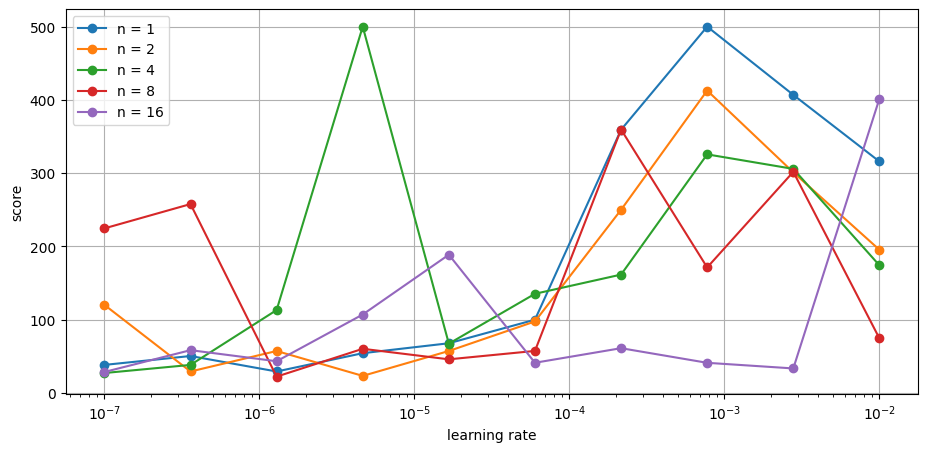

In [27]:
plt.figure(figsize=(11, 5))
for j, n in enumerate(n_list): 
    plt.plot(lr_list, final_results[:, j], '-o', label=f"n = {str(n)}")
plt.xlabel("learning rate")
plt.ylabel("score")
plt.xscale("log")
plt.grid()
plt.legend()
plt.show()

Each data point depicted in the above graph represents the most favorable outcome obtained from a set of ten distinct experiments conducted with identical $n$ and learning-rate values. Ideally, under optimal conditions, the resulting graph would resemble the figure 10.4 illustrated in Chapter 10.2 of [1]. However, besides the variation of the learning-rate, no other hyperparameters were optimized. Nevertheless, intriguing qualitative behavior is observed with certain learning-rate intervals yielding better performance for different values of $n$.

## Conclusion

We have implemented a modified version of the Off-policy Reinforcement Learning (RL) algorithm Off-policy n-step Expected-SARSA. The algorithm employs an experience replay buffer and a neural network representation for the Q-function. The experience replay buffer operates by managing n-step transitions rather than the original 0-step transitions. We conclude by training the Q-network with batches of n-step transitions on the Cart-Pole Gymnasium environment. For a more lucid comprehension of the Off-policy n-step Expected-SARSA algorithm, it is recommended to review the notebooks encompassing the n-step SARSA tabular implementation and the Expected-SARSA implementation, which precisely follows the pseudocode outlined in [1].

## References
- [1] Sutton & Barto - Reinforcement Learning An Introduction Second edition (2018)

## Contact
If you have any comments, corrections or questions about the material presented in the notebook, please do not hesitate to email me at elkabetz.roy@gmail.com